In [1]:
from typing import Any, List
import pandas as pd
import os
import numpy as np
import json
from openpyxl import load_workbook
from openpyxl.styles import Font


from metrics.classes import (
    getSingletonDataset,
    getSingletonModel,
    getSingletonTask,
    SINGLETON,
    DATASETS,
    PublicDataset,
    get_formated_scores
)
from metrics.utils import (
    plot_spider,
    plot_histo,
    stable_sigmoid,
    to_percentage,
    sl_ssl_ds_size,
    get_centers_pred_labels,
    save_pred_in_df,

    stable_sigmoid
)


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


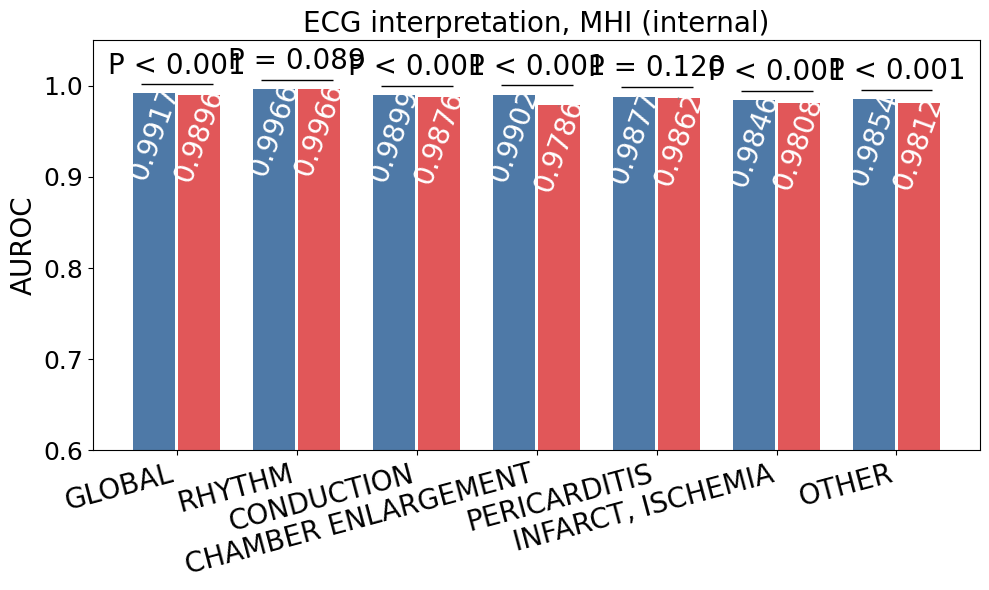

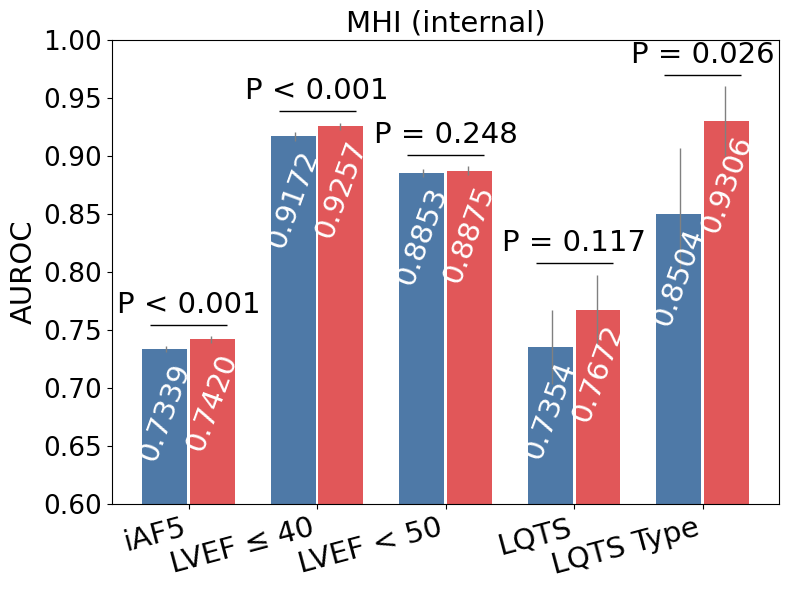

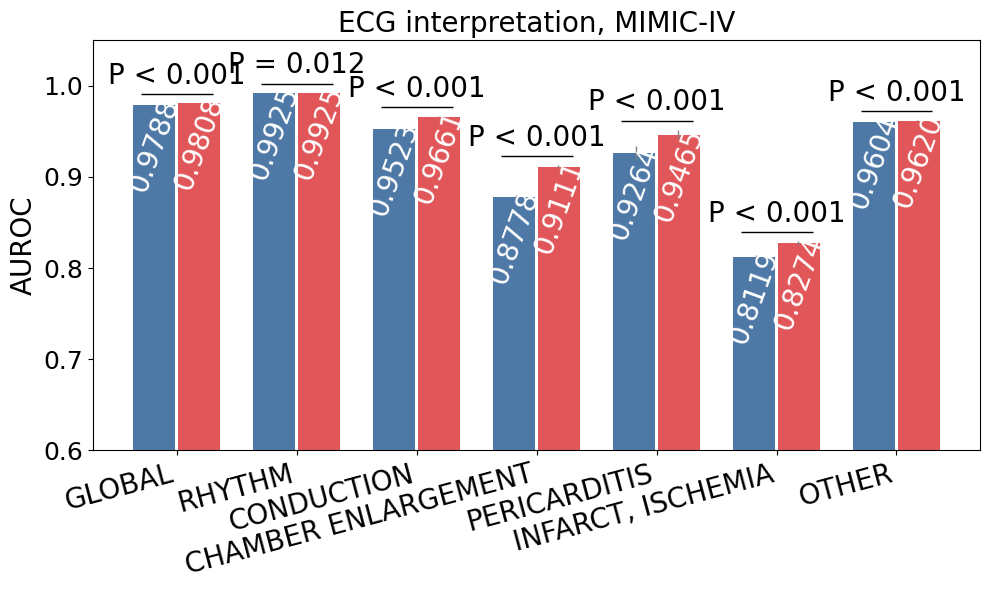

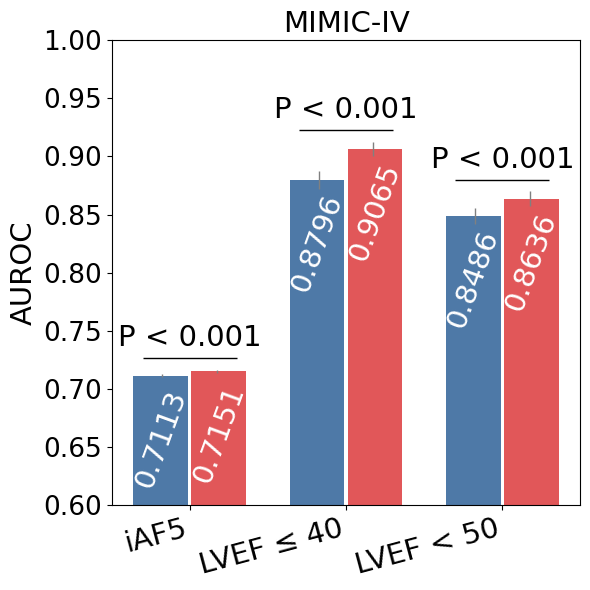

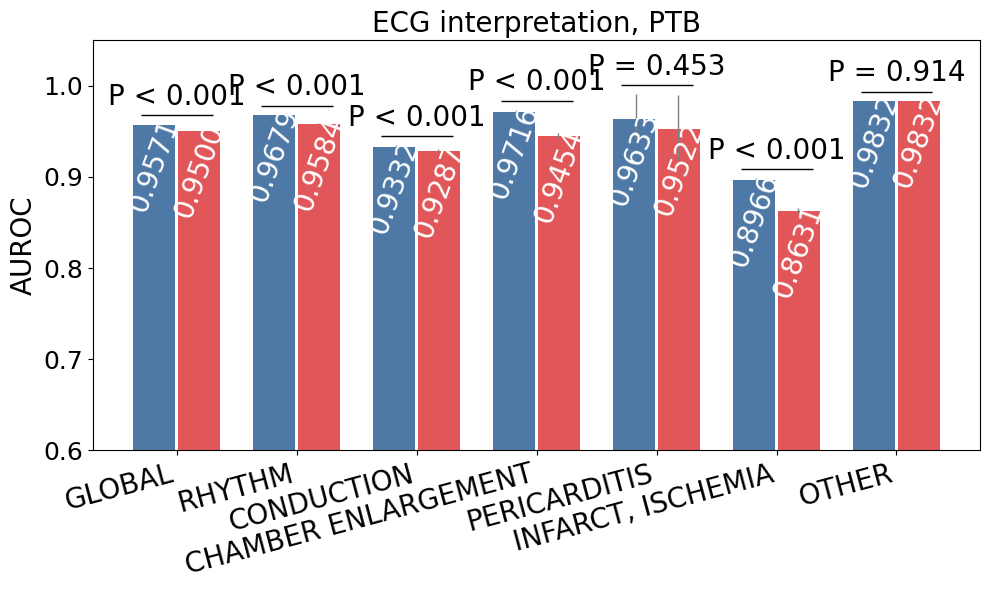

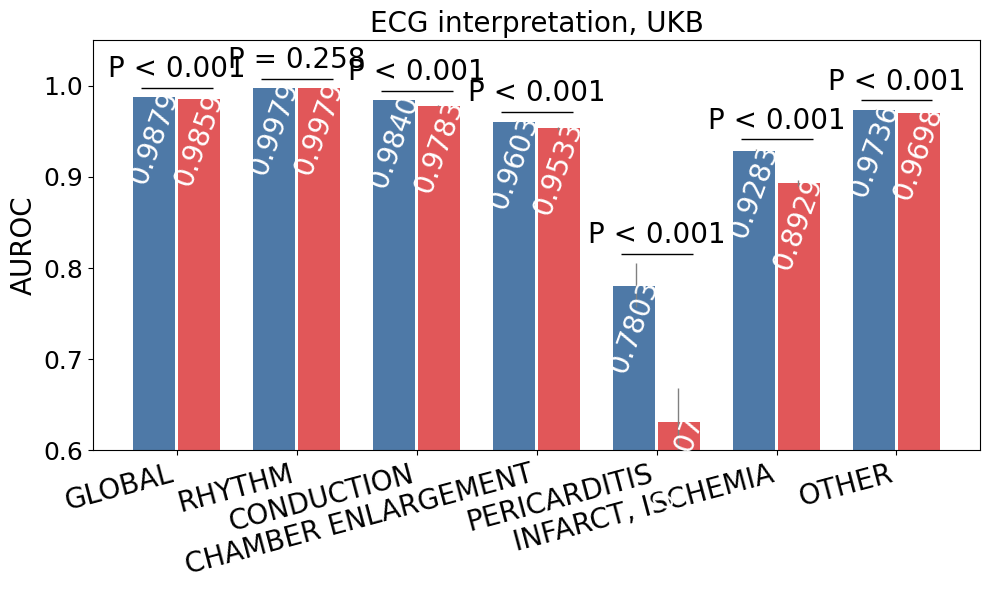

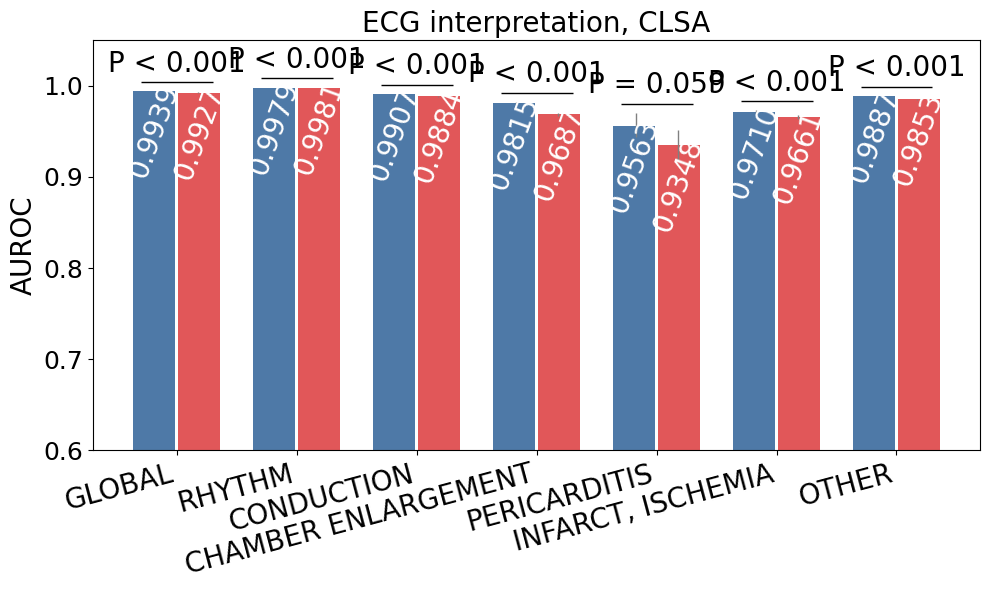

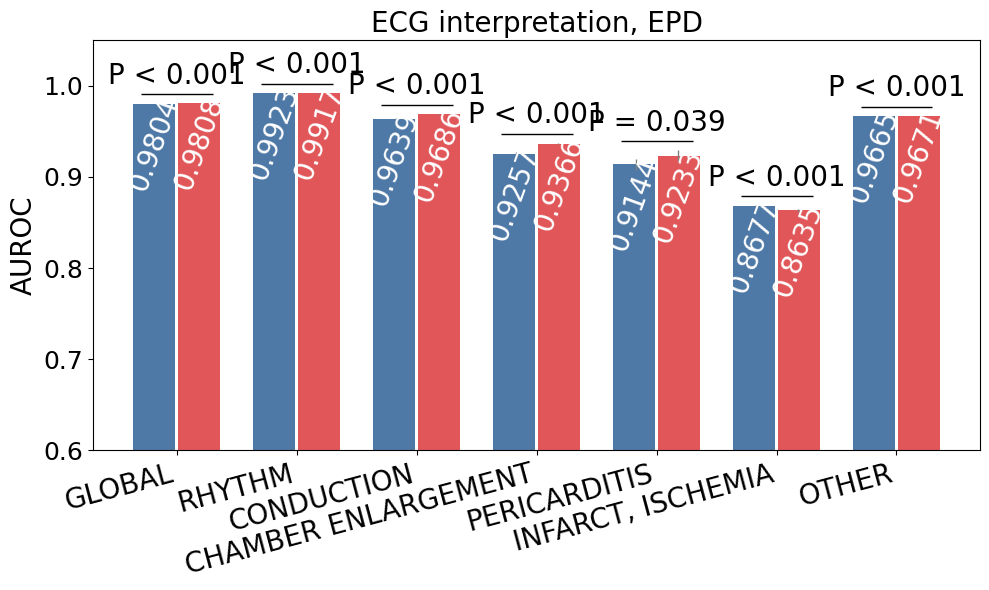

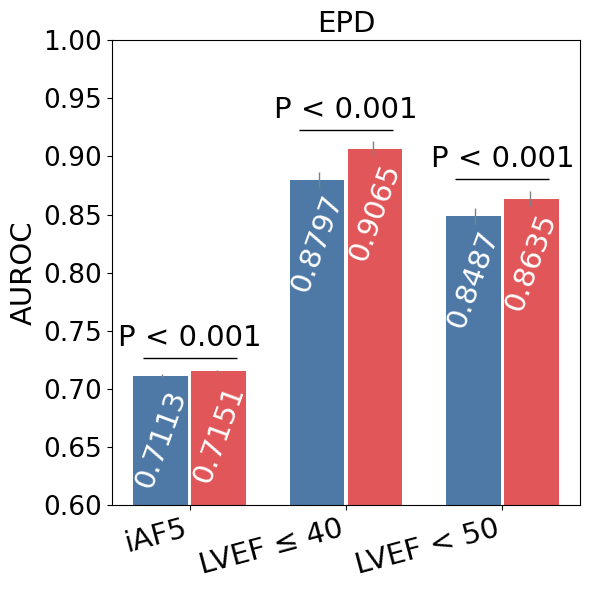

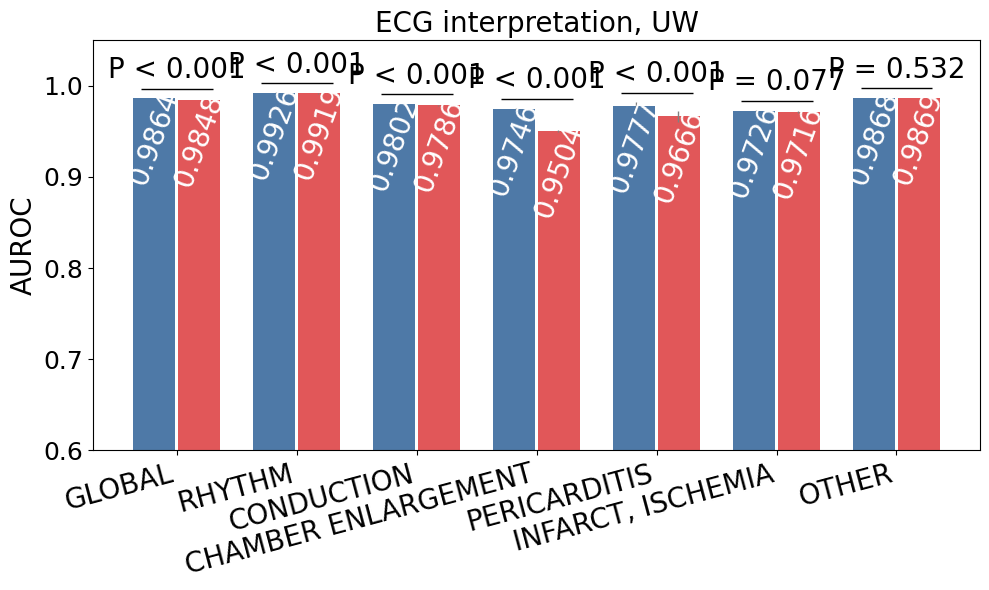

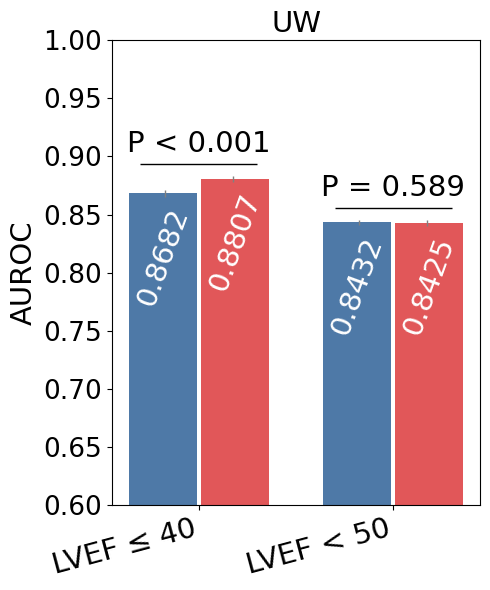

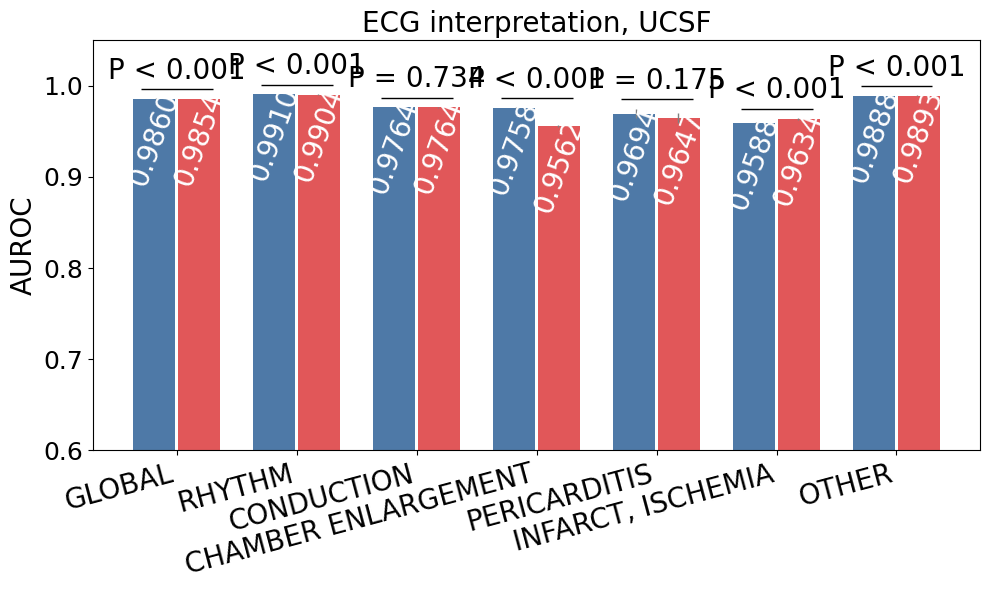

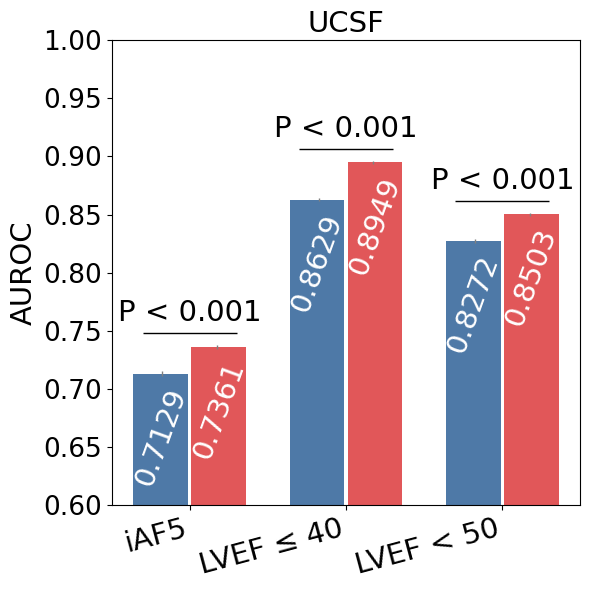

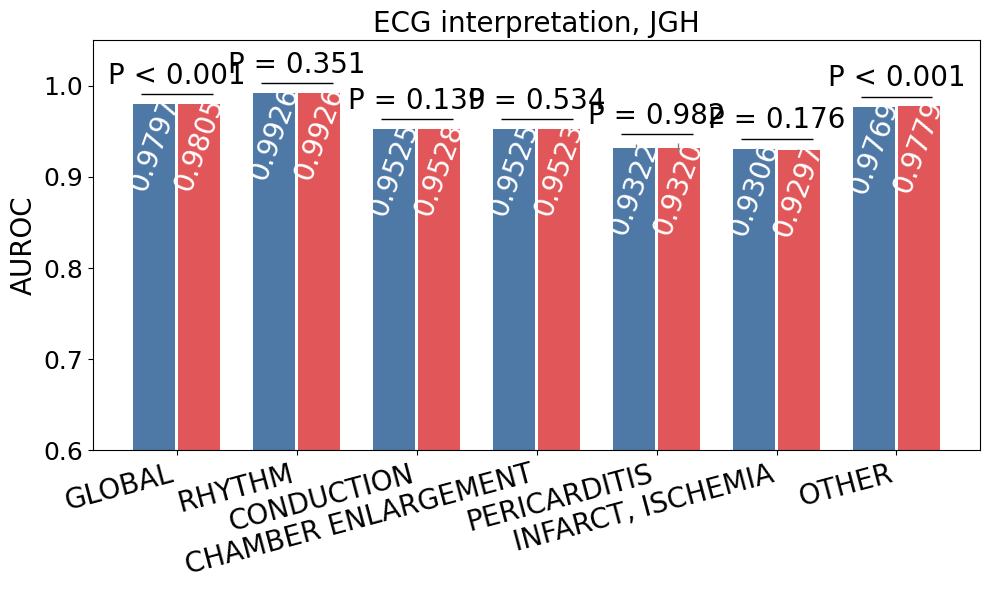

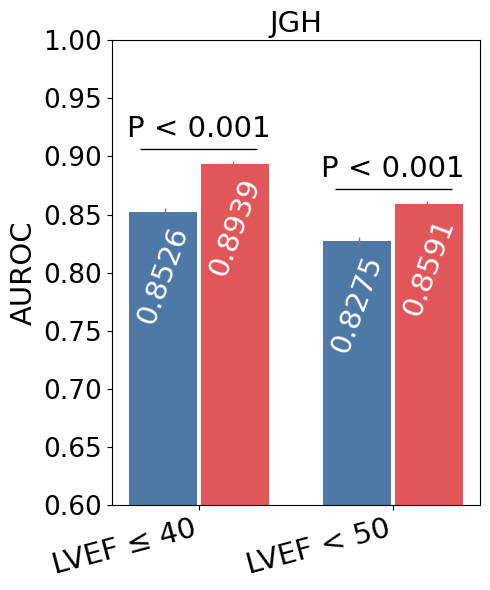

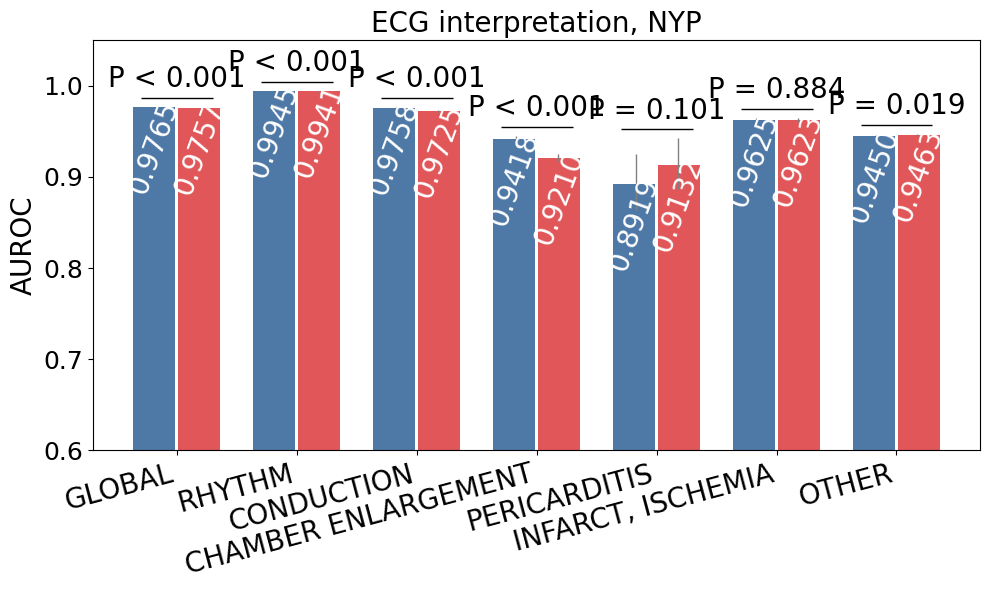

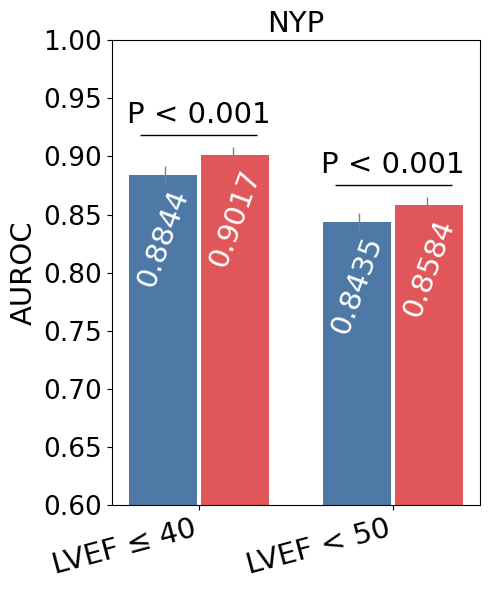

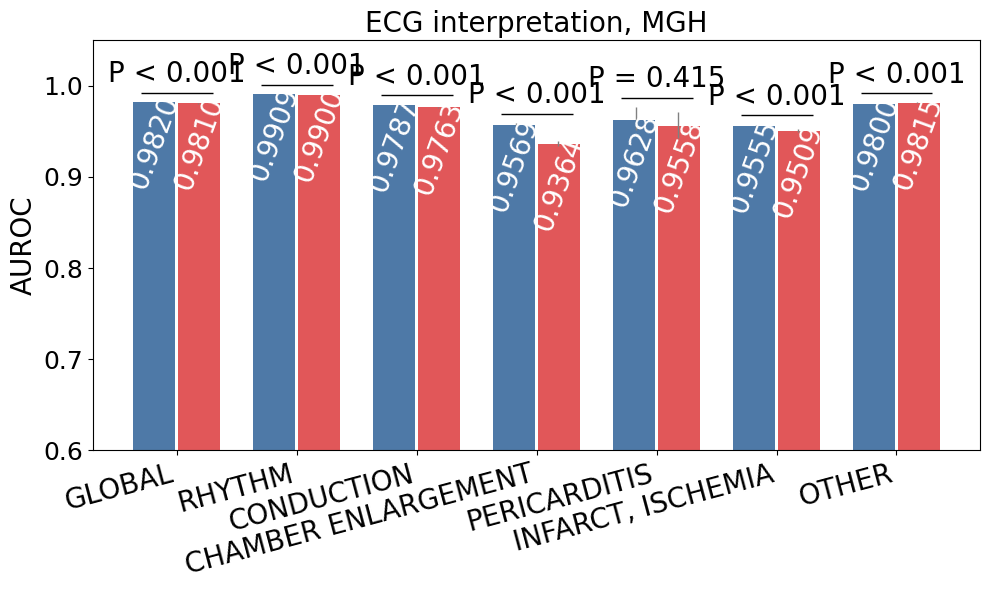

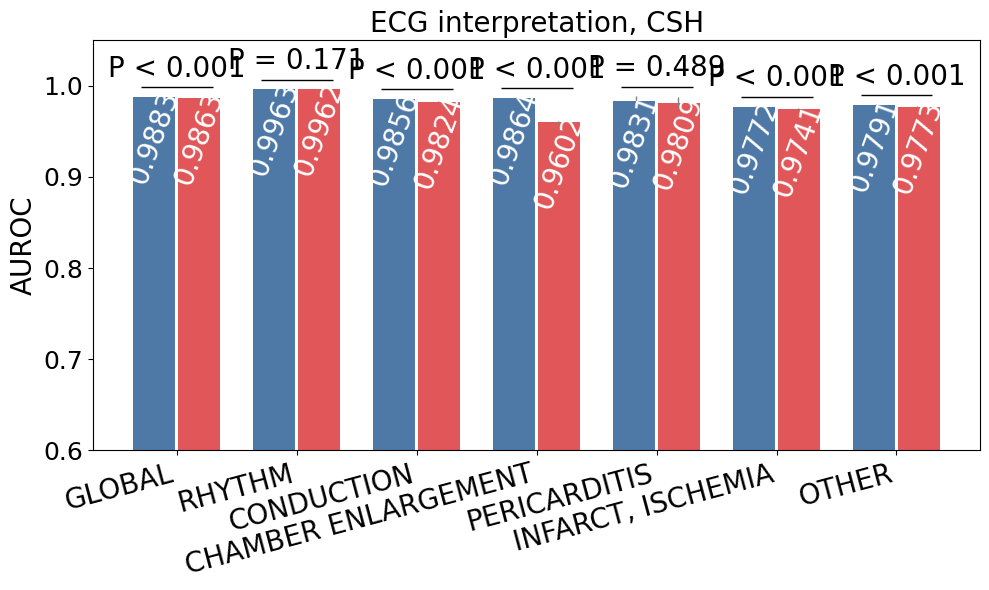

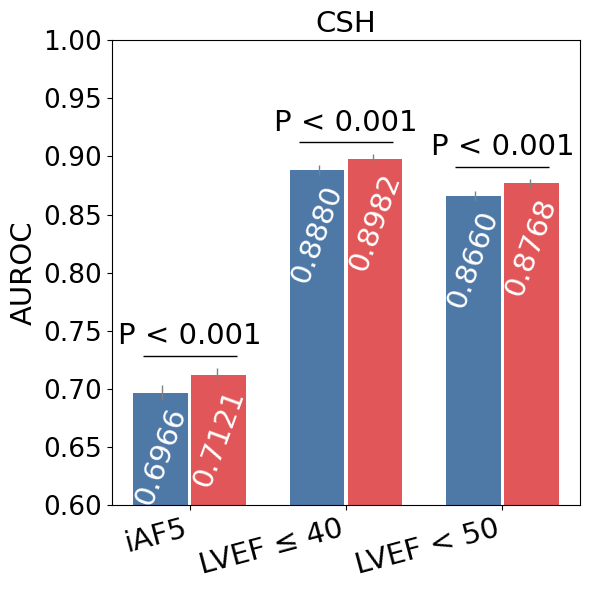

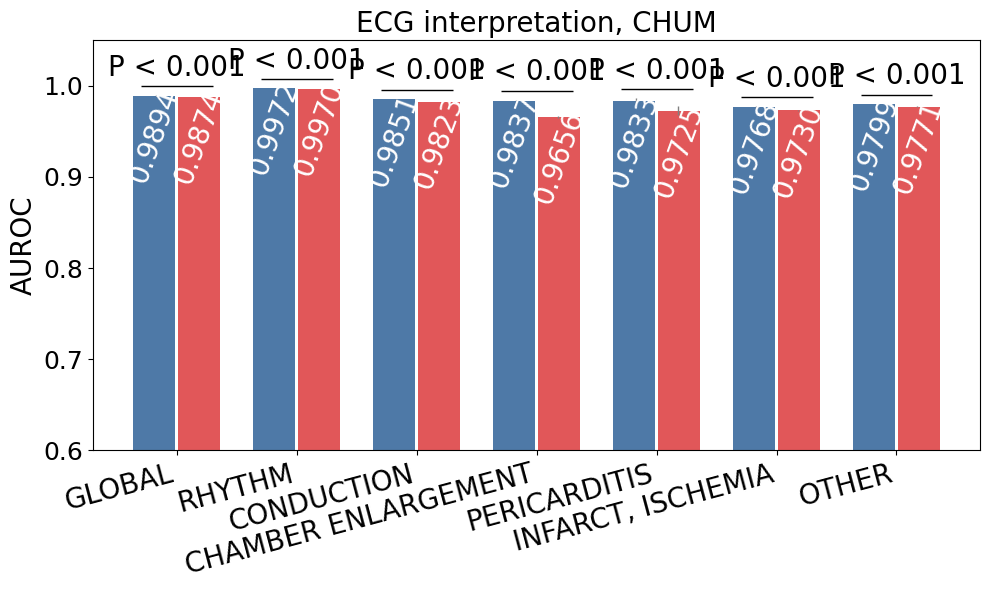

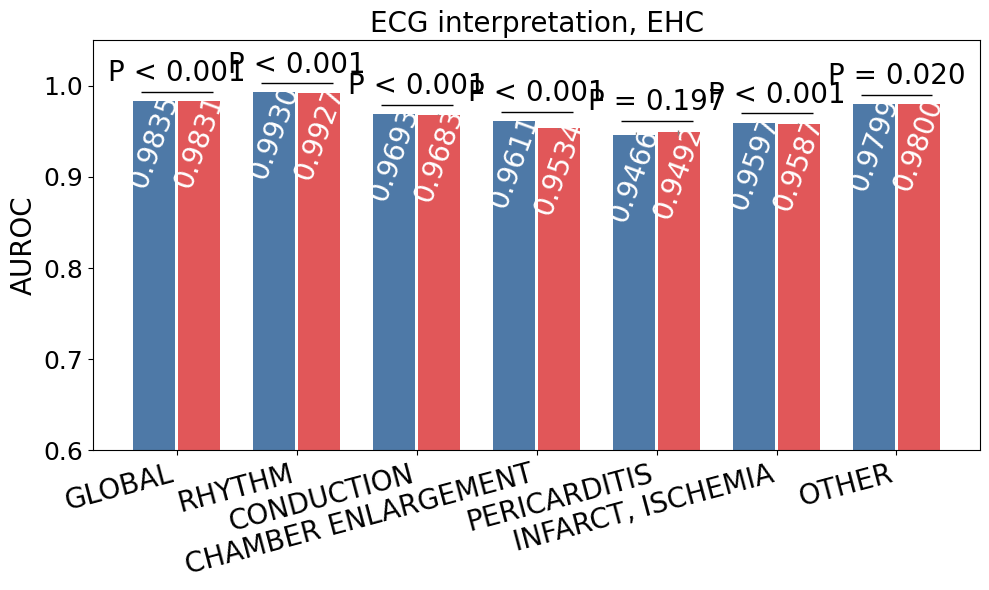

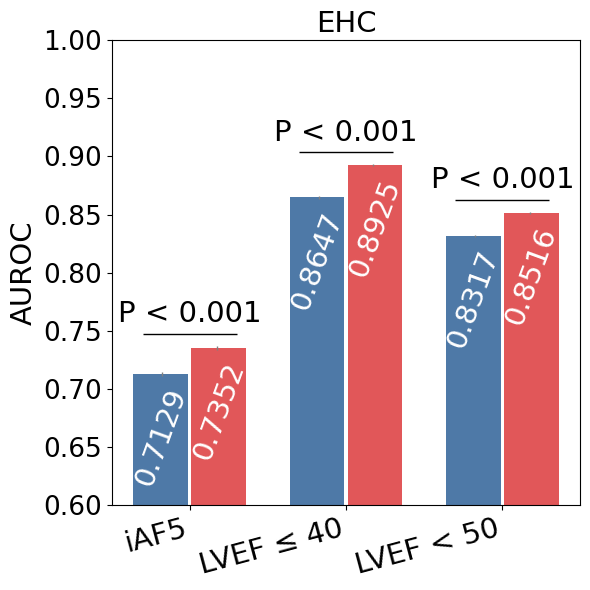

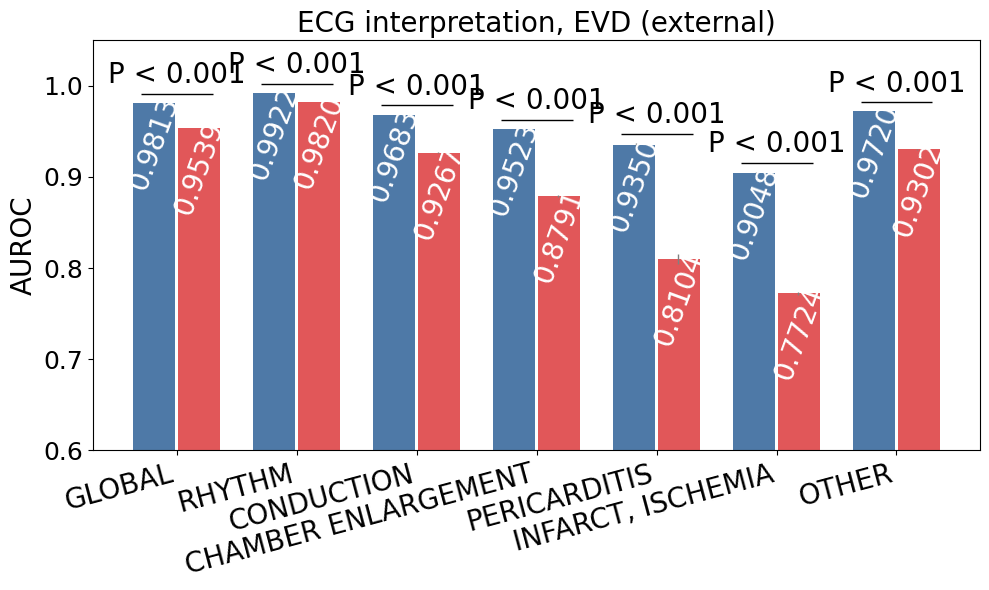

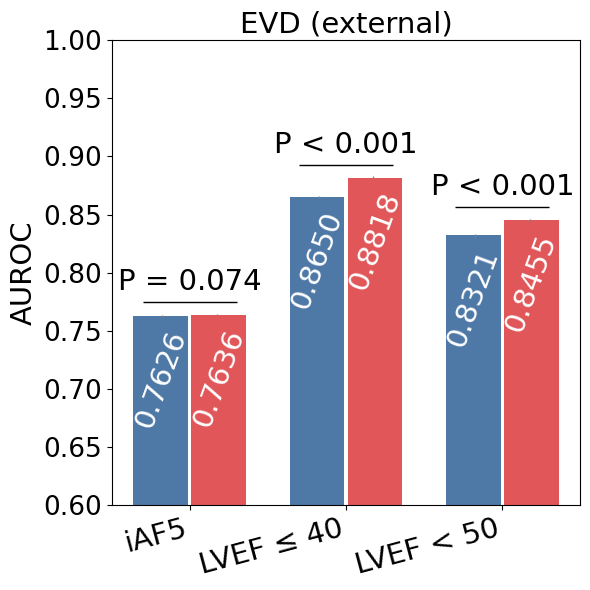

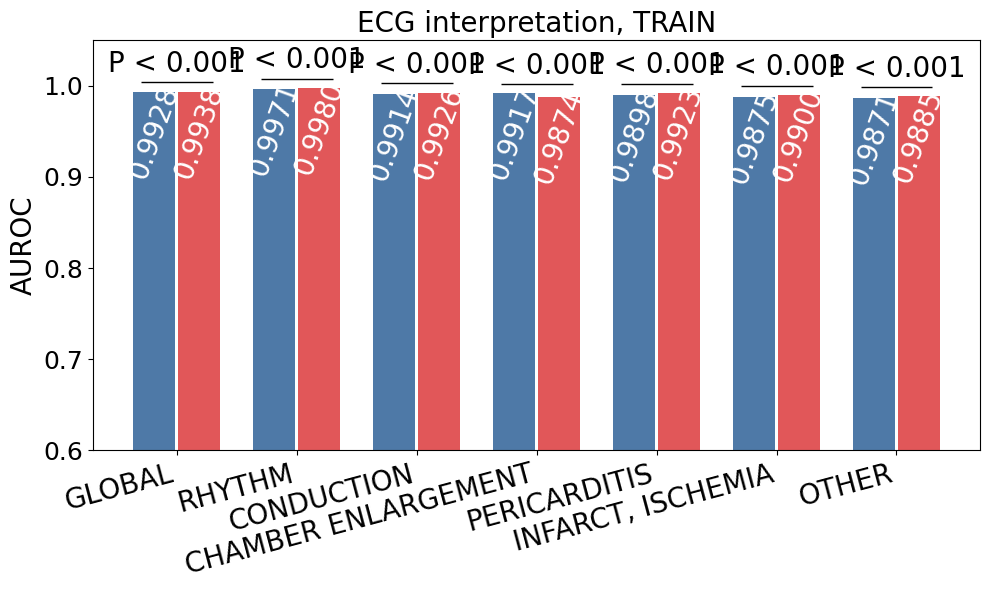

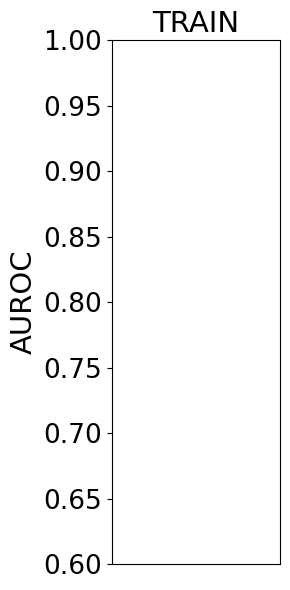

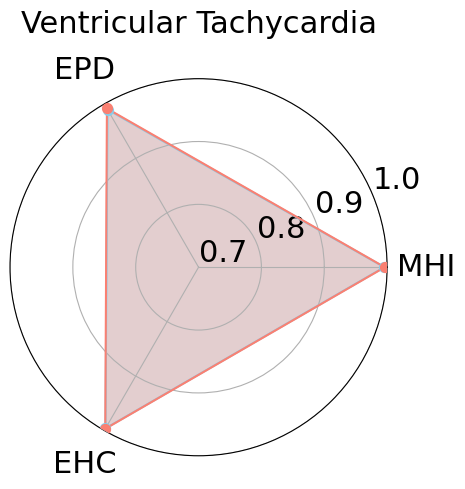

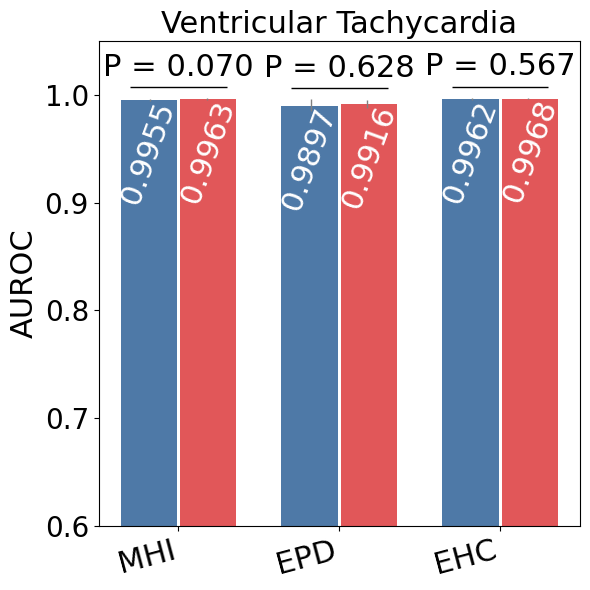

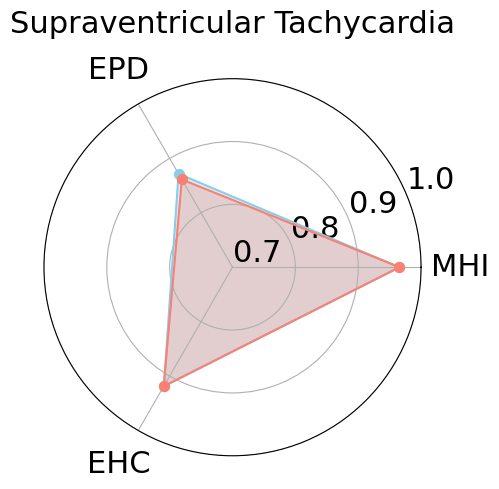

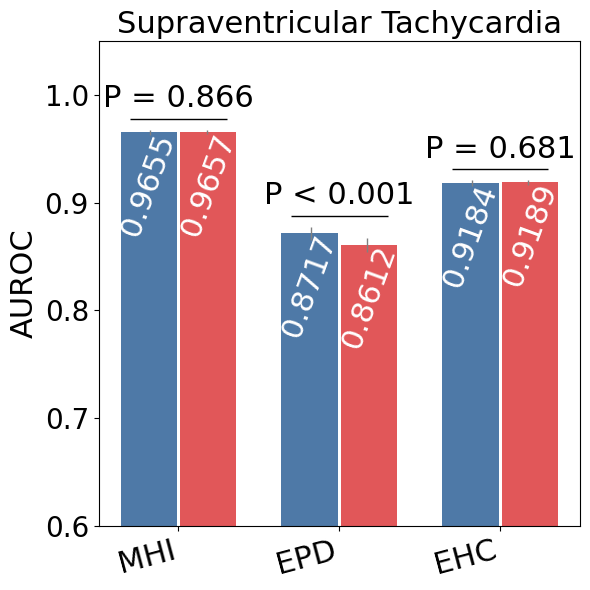

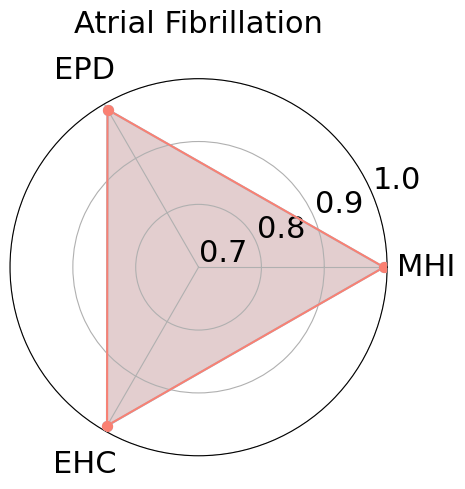

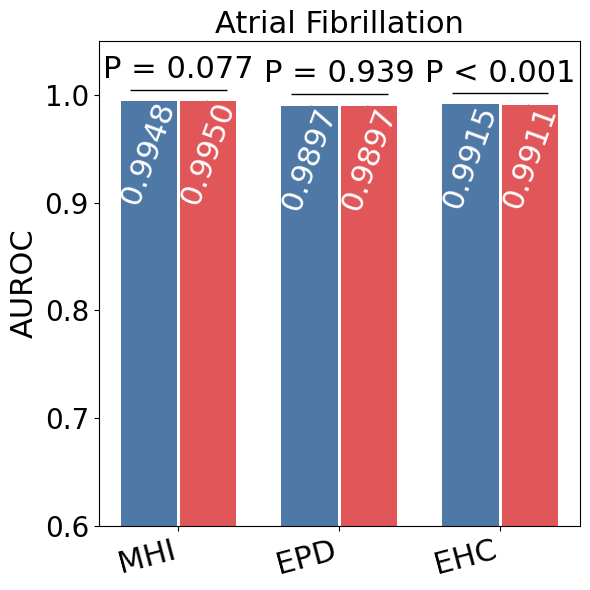

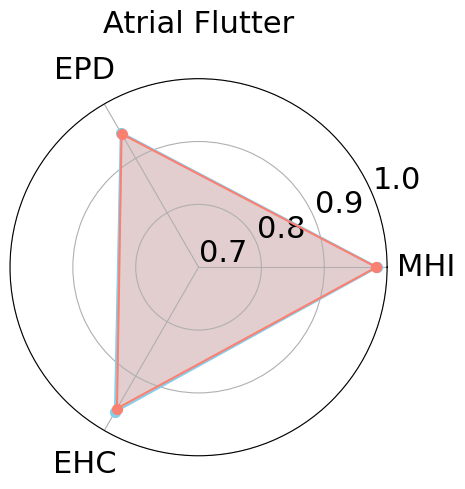

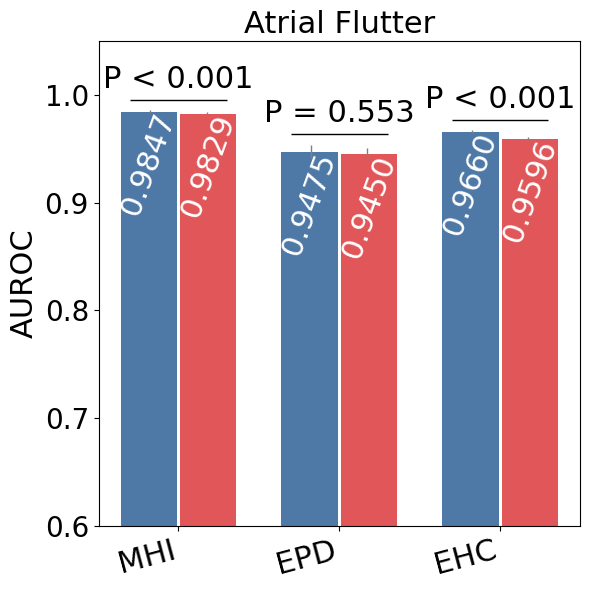

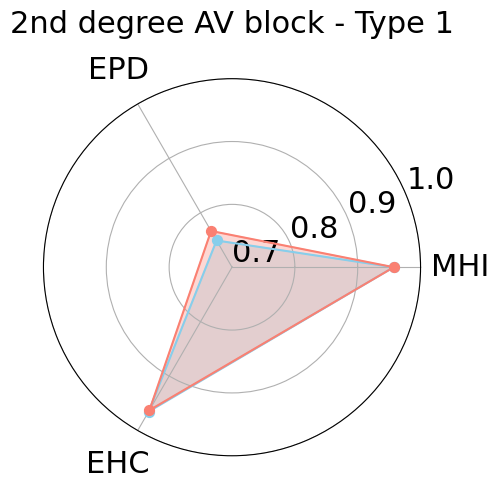

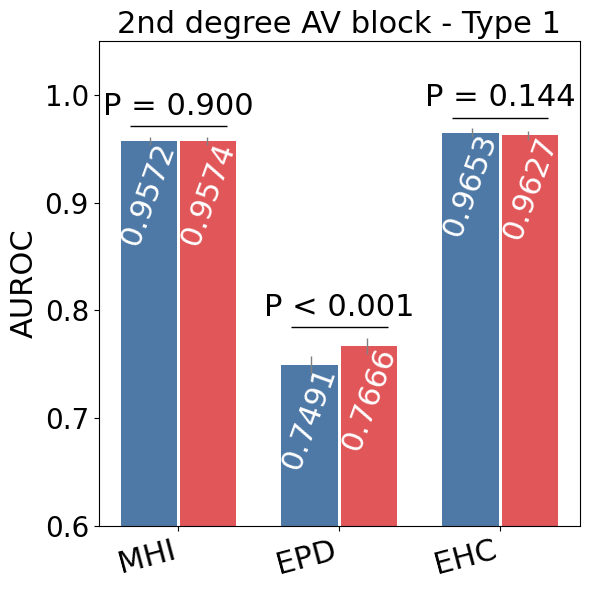

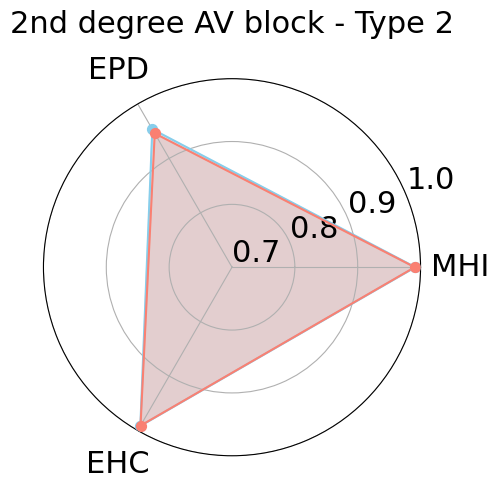

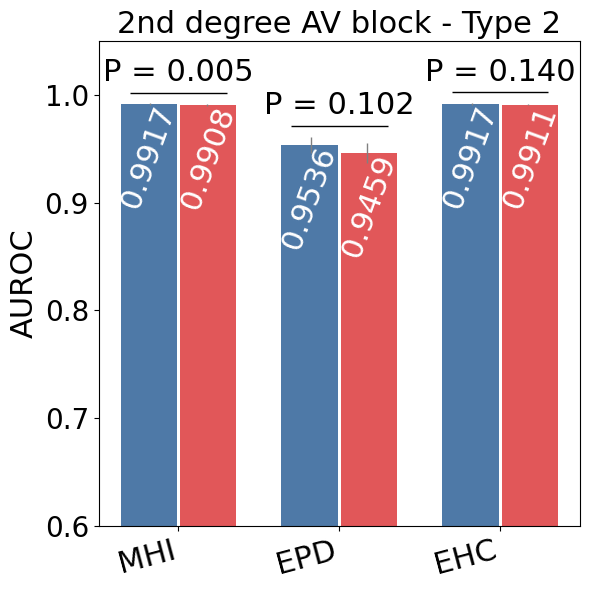

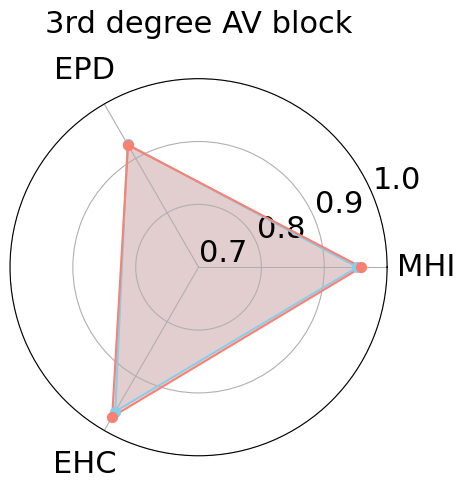

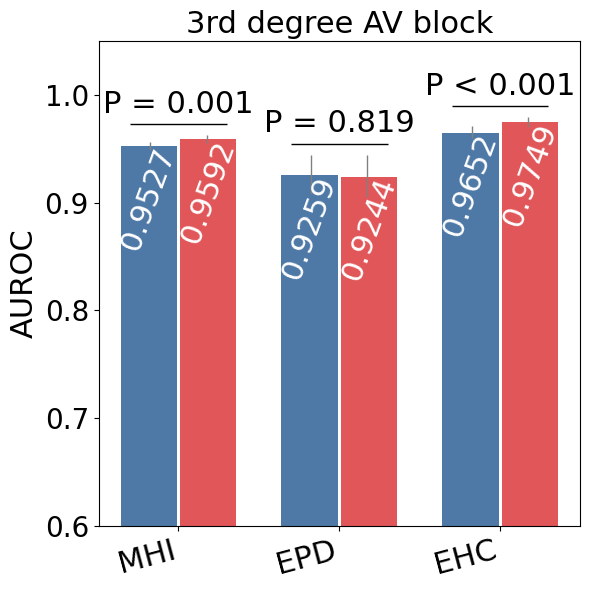

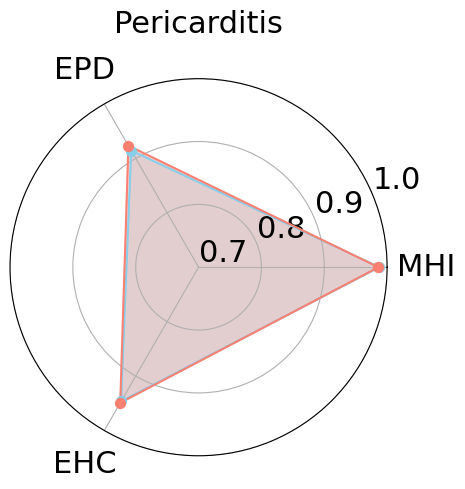

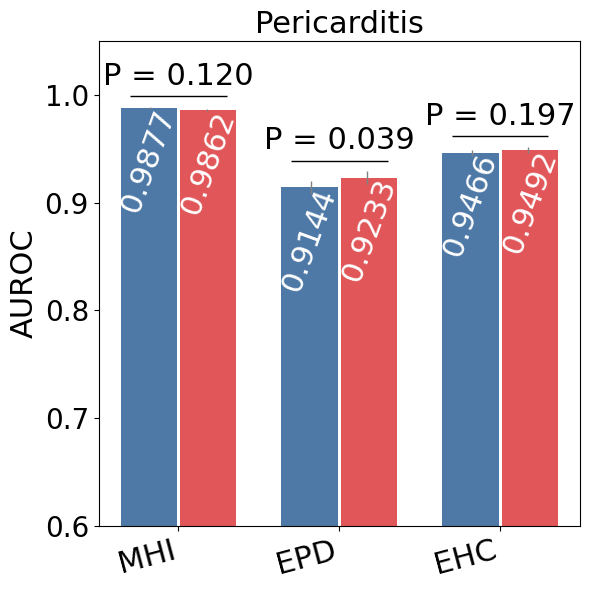

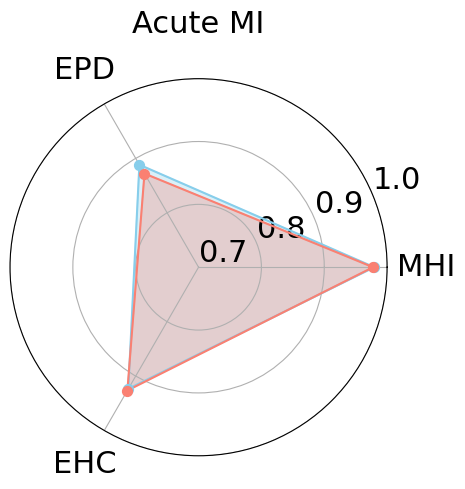

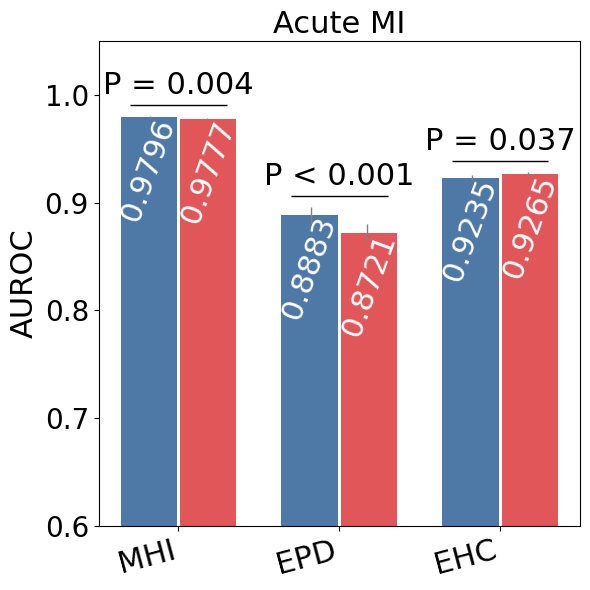

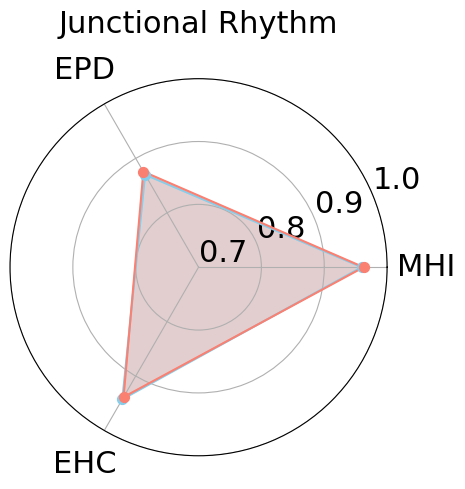

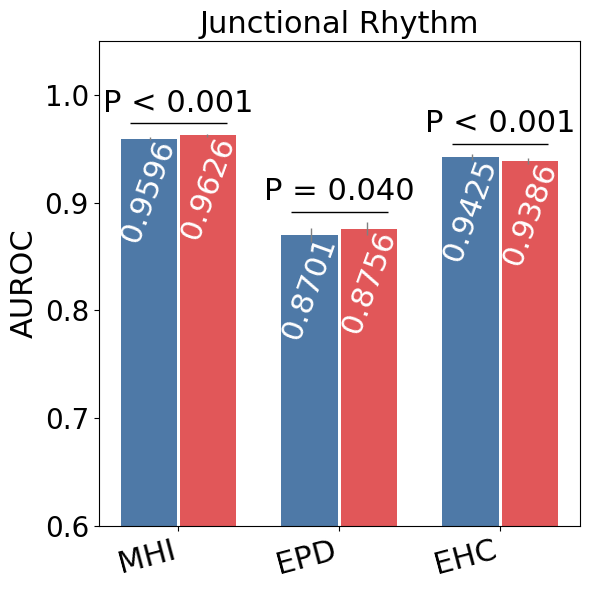

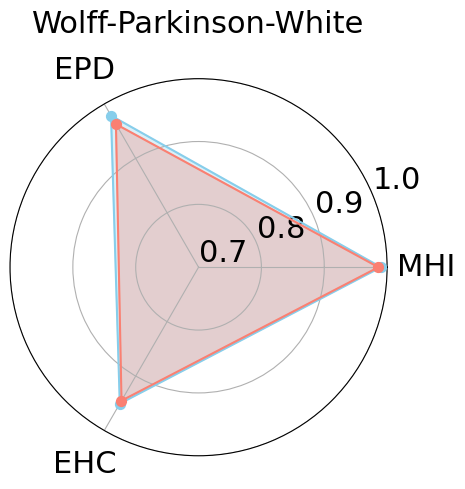

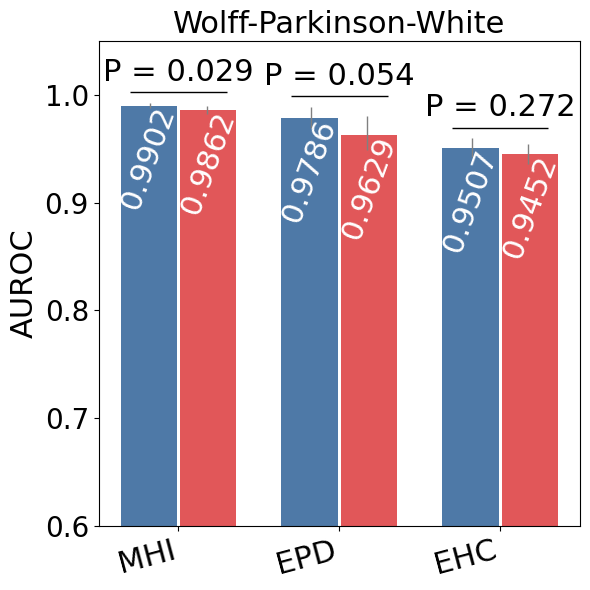

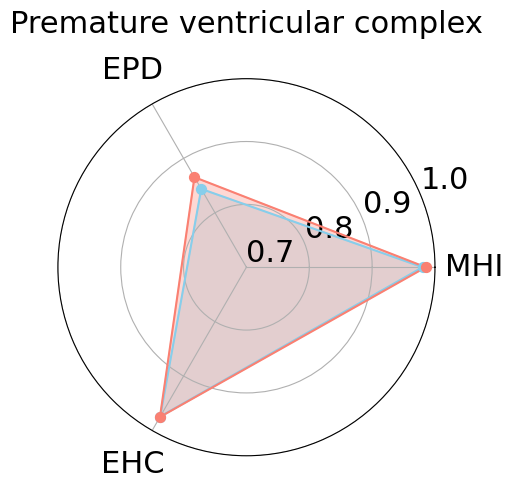

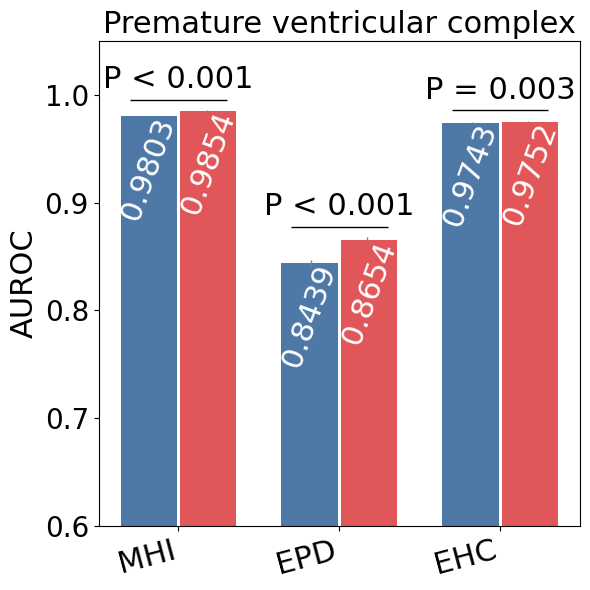

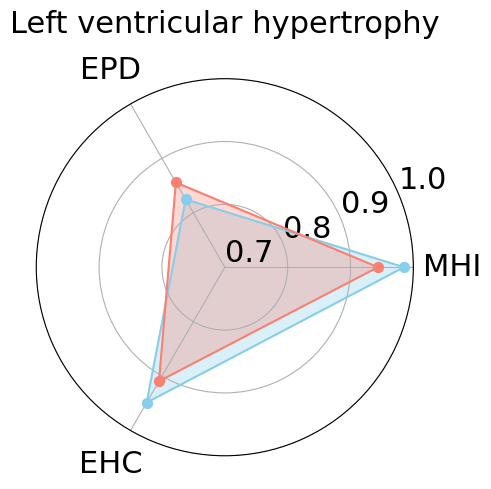

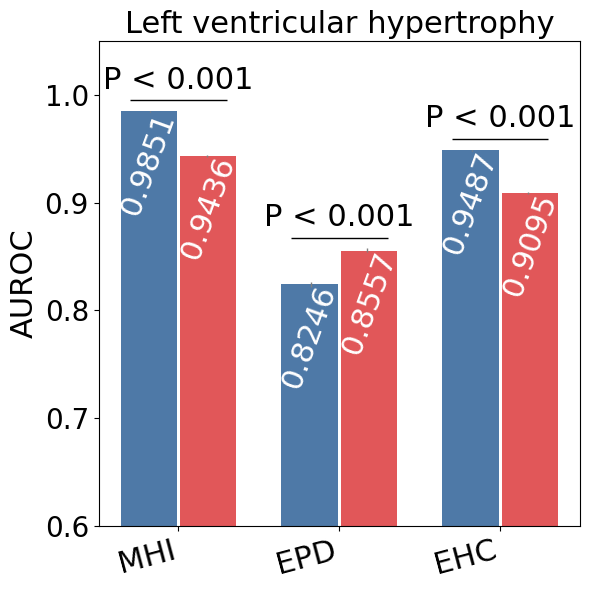

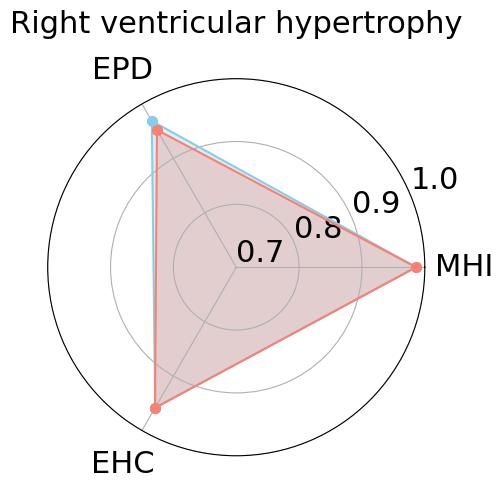

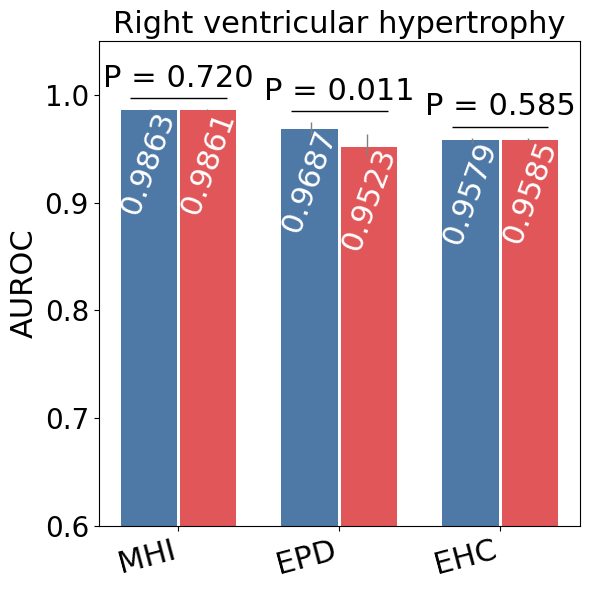

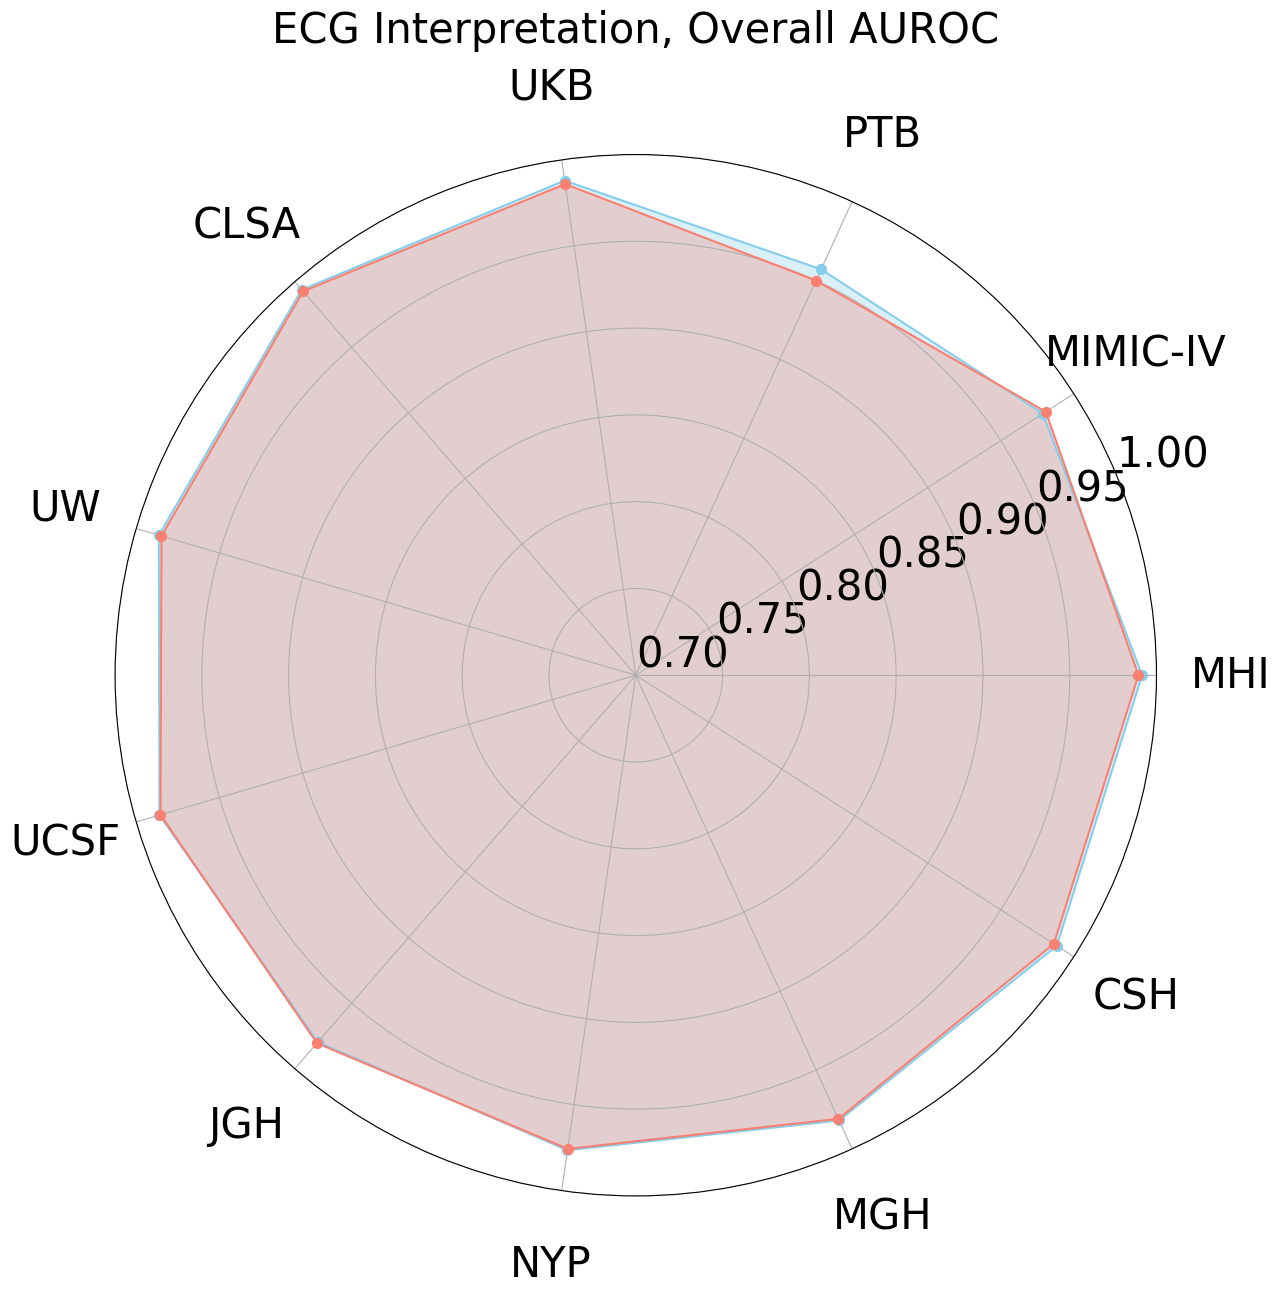

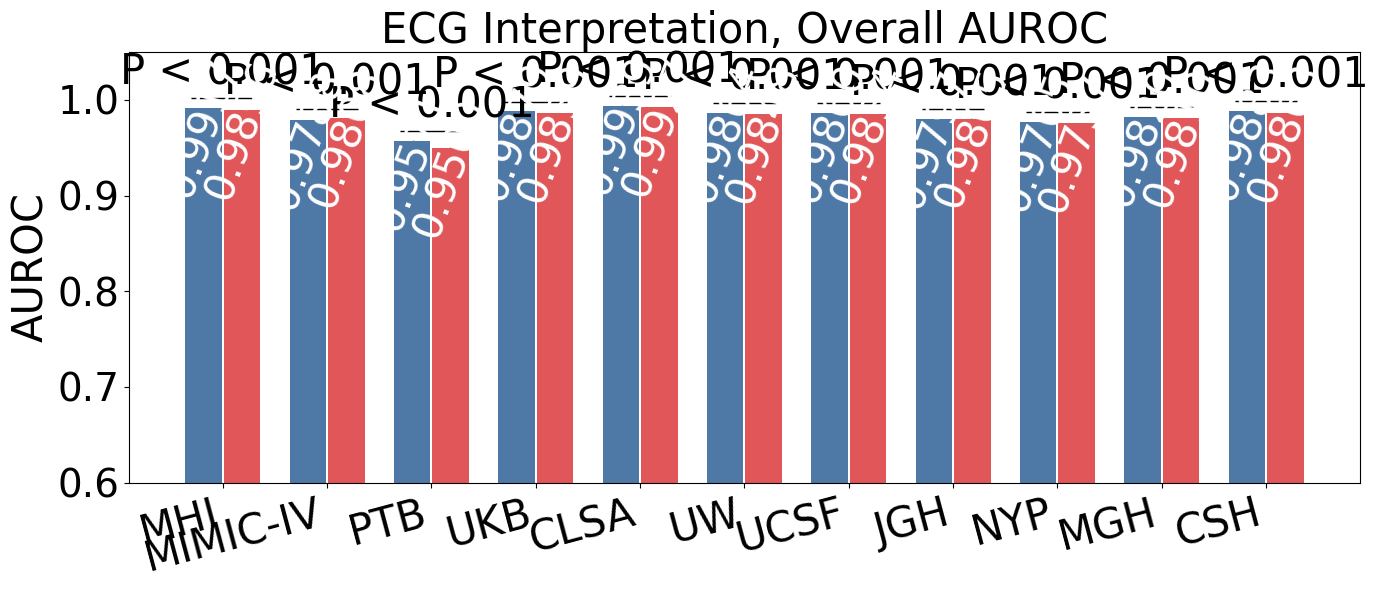

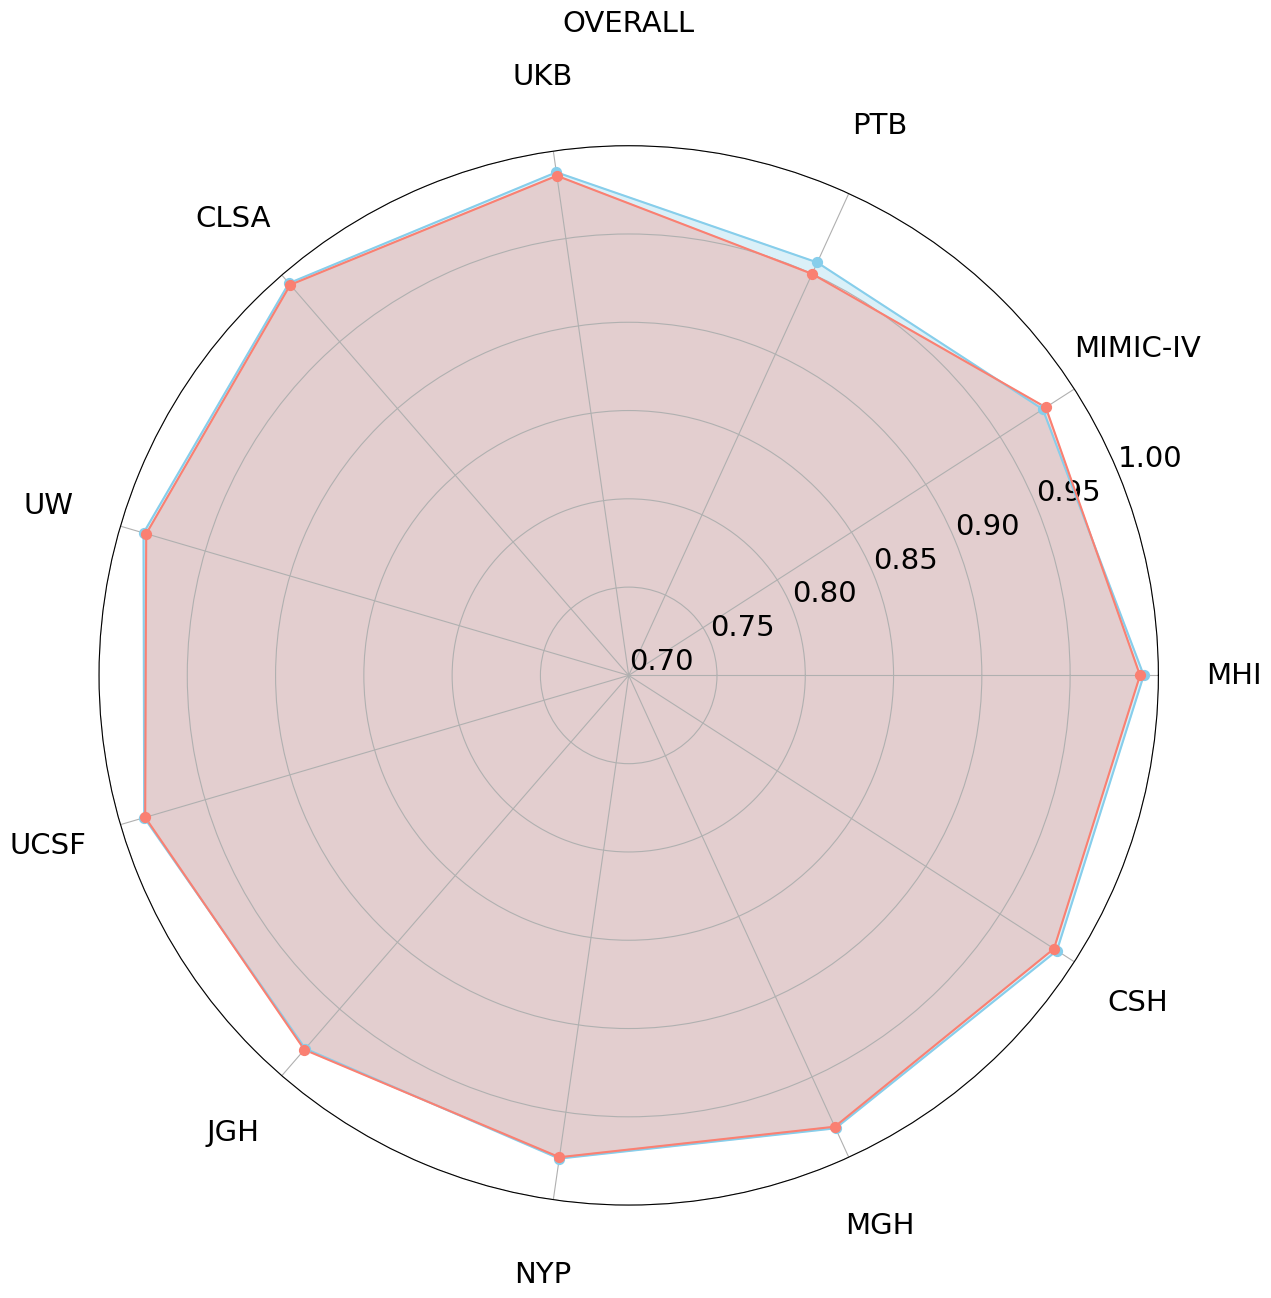

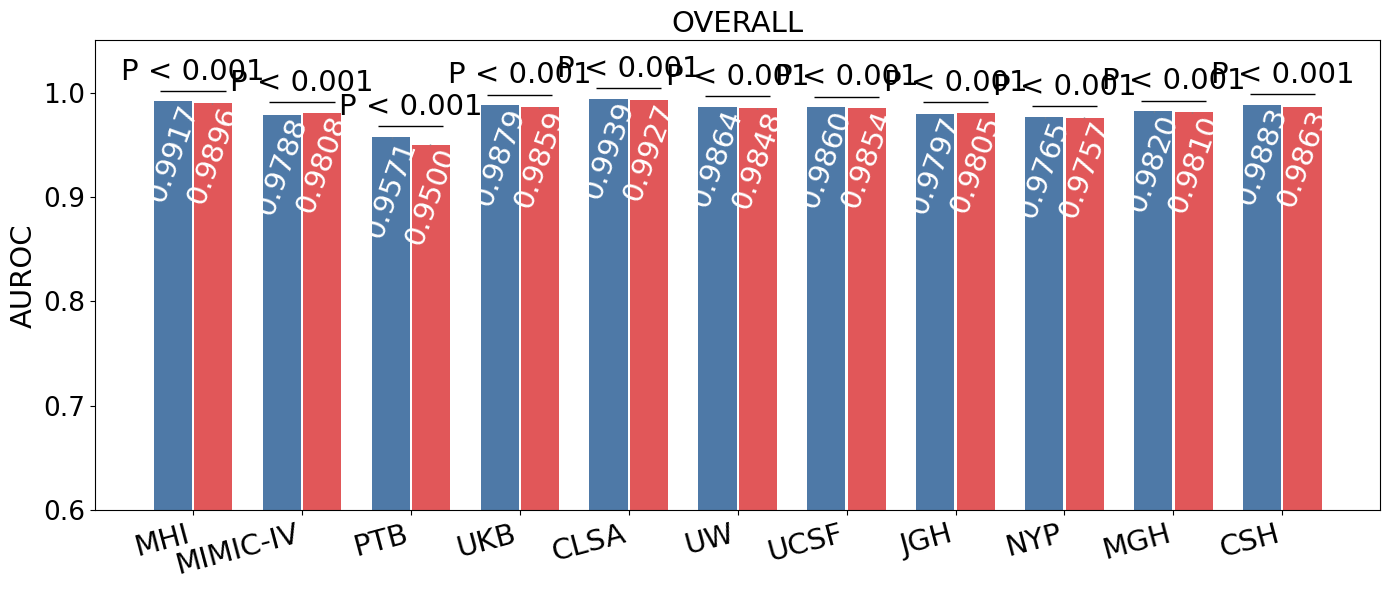

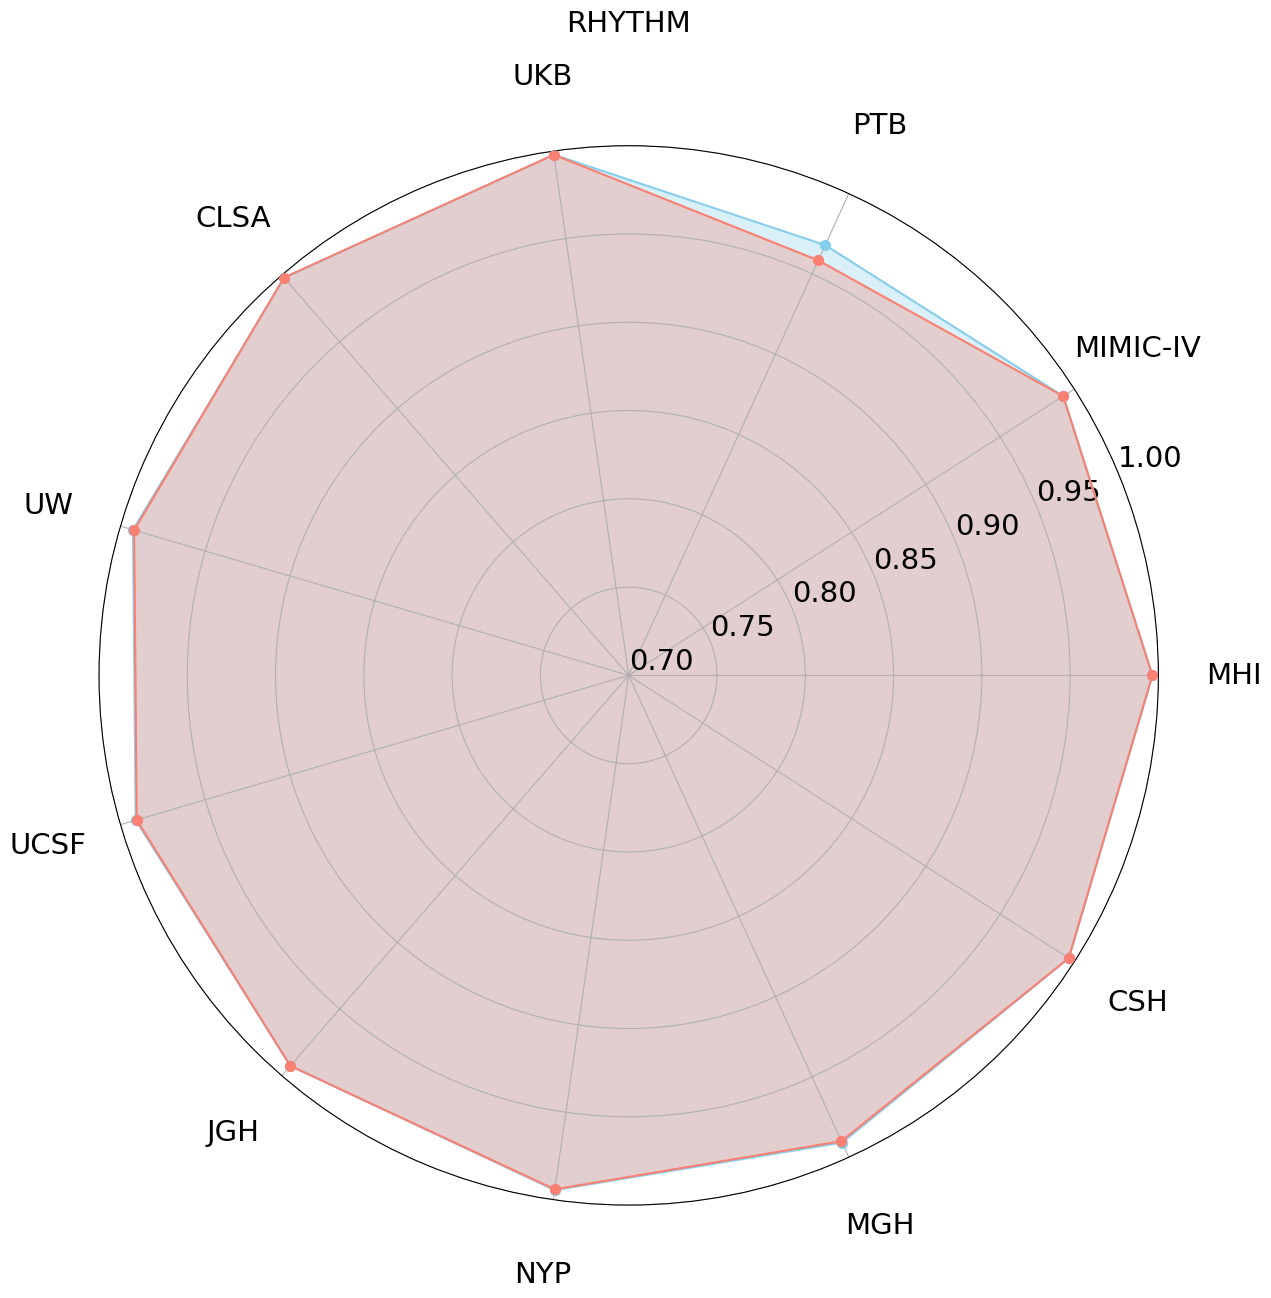

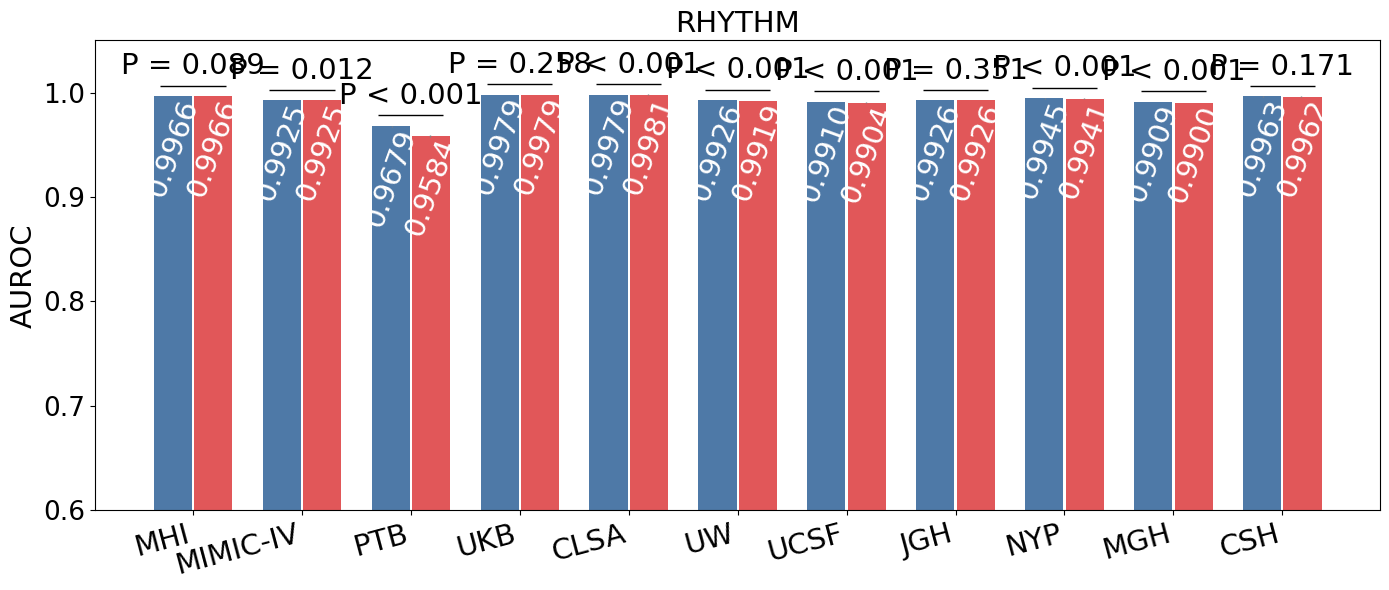

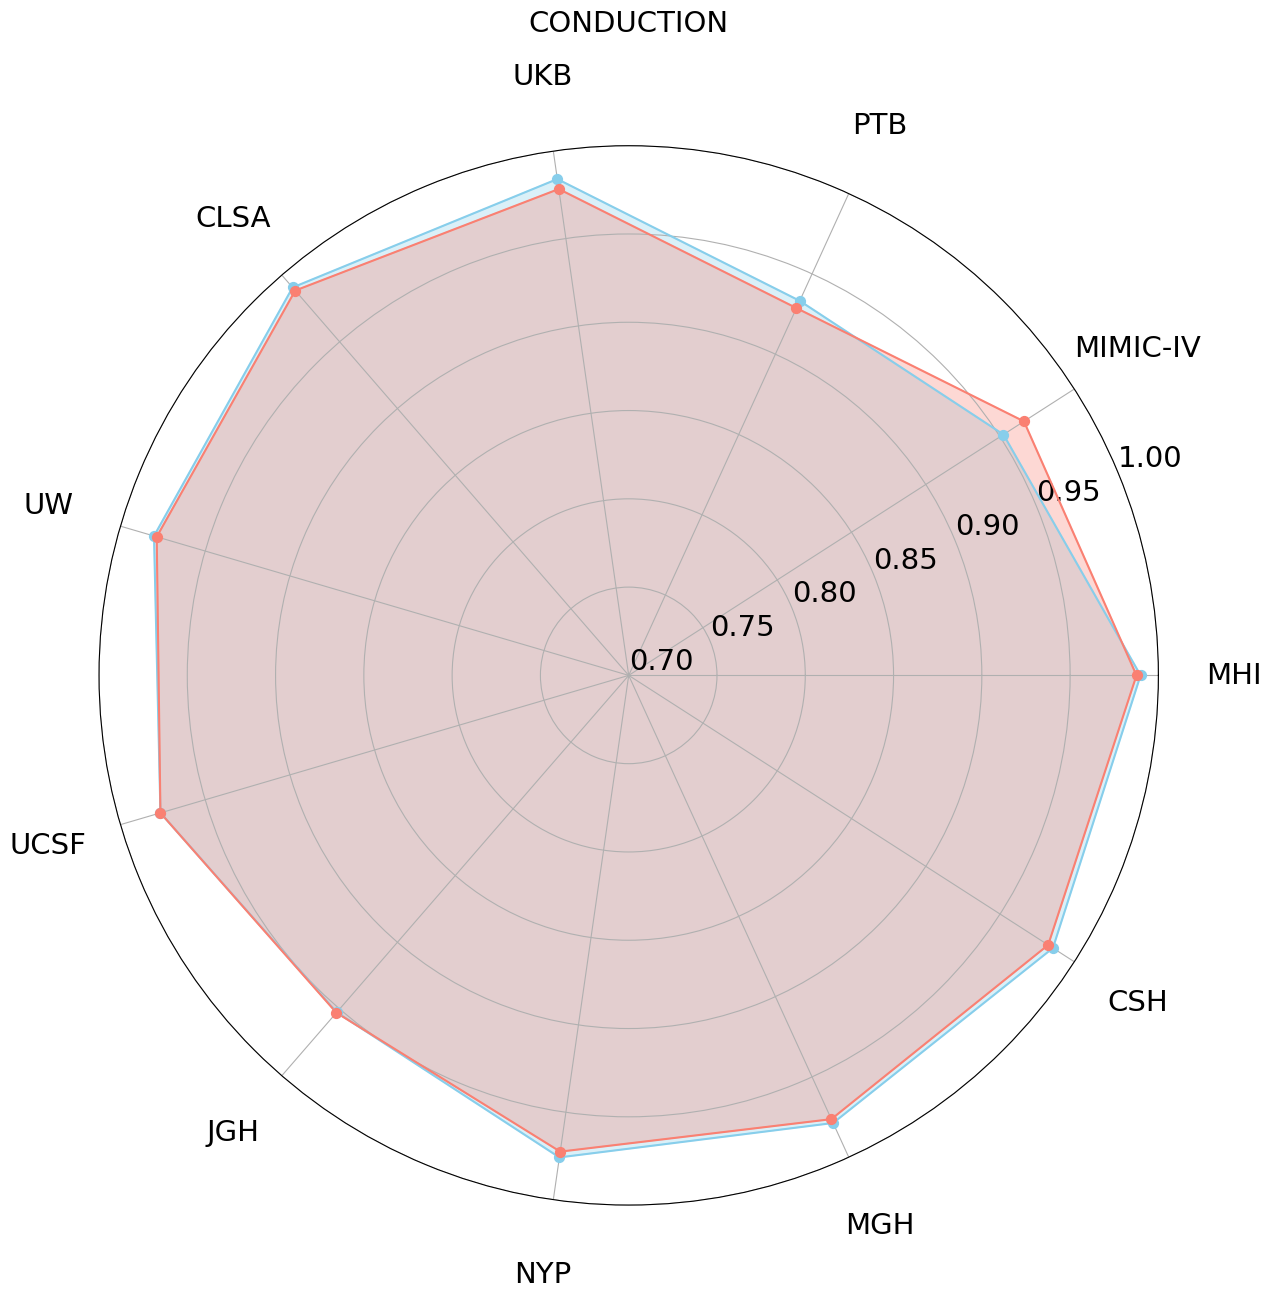

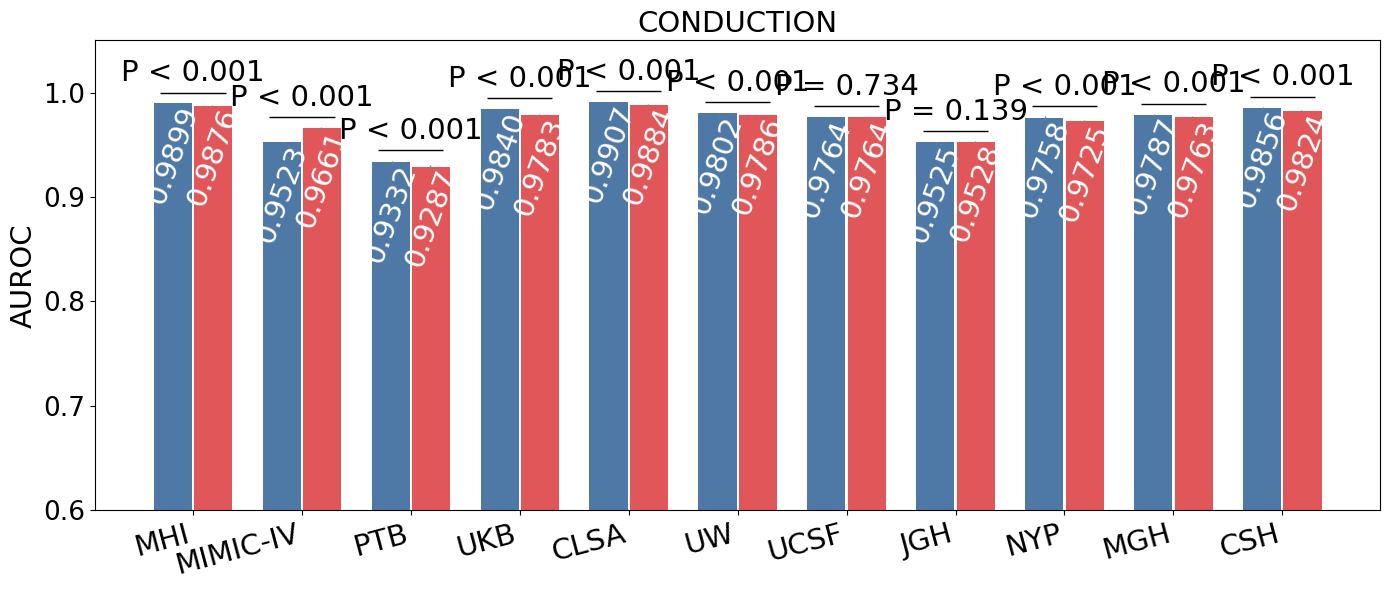

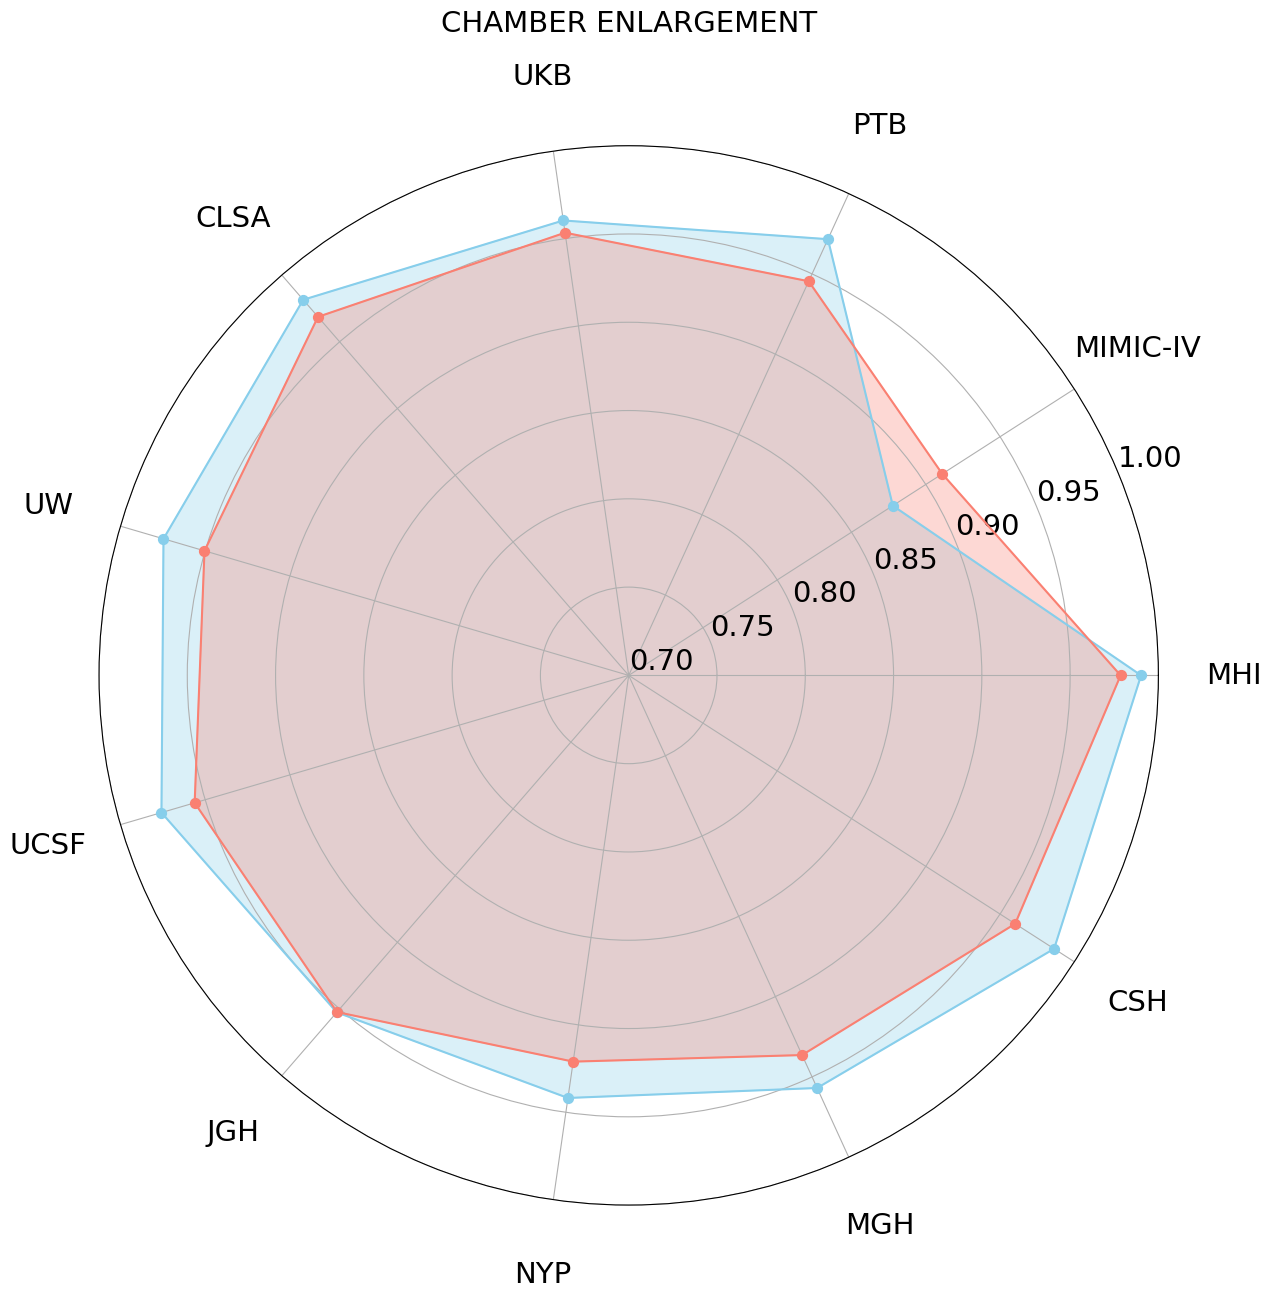

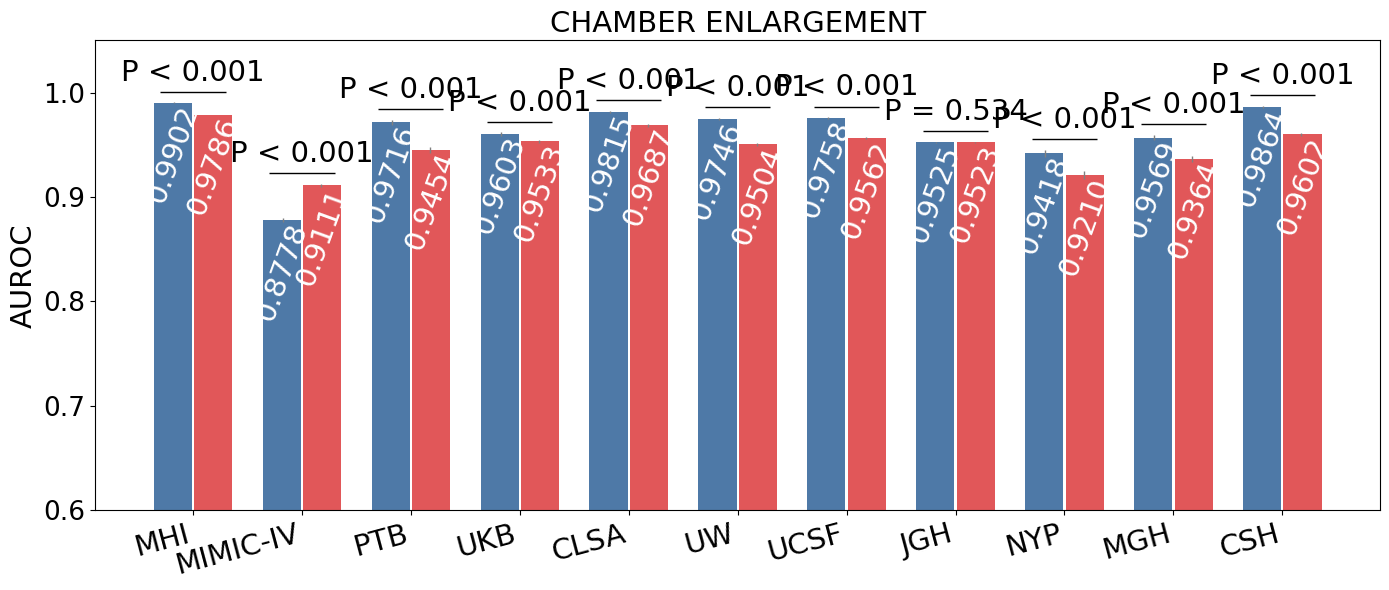

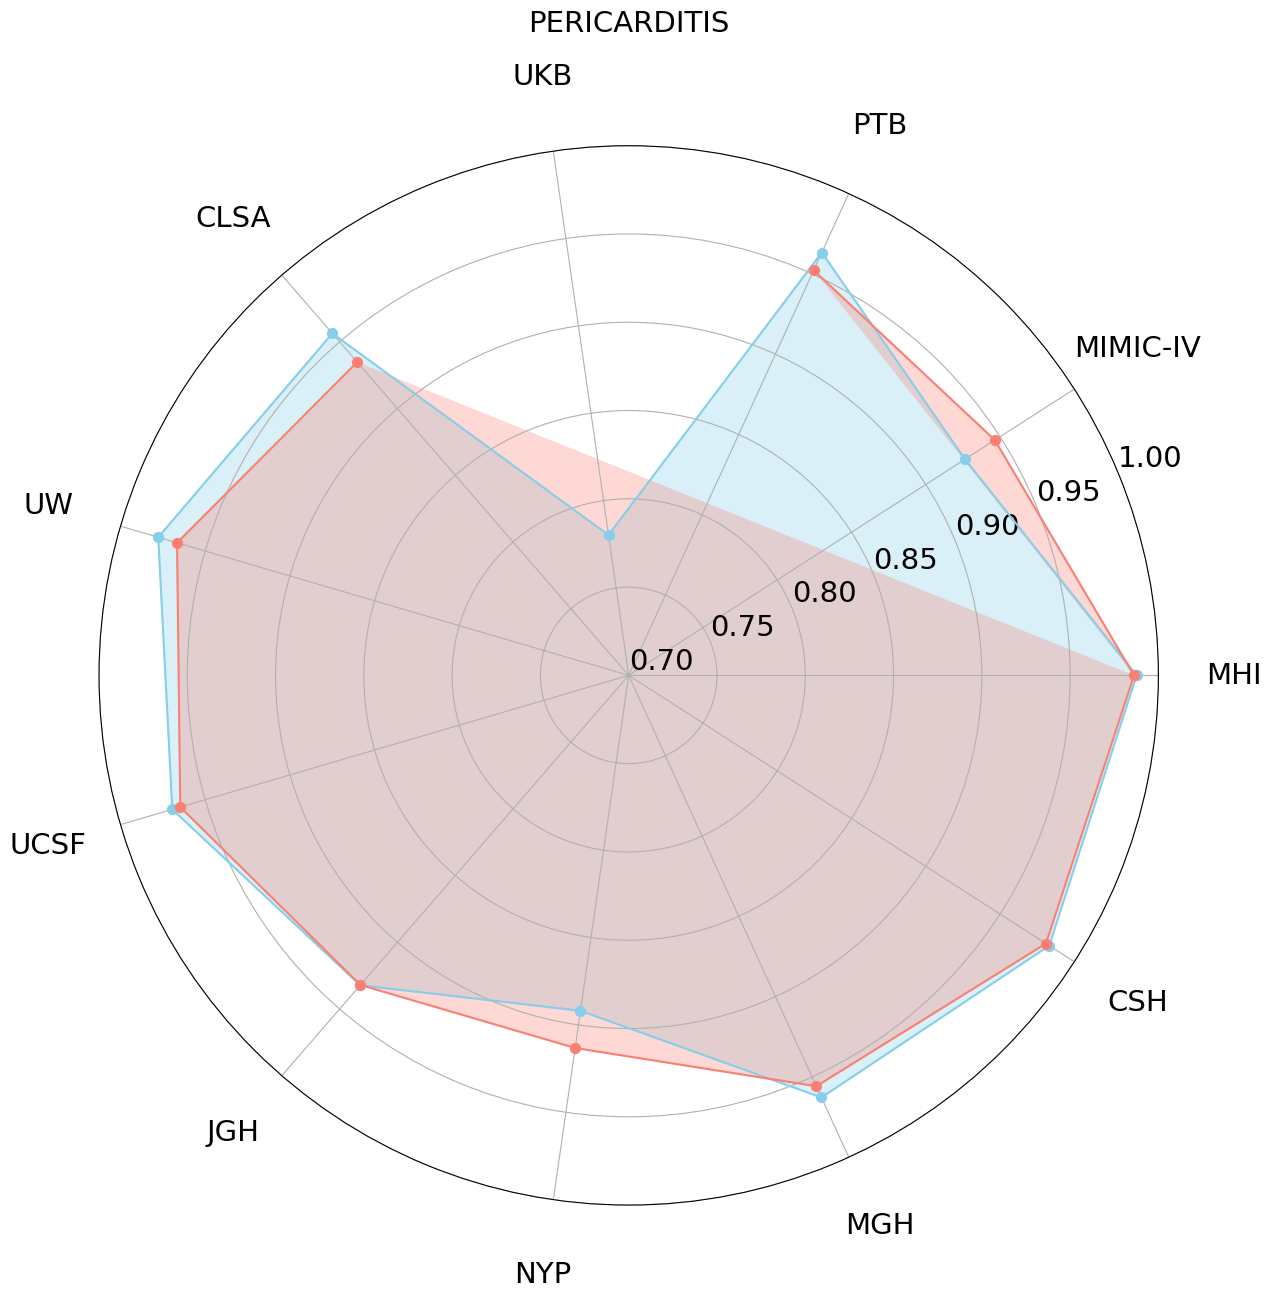

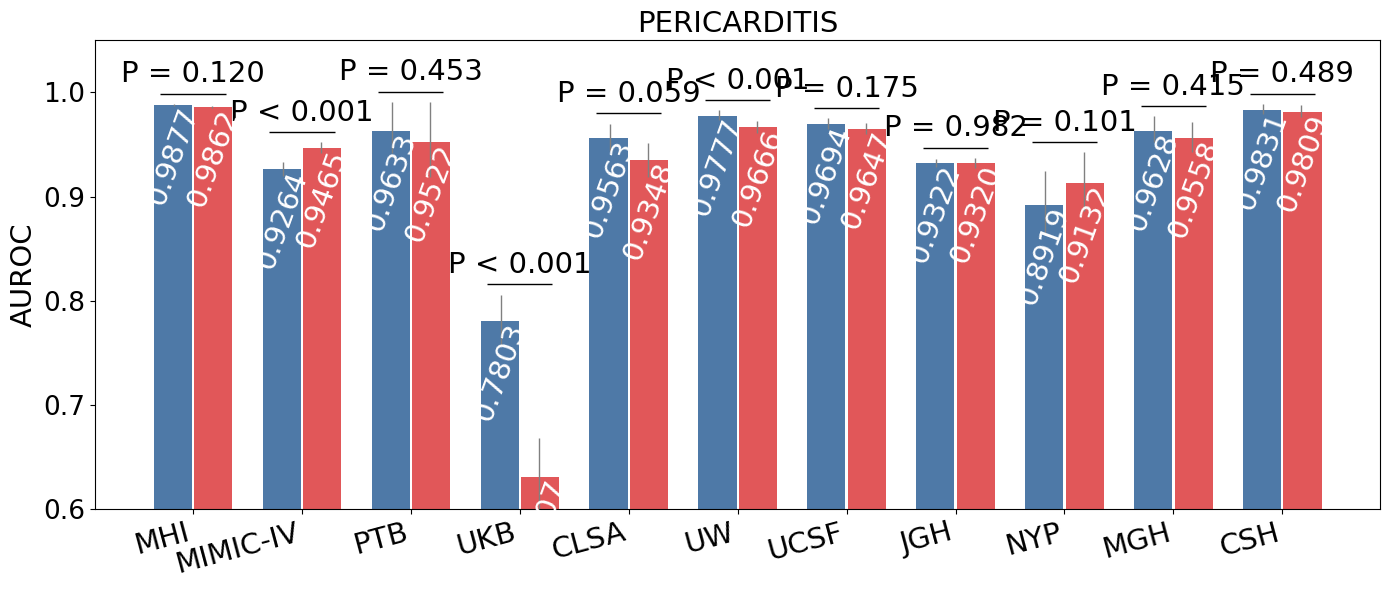

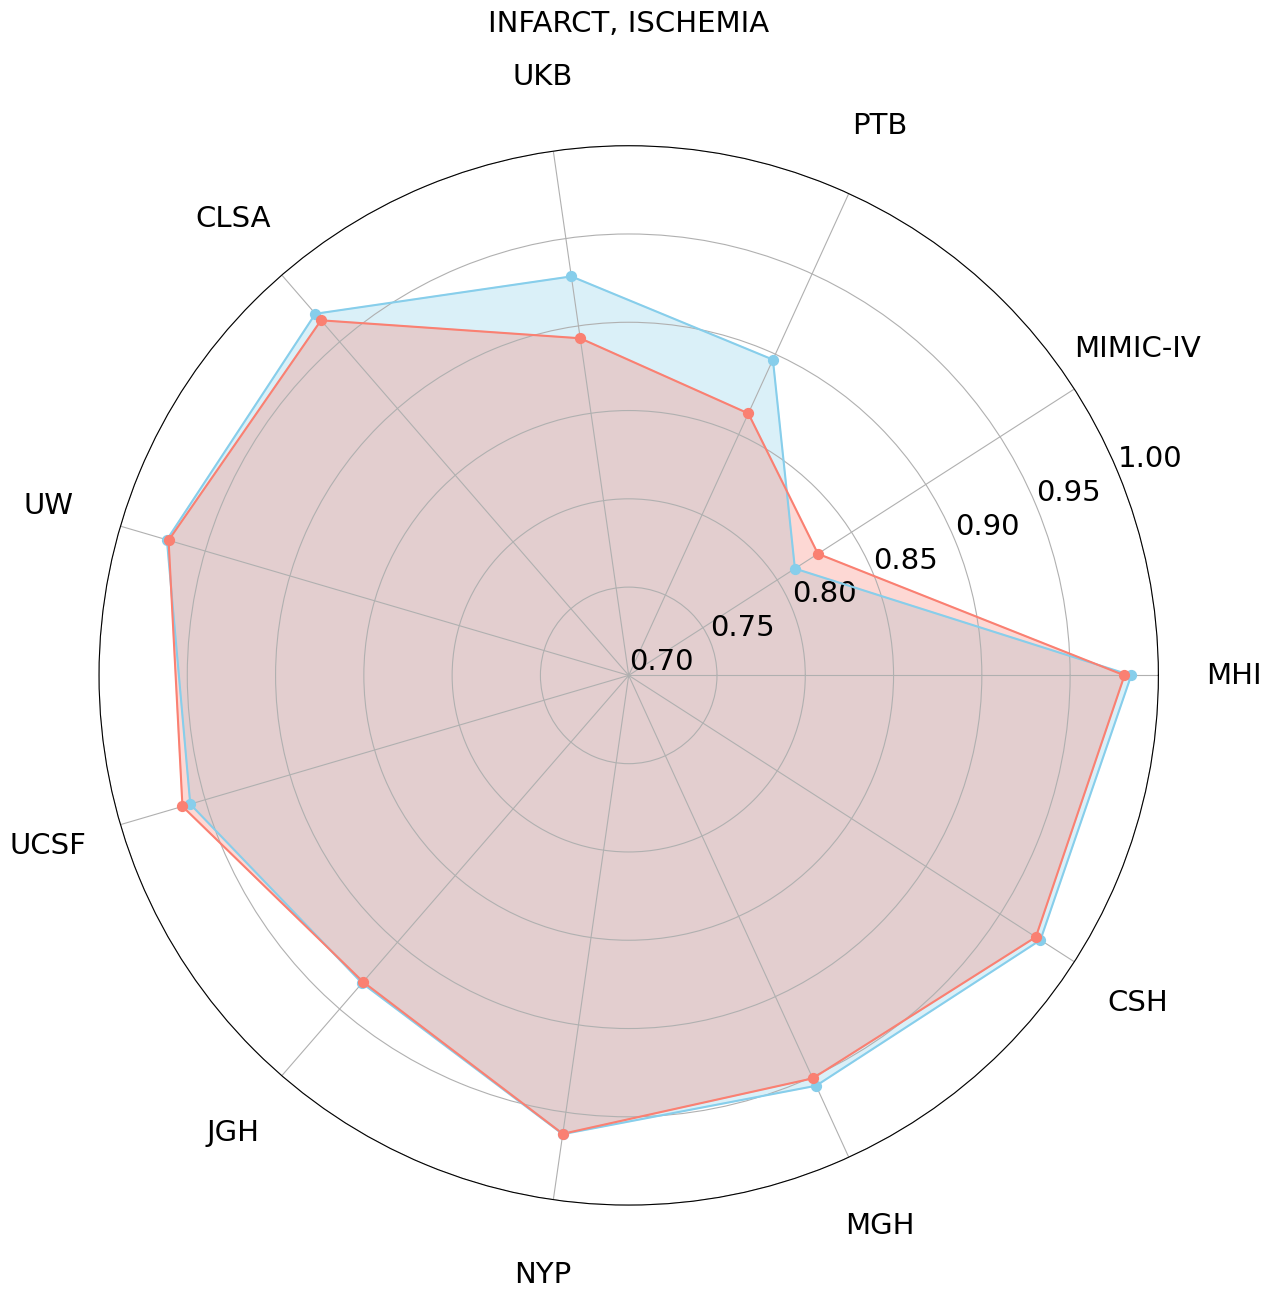

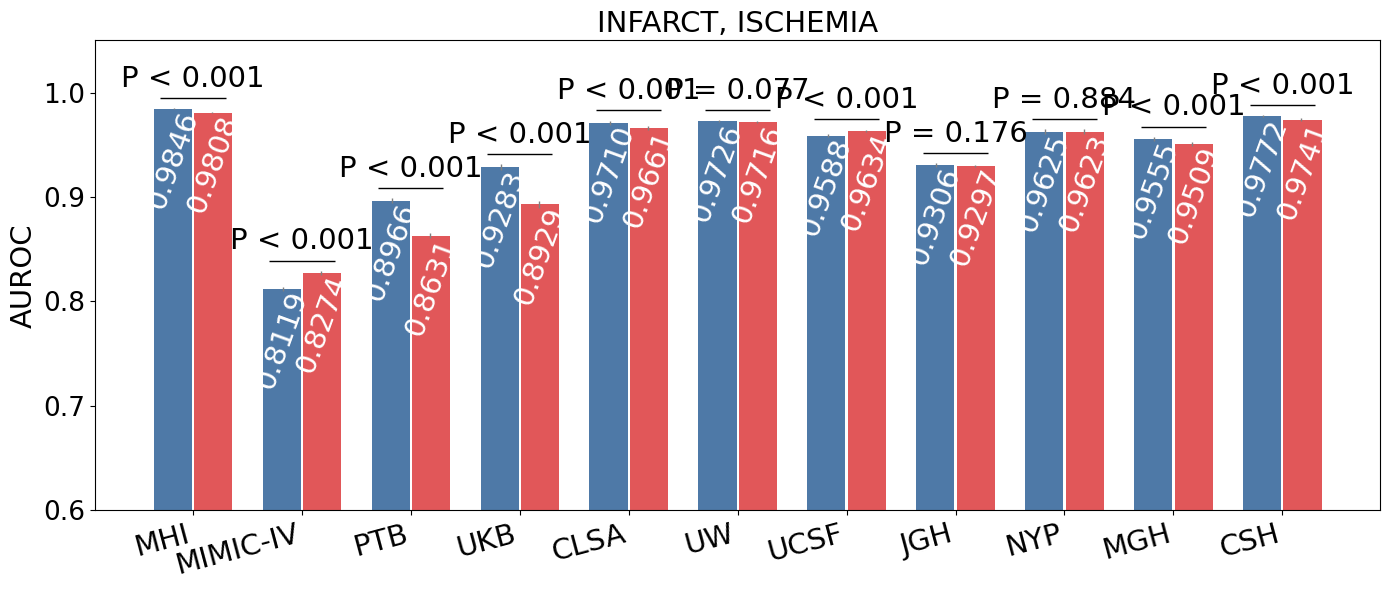

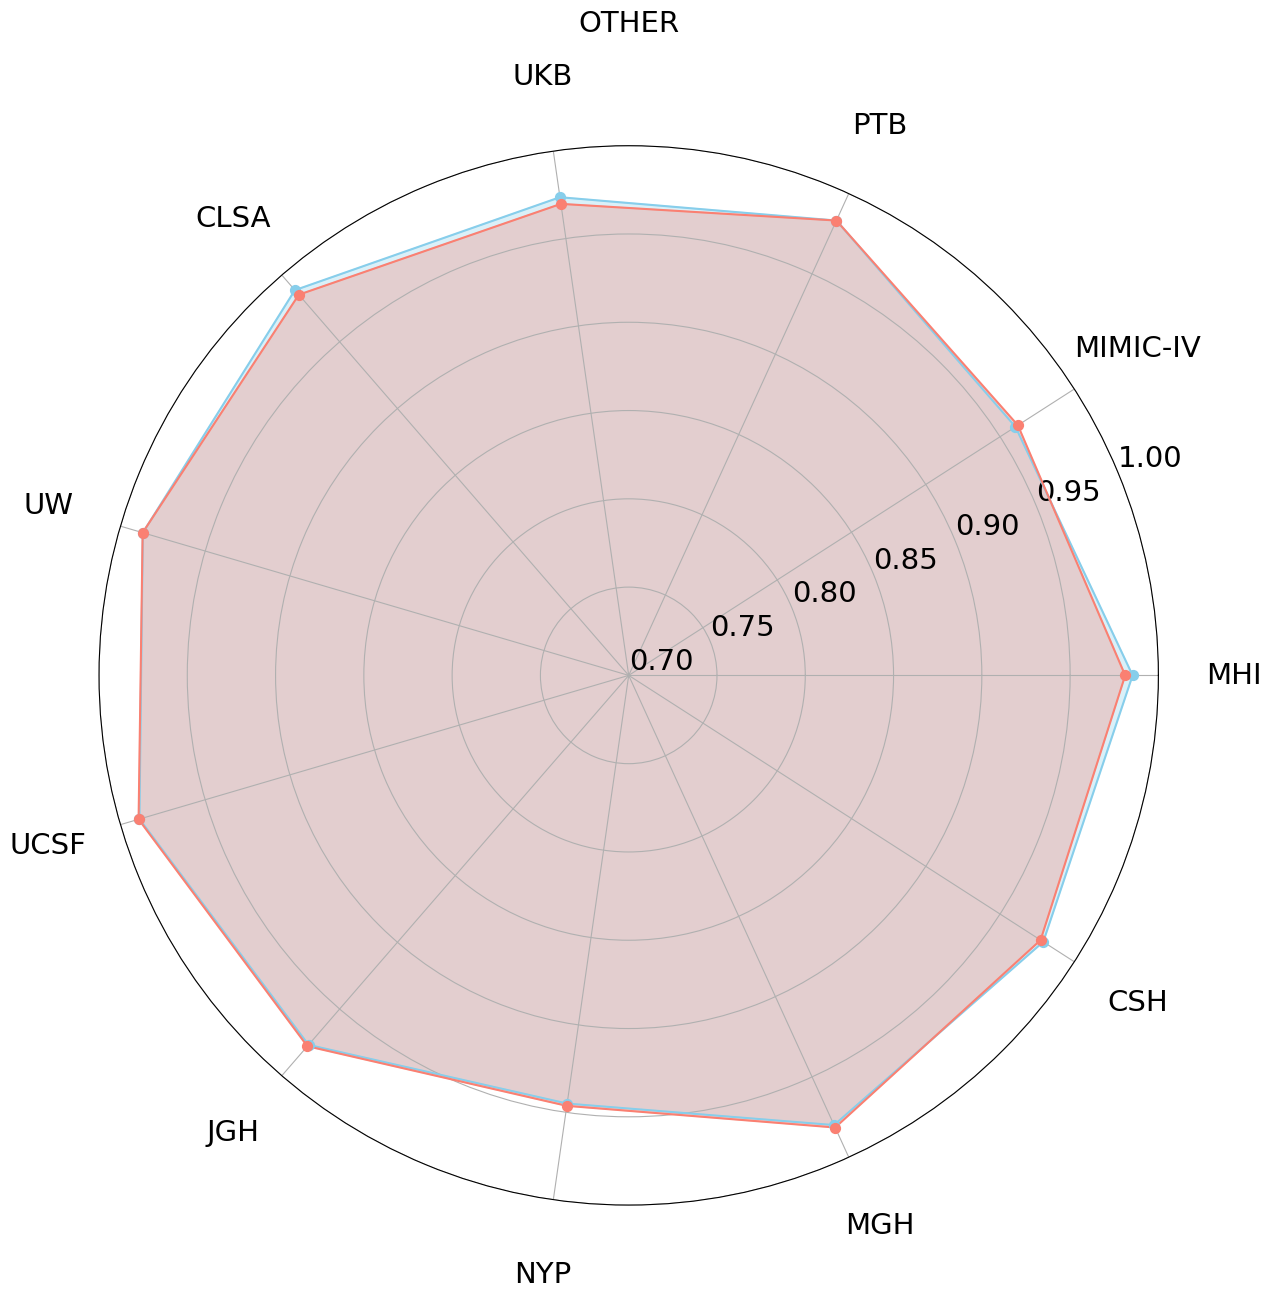

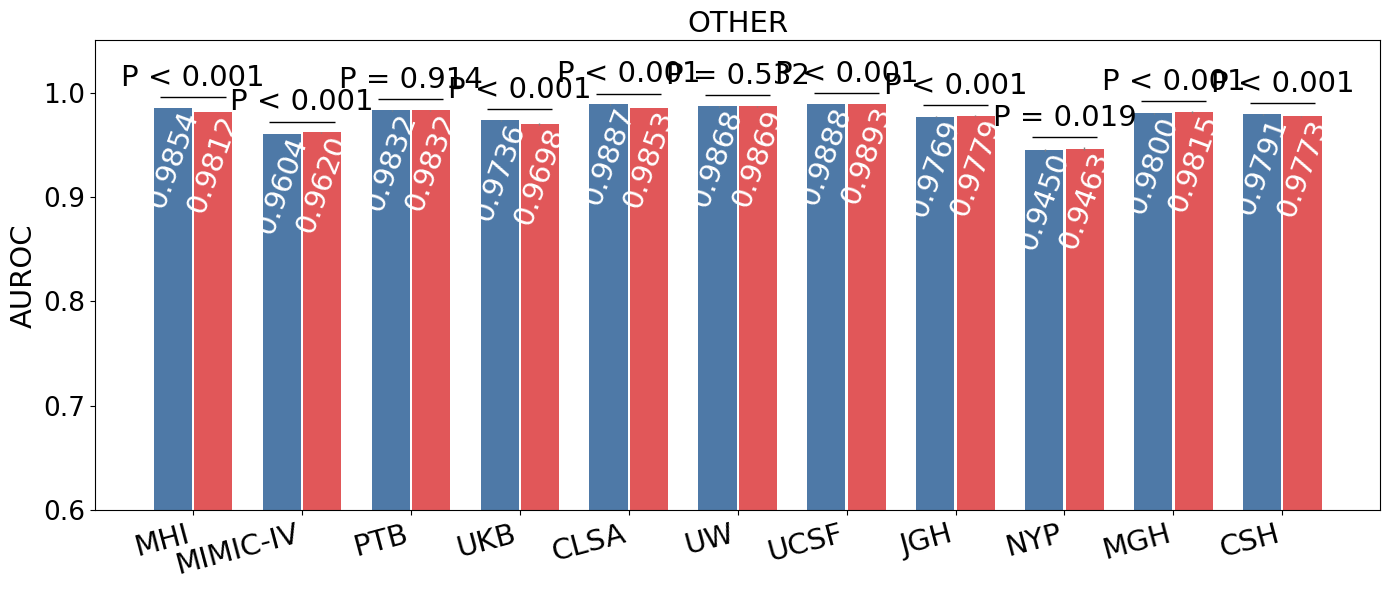

In [3]:
import matplotlib.pyplot as plt
colors = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2', '#59A14F']
#colors = ['#6C757D', '#ADB5BD', '#CED4DA', '#DEE2E6', '#E9ECEF']

COLOR_SL, COLOR_SSL = colors[0], colors[2]

def update_dict(sl, ssl, subset, task_key, idx, metric, add_p_value=True):
    fdf_sl = get_formated_scores('sl', subset, task_key)
    fdf_ssl = get_formated_scores('ssl', subset, task_key)
    idx = f'{idx}_{metric}'
    sl['key'] += [f'{subset}_{idx}']
    ssl['key'] += [f'{subset}_{idx}']
    sl['Mean'] += [round(fdf_sl.loc[idx, 'Mean']/100, 4)]
    ssl['Mean'] += [round(fdf_ssl.loc[idx, 'Mean']/100, 4)]
    sl['95% CI'] += [str([round(ci/100, 4) for ci in eval(fdf_sl.loc[idx, '95% CI'].replace('-', ','))]).replace(',', '-')]
    ssl['95% CI'] += [str([round(ci/100, 4) for ci in eval(fdf_ssl.loc[idx, '95% CI'].replace('-', ','))]).replace(',', '-')]
    if add_p_value:
        ssl['p_value'] += [fdf_ssl.loc[idx, 'p_value']]

def to_df(df_dict, categories):
    for key in categories.keys():
        if not key in df_dict['key']:
            df_dict['key'] += [key]
            df_dict['Mean'] += [0]
            df_dict['95% CI'] += [0]
    df = pd.DataFrame(df_dict)
    df.index = df['key']
    return df
    

def plot_histo(models, categories, title, filename, fontsize=16, y_start=50, y_end=100, hide_last_y=False, show_p_value=False, metric='auroc'):
    # Sample data
    # Sample data
    def get_fig_width():
        len_cat = len(categories)
        return len_cat + 3
    # Set up bar positions
    x = np.arange(len(categories))
    width = 0.35  # Width of the bars

    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(get_fig_width(), 6))

    # Plot bars without error caps using seaborn for improved aesthetics
    # The radar chart needs the data to be a closed loop, so append the start to the end.
    for model in models:          
        scores = model['df'].loc[list(categories.keys()), 'Mean'].tolist()
        cis = model['df'].loc[list(categories.keys()), '95% CI'].tolist()
        model['scores'] = scores
        model['cis'] = [eval(ci.replace('-', ',')) for ci in cis]
        if show_p_value:
            if 'p_value' in model['df'].columns:
                model['p_values'] = model['df'].loc[list(categories.keys()), 'p_value'].tolist()

    # Plot each model’s data on the radar chart
    gap = 0.01
    m1, m2 = models[0], models[1]
    bars_m1 = ax.bar(x - width/2 - gap, m1['scores'], width, label=m1['title'], color=m1['color'])
    bars_m2 = ax.bar(x + width/2 + gap, m2['scores'], width, label=m2['title'], color=m2['color'])

    # Add thin vertical lines for CI
    for i in range(len(categories)):
        ax.vlines(x[i] - width/2, m1['cis'][i][0], m1['cis'][i][1], color='gray', linewidth=1)
        ax.vlines(x[i] + width/2, m2['cis'][i][0], m2['cis'][i][1], color='gray', linewidth=1)
        
        # Calculate and add delta (difference) text
        delta = round(m2['scores'][i] - m1['scores'][i], 2)
        y_position = max(m1['cis'][i][1], m2['cis'][i][1]) + 0.5/100  # Position above bars
        if show_p_value:
            p_val_text = "P < 0.001" if m2['p_values'][i] < 0.001 else f"P = {m2['p_values'][i]:.3f}"
            ax.hlines(y_position+0.5/100, i - width + gap*5 , i + width - gap*5, color='black', linewidth=1)
            ax.text(x[i], y_position+1./100, p_val_text, ha='center', va='bottom', fontsize=fontsize, color='black')
        else:
            ax.text(x[i], y_position, f'Δ={delta}', ha='center', va='bottom', fontsize=fontsize, color='black')

    # Add values inside the bars
    for bar in bars_m1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height - 10/100, f'{height:.4f}', ha='center', va='bottom', color='white', rotation=70, fontsize=fontsize - 6*0)

    for bar in bars_m2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height - 10/100, f'{height:.4f}', ha='center', va='bottom', color='white', rotation=70, fontsize=fontsize - 6*0)

    # Labeling and aesthetics
    #ax.set_xlabel('Categories')
    ax.set_ylabel(metric.upper(), fontsize=fontsize)
    ax.set_title(title, fontsize=fontsize)
    ax.set_xticks(x)
    ax.set_xticklabels(categories.values(), rotation=15, ha='right', fontsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize-2)
    #ax.legend(loc='upper left')

    # Show plot
    plt.ylim(y_start, y_end)
    if hide_last_y:
        ax.yaxis.get_major_ticks()[-1].draw = lambda *args:None
    plt.tight_layout()
    #plt.savefig(f"/volume/deepecg/fairseq-signals/metrics/images/{filename}.png", format="png", dpi=300)  # Save as a high-quality PNG file
    
    plt.show()



def plot_digital_biomarker_ds(title, group, metric='auroc', fontsize=15):
    sl = {'key': [], 'Mean': [], '95% CI': []}
    ssl = {'key': [], 'Mean': [], '95% CI': [], 'p_value': []}

    tasks = getSingletonDataset(group).tasks
    categories = {}
    for task in tasks:
        if task == 'lvef_40':
            update_dict(sl, ssl, group, task_key=task, idx='LVEF_EQUAL_OR_UNDER_40_tte_lvef', metric=metric)
            categories[f'{group}_LVEF_EQUAL_OR_UNDER_40_tte_lvef_{metric}'] = 'LVEF ≤ 40'
        elif task == 'lvef_50':
            update_dict(sl, ssl, group, task_key=task, idx='LVEF_UNDER_50_tte_lvef', metric=metric)
            categories[f'{group}_LVEF_UNDER_50_tte_lvef_{metric}'] ='LVEF < 50'
        elif task == 'afib_5':
            update_dict(sl, ssl, group, task_key=task, idx='label_5y', metric=metric)
            categories[f'{group}_label_5y_{metric}'] ='iAF5' 
        elif task == 'lqts':
            update_dict(sl, ssl, group, task_key=task, idx='LQTS', metric=metric)
            categories[f'{group}_LQTS_{metric}'] = 'LQTS'
        elif task == 'lqts_type':
            update_dict(sl, ssl, group, task_key=task, idx='LQTS_TYPE_1', metric=metric)
            categories[f'{group}_LQTS_TYPE_1_{metric}'] = 'LQTS Type'

    sl = to_df(sl, categories)
    ssl = to_df(ssl, categories)
    
    models = [
        {'title': 'DeepECG-SL', 'df': sl, 'color': COLOR_SL},
        {'title': 'DeepECG-SSL', 'df': ssl, 'color': COLOR_SSL},
    ]
    plot_histo(models, categories, title, f'spider-digital-biomarkers-{group}-{metric}', y_start=.60, y_end=1.0, show_p_value=True, fontsize=fontsize)



def plot_ecg_interpretation_ds(title, group, metric='auroc', fontsize=15):
    sl = {'key': [], 'Mean': [], '95% CI': []}
    ssl = {'key': [], 'Mean': [], '95% CI': [], 'p_value': []}

    for cat in ['RHYTHM', 'CONDUCTION', 'CHAMBER ENLARGEMENT', 'PERICARDITIS', 'INFARCT, ISCHEMIA', 'OTHER', 'ALL']:
        update_dict(sl, ssl, group, task_key='labels_77', idx=f'{cat}_micro', metric=metric)
    categories = {
        f'{group}_ALL_micro_{metric}': 'GLOBAL', 
        f'{group}_RHYTHM_micro_{metric}': 'RHYTHM', 
        f'{group}_CONDUCTION_micro_{metric}': 'CONDUCTION', 
        f'{group}_CHAMBER ENLARGEMENT_micro_{metric}': 'CHAMBER ENLARGEMENT', 
        f'{group}_PERICARDITIS_micro_{metric}': 'PERICARDITIS', 
        f'{group}_INFARCT, ISCHEMIA_micro_{metric}': 'INFARCT, ISCHEMIA', 
        f'{group}_OTHER_micro_{metric}': 'OTHER', 
    }

    sl = to_df(sl, categories)
    ssl = to_df(ssl, categories)
    
    models = [
        {'title': 'DeepECG-SL', 'df': sl, 'color': COLOR_SL},
        {'title': 'DeepECG-SSL', 'df': ssl, 'color': COLOR_SSL},
    ]
    #plot_spider(models, categories, title, f'spider-ecg-interpretation-{group}-{metric}', y_start=70)
    plot_histo(models, categories, title, f'histo-ecg-interpretation-{group}-{metric}', show_p_value=True, y_start=.60, y_end=1.05, fontsize=fontsize)


def plot_ecg_interpretation_cat(title, cat, metric='micro_auroc', groups=DATASETS, fontsize=15):
    sl = {'key': [], 'Mean': [], '95% CI': []}
    ssl = {'key': [], 'Mean': [], '95% CI': [], 'p_value': []}

    #for cat in ['RHYTHM', 'CONDUCTION', 'CHAMBER ENLARGEMENT', 'PERICARDITIS', 'INFARCT, ISCHEMIA', 'OTHER', 'ALL']:
    categories = {}
    for group in groups:
        ds = getSingletonDataset(group)
        update_dict(sl, ssl, group, task_key='labels_77', idx=cat, metric=metric)
        categories[f'{group}_{cat}_{metric}'] = ds.title
    
    sl = to_df(sl, categories)
    ssl = to_df(ssl, categories)
    
    models = [
        {'title': 'DeepECG-SL', 'df': sl, 'color': 'skyblue'},
        {'title': 'DeepECG-SSL', 'df': ssl, 'color': 'salmon'},
    ]
    plot_spider(models, categories, title, f'spider-ecg-interpretation-{group}-{metric}', y_start=.70, y_end=1.0, fontsize=fontsize)

    models = [
        {'title': 'DeepECG-SL', 'df': sl, 'color': COLOR_SL},
        {'title': 'DeepECG-SSL', 'df': ssl, 'color': COLOR_SSL},
    ]
    plot_histo(models, categories, title, f'histo-ecg-interpretation-{cat}-{metric}', show_p_value=True, y_start=.60, y_end=1.05, hide_last_y=True, fontsize=fontsize)

    
datasets = DATASETS
# datasets = ['mimic']
for ds_key in datasets:
    # break
    getSingletonDataset('mimic').title = 'MIMIC-IV'
    ds = getSingletonDataset(ds_key)
    plot_ecg_interpretation_ds(f'ECG interpretation, {ds.title}', ds.key, fontsize=20)
    if len(ds.tasks) == 1:
        continue
    plot_digital_biomarker_ds(f'{ds.title}', ds.key, fontsize=21)
    continue
#ds = getSingletonDataset('mhi')
#plot_digital_biomarker_ds(f'Digital biomarkers, in {ds.title}', ds.key)
#plot_ecg_interpretation_ds(f'ECG interpretation, {ds.title}', ds.key)
#plot_digital_biomarker_ds(f'Digital biomarkers, MIMIC-IV (EPD)', 'mimic')
  
categories = {'ALL': 'OVERALL', 'RHYTHM': 'RHYTHM','CONDUCTION': 'CONDUCTION', 'CHAMBER ENLARGEMENT': 'CHAMBER ENLARGEMENT', 
            'PERICARDITIS': 'PERICARDITIS', 'INFARCT, ISCHEMIA': 'INFARCT, ISCHEMIA', 'OTHER': 'OTHER', }
labels = {'Ventricular tachycardia': 'Ventricular Tachycardia',  'Supraventricular tachycardia': 'Supraventricular Tachycardia', 
          'Afib': 'Atrial Fibrillation', 'Atrial flutter': 'Atrial Flutter', '2nd degree AV block - mobitz 1': '2nd degree AV block - Type 1', 
          '2nd degree AV block - mobitz 2': '2nd degree AV block - Type 2', 'Third Degree AV Block': '3rd degree AV block', 
          'Acute pericarditis': 'Pericarditis', 'Acute MI': 'Acute MI', 'Junctional rhythm': 'Junctional Rhythm',
          'Wolff-Parkinson-White (Pre-excitation syndrome)': 'Wolff-Parkinson-White', 'Premature ventricular complex': 'Premature ventricular complex',
          'Left ventricular hypertrophy': 'Left ventricular hypertrophy', 'Right ventricular hypertrophy': 'Right ventricular hypertrophy'}
for label, title in labels.items():
    # break
    getSingletonDataset('mhi').title = 'MHI'
    datasets = ['mhi', 'external_public', 'external_private']
    plot_ecg_interpretation_cat(f'{title}', label, metric='auroc', groups=datasets, fontsize=22)

datasets = ['mhi', 'mimic', 'ptb', 'ukb', 'clsa', 'uw', 'ucsf', 'jgh', 'nyp', 'hms', 'cshs']
plot_ecg_interpretation_cat(f'ECG Interpretation, Overall AUROC', 'ALL', groups=datasets, fontsize=30)

for cat, title in categories.items():    
    # break
    # continue
    getSingletonDataset('mhi').title = 'MHI'
    getSingletonDataset('external').title = 'EVD'
    
    datasets = ['mhi', 'mimic', 'ptb', 'ukb', 'clsa', 'uw', 'ucsf', 'jgh', 'nyp', 'hms', 'cshs']
    # datasets = ['mhi', 'external_public', 'external_private']
    plot_ecg_interpretation_cat(f'{title}', cat, groups=datasets, fontsize=21)
    

In [ ]:
import matplotlib.pyplot as plt
colors = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2', '#59A14F']
#colors = ['#6C757D', '#ADB5BD', '#CED4DA', '#DEE2E6', '#E9ECEF']

COLOR_SL, COLOR_SSL = colors[0], colors[2]

def update_dict(sl, ssl, subset, task_key, idx, metric, add_p_value=True):
    fdf_sl = get_formated_scores('sl', subset, task_key)
    fdf_ssl = get_formated_scores('ssl', subset, task_key)
    idx = f'{idx}_{metric}'
    sl['key'] += [f'{subset}_{idx}']
    ssl['key'] += [f'{subset}_{idx}']
    sl['Mean'] += [fdf_sl.loc[idx, 'Mean']]
    ssl['Mean'] += [fdf_ssl.loc[idx, 'Mean']]
    sl['95% CI'] += [fdf_sl.loc[idx, '95% CI']]
    ssl['95% CI'] += [fdf_ssl.loc[idx, '95% CI']]
    if add_p_value:
        ssl['p_value'] += [fdf_ssl.loc[idx, 'p_value']]

def to_df(df_dict, categories):
    for key in categories.keys():
        if not key in df_dict['key']:
            df_dict['key'] += [key]
            df_dict['Mean'] += [0]
            df_dict['95% CI'] += [0]
    df = pd.DataFrame(df_dict)
    df.index = df['key']
    return df
    


def plot_digital_biomarker_ds(title, group, metric='auroc', fontsize=15):
    sl = {'key': [], 'Mean': [], '95% CI': []}
    ssl = {'key': [], 'Mean': [], '95% CI': [], 'p_value': []}

    tasks = getSingletonDataset(group).tasks
    categories = {}
    for task in tasks:
        if task == 'lvef_40':
            update_dict(sl, ssl, group, task_key=task, idx='LVEF_EQUAL_OR_UNDER_40_tte_lvef', metric=metric)
            categories[f'{group}_LVEF_EQUAL_OR_UNDER_40_tte_lvef_{metric}'] = 'LVEF ≤ 40'
        elif task == 'lvef_50':
            update_dict(sl, ssl, group, task_key=task, idx='LVEF_UNDER_50_tte_lvef', metric=metric)
            categories[f'{group}_LVEF_UNDER_50_tte_lvef_{metric}'] ='LVEF < 50'
        elif task == 'afib_5':
            update_dict(sl, ssl, group, task_key=task, idx='label_5y', metric=metric)
            categories[f'{group}_label_5y_{metric}'] ='iAF5' 
        elif task == 'lqts':
            update_dict(sl, ssl, group, task_key=task, idx='LQTS', metric=metric)
            categories[f'{group}_LQTS_{metric}'] = 'LQTS'
        elif task == 'lqts_type':
            update_dict(sl, ssl, group, task_key=task, idx='LQTS_TYPE_1', metric=metric)
            categories[f'{group}_LQTS_TYPE_1_{metric}'] = 'LQTS Type'

    sl = to_df(sl, categories)
    ssl = to_df(ssl, categories)
    
    models = [
        {'title': 'DeepECG-SL', 'df': sl, 'color': COLOR_SL},
        {'title': 'DeepECG-SSL', 'df': ssl, 'color': COLOR_SSL},
    ]
    plot_histo(models, categories, title, f'spider-digital-biomarkers-{group}-{metric}', y_start=.60, show_p_value=True, fontsize=fontsize)



def plot_ecg_interpretation_ds(title, group, metric='auroc', fontsize=15):
    sl = {'key': [], 'Mean': [], '95% CI': []}
    ssl = {'key': [], 'Mean': [], '95% CI': [], 'p_value': []}

    for cat in ['RHYTHM', 'CONDUCTION', 'CHAMBER ENLARGEMENT', 'PERICARDITIS', 'INFARCT, ISCHEMIA', 'OTHER', 'ALL']:
        update_dict(sl, ssl, group, task_key='labels_77', idx=f'{cat}_micro', metric=metric)
    categories = {
        f'{group}_ALL_micro_{metric}': 'OVERALL', 
        f'{group}_RHYTHM_micro_{metric}': 'RHYTHM', 
        f'{group}_CONDUCTION_micro_{metric}': 'CONDUCTION', 
        f'{group}_CHAMBER ENLARGEMENT_micro_{metric}': 'CHAMBER ENLARGEMENT', 
        f'{group}_PERICARDITIS_micro_{metric}': 'PERICARDITIS', 
        f'{group}_INFARCT, ISCHEMIA_micro_{metric}': 'INFARCT, ISCHEMIA', 
        f'{group}_OTHER_micro_{metric}': 'OTHER', 
    }

    sl = to_df(sl, categories)
    ssl = to_df(ssl, categories)
    
    models = [
        {'title': 'DeepECG-SL', 'df': sl, 'color': COLOR_SL},
        {'title': 'DeepECG-SSL', 'df': ssl, 'color': COLOR_SSL},
    ]
    #plot_spider(models, categories, title, f'spider-ecg-interpretation-{group}-{metric}', y_start=70)
    plot_histo(models, categories, title, f'histo-ecg-interpretation-{group}-{metric}', show_p_value=True, y_start=.60, y_end=1.05, fontsize=fontsize)


def plot_ecg_interpretation_cat(title, cat, metric='micro_auroc', groups=DATASETS, fontsize=15):
    sl = {'key': [], 'Mean': [], '95% CI': []}
    ssl = {'key': [], 'Mean': [], '95% CI': [], 'p_value': []}

    #for cat in ['RHYTHM', 'CONDUCTION', 'CHAMBER ENLARGEMENT', 'PERICARDITIS', 'INFARCT, ISCHEMIA', 'OTHER', 'ALL']:
    categories = {}
    for group in groups:
        ds = getSingletonDataset(group)
        update_dict(sl, ssl, group, task_key='labels_77', idx=cat, metric=metric)
        categories[f'{group}_{cat}_{metric}'] = ds.title
    
    sl = to_df(sl, categories)
    ssl = to_df(ssl, categories)
    print(ssl)
    models = [
        {'title': 'DeepECG-SL', 'df': sl, 'color': COLOR_SL},
        {'title': 'DeepECG-SSL', 'df': ssl, 'color': COLOR_SSL},
    ]
    #plot_spider(models, categories, title, f'spider-ecg-interpretation-{group}-{metric}', y_start=70)
    plot_histo(models, categories, title, f'histo-ecg-interpretation-{cat}-{metric}', show_p_value=True, y_start=60, y_end=105, hide_last_y=True, fontsize=fontsize)

# def plot_ecg_interpretation_label(title, label, metric='auroc', fontsize=15):
    
datasets = DATASETS
# datasets = ['mhi', 'external', 'external_public', 'external_private']
# datasets = ['mimic']
for ds_key in datasets:
    # continue
    
    getSingletonDataset('mimic').title = 'MIMIC-IV'
    ds = getSingletonDataset(ds_key)
    plot_ecg_interpretation_ds(f'ECG interpretation, {ds.title}', ds.key, fontsize=18)
    break
    if len(ds.tasks) == 1:
        continue
    plot_digital_biomarker_ds(f'{ds.title}', ds.key, fontsize=20)
    continue
#ds = getSingletonDataset('mhi')
#plot_digital_biomarker_ds(f'Digital biomarkers, in {ds.title}', ds.key)
#plot_ecg_interpretation_ds(f'ECG interpretation, {ds.title}', ds.key)
#plot_digital_biomarker_ds(f'Digital biomarkers, MIMIC-IV (EPD)', 'mimic')
  
categories = {'ALL': 'OVERALL', 'RHYTHM': 'RHYTHM','CONDUCTION': 'CONDUCTION', 'CHAMBER ENLARGEMENT': 'CHAMBER ENLARGEMENT', 
            'PERICARDITIS': 'PERICARDITIS', 'INFARCT, ISCHEMIA': 'INFARCT, ISCHEMIA', 'OTHER': 'OTHER', }
labels = {'Ventricular tachycardia': 'Ventricular Tachycardia',  'Supraventricular tachycardia': 'Supraventricular Tachycardia', 
          'Afib': 'Atrial Fibrillation', 'Atrial flutter': 'Atrial Flutter', '2nd degree AV block - mobitz 1': '2nd degree AV block - Type 1', 
          '2nd degree AV block - mobitz 2': '2nd degree AV block - Type 2', 'Third Degree AV Block': '3rd degree AV block', 
          'Acute pericarditis': 'Pericarditis', 'Acute MI': 'Acute MI', 'Junctional rhythm': 'Junctional Rhythm',
          'Wolff-Parkinson-White (Pre-excitation syndrome)': 'Wolff-Parkinson-White', 'Premature ventricular complex': 'Premature ventricular complex',
          'Left ventricular hypertrophy': 'Left ventricular hypertrophy', 'Right ventricular hypertrophy': 'Right ventricular hypertrophy' }
for label, title in labels.items():
    break
    getSingletonDataset('mhi').title = 'MHI'
    datasets = ['mhi', 'external_public', 'external_private']
    plot_ecg_interpretation_cat(f'{title}', label, metric='auroc', groups=datasets, fontsize=22)
    
for cat, title in categories.items():    
    plot_ecg_interpretation_cat(f'{title}', cat, groups=DATASETS, fontsize=17)
    break
    # continue
    getSingletonDataset('mhi').title = 'MHI'
    getSingletonDataset('external').title = 'EVD'
    
    datasets = ['mhi', 'mimic', 'ptb', 'ukb', 'clsa', 'uw', 'ucsf', 'jgh', 'nyp', 'hms', 'cshs']
    # datasets = ['mhi', 'external_public', 'external_private']
    plot_ecg_interpretation_cat(f'{title}', cat, groups=datasets, fontsize=16)
    
    

In [8]:
list_clean_labels =  ['Acute pericarditis', 'QS complex in V1-V2-V3', 'T wave inversion (anterior - V3-V4)', 'Right atrial enlargement','2nd degree AV block - mobitz 1','Left posterior fascicular block','Wolff-Parkinson-White (Pre-excitation syndrome)','Junctional rhythm','Premature ventricular complex',"rSR' in V1-V2",'Right superior axis','ST elevation (inferior - II, III, aVF)','Afib','ST elevation (anterior - V3-V4)','RV1 + SV6 > 11 mm','Sinusal','Monomorph','Delta wave','R/S ratio in V1-V2 >1','Third Degree AV Block','LV pacing','Nonspecific intraventricular conduction delay','ST depression (inferior - II, III, aVF)','Regular','Premature atrial complex','2nd degree AV block - mobitz 2','Left anterior fascicular block','Q wave (septal- V1-V2)','Prolonged QT','Left axis deviation','Left ventricular hypertrophy','ST depression (septal- V1-V2)','Supraventricular tachycardia','Atrial paced','Q wave (inferior - II, III, aVF)','no_qrs','T wave inversion (lateral -I, aVL, V5-V6)','Right bundle branch block','ST elevation (septal - V1-V2)','SV1 + RV5 or RV6 > 35 mm','Right axis deviation','RaVL > 11 mm','Polymorph','Ventricular tachycardia','QRS complex negative in III','ST depression (lateral - I, avL, V5-V6)','1st degree AV block','Lead misplacement','Q wave (posterior - V7-V9)','Atrial flutter','Ventricular paced','ST elevation (posterior - V7-V8-V9)','Ectopic atrial rhythm (< 100 BPM)','Early repolarization','Ventricular Rhythm','Irregularly irregular','Atrial tachycardia (>= 100 BPM)','R complex in V5-V6','ST elevation (lateral - I, aVL, V5-V6)','Brugada','Bi-atrial enlargement','Q wave (lateral- I, aVL, V5-V6)','ST upslopping','T wave inversion (inferior - II, III, aVF)','Regularly irregular','Bradycardia','qRS in V5-V6-I, aVL','Q wave (anterior - V3-V4)','Acute MI','ST depression (anterior - V3-V4)','Right ventricular hypertrophy','T wave inversion (septal- V1-V2)','ST downslopping','Left bundle branch block','Low voltage','U wave','Left atrial enlargement']


for l in list_clean_labels:
    if 'ventri' in l.lower():
        print(l)

Premature ventricular complex
Nonspecific intraventricular conduction delay
Left ventricular hypertrophy
Supraventricular tachycardia
Ventricular tachycardia
Ventricular paced
Ventricular Rhythm
Right ventricular hypertrophy


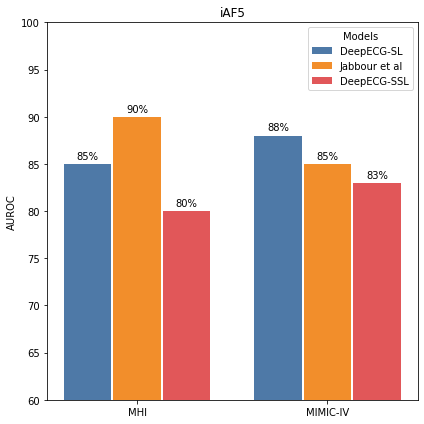

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Data
datasets = ['MHI', 'MIMIC-IV']
models = ['DeepECG-SL', 'Jabbour et al', 'DeepECG-SSL']

# Performance values
performance = {
    'MHI': [85, 90, 80],  # Model A, B, C on Dataset 1
    'MIMIC-IV': [88, 85, 83],  # Model A, B, C on Dataset 2
}

# X-axis positions
x = np.arange(len(datasets))  # Positions for the 2 groups (datasets)
width = 0.25  # Width of each bar

# Colors
colors = ['#4E79A7', '#F28E2B', '#E15759']  # Colors for each model

# Plot
fig, ax = plt.subplots(figsize=(6, 6))

# Plot bars for each model
bars = []
for i, model in enumerate(models):
    gap = (i-1)*0.01
    bars.append(ax.bar(x + i * width - width + gap, 
                       [performance[dataset][i] for dataset in datasets], 
                       width, label=model, color=colors[i]))

# Add labels and titles
ax.set_ylabel('AUROC')
#ax.set_xlabel('Datasets')
ax.set_title('iAF5')
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.legend(title='Models')

# Add value labels on top of bars
def add_labels(bars):
    for bar_group in bars:
        for bar in bar_group:
            height = bar.get_height()
            ax.annotate(f'{height}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # Offset text by 3 points
                        textcoords="offset points",
                        ha='center', va='bottom')

add_labels(bars)

# Adjust layout
plt.ylim(60, 100)
plt.tight_layout()
plt.show()


In [9]:
def update_dict(sl, ssl, subset, task_key, idx, metric):
    fdf_sl = get_formated_scores('sl', subset, task_key)
    fdf_ssl = get_formated_scores('ssl', subset, task_key)
    idx = f'{idx}_{metric}'
    sl['key'] += [f'{subset}_{idx}']
    ssl['key'] += [f'{subset}_{idx}']
    sl['Mean'] += [fdf_sl.loc[idx, 'Mean']]
    ssl['Mean'] += [fdf_ssl.loc[idx, 'Mean']]
    sl['95% CI'] += [fdf_sl.loc[idx, '95% CI']]
    ssl['95% CI'] += [fdf_ssl.loc[idx, '95% CI']]

def to_df(df_dict, categories):
    for key in categories.keys():
        if not key in df_dict['key']:
            df_dict['key'] += [key]
            df_dict['Mean'] += [0]
            df_dict['95% CI'] += [0]
    df = pd.DataFrame(df_dict)
    df.index = df['key']
    return df
    
def plot_ecg_interpretation_all(title, metric='auroc'):
    sl = {'key': [], 'Mean': [], '95% CI': []}
    ssl = {'key': [], 'Mean': [], '95% CI': []}    
    for subset in ['mhi', 'mimic', 'ptb', 'clsa', 'ukb', 'uw', 'ucsf', 'hms', 'nyp', 'jgh', 'cshs']:
        update_dict(sl, ssl, subset, task_key='labels_77', idx='ALL_micro', metric=metric)
    
    categories = {
        f'mhi_ALL_micro_{metric}': 'MHI', 
        f'mimic_ALL_micro_{metric}': 'MIMIC-IV', 
        f'ptb_ALL_micro_{metric}': 'PTB', 
        f'ukb_ALL_micro_{metric}': 'UKB', 
        f'clsa_ALL_micro_{metric}': 'CLSA', 
        f'uw_ALL_micro_{metric}': 'UW', 
        f'ucsf_ALL_micro_{metric}': 'UCSF', 
        f'hms_ALL_micro_{metric}': 'MGH', 
        f'nyp_ALL_micro_{metric}': 'NYP', 
        f'jgh_ALL_micro_{metric}': 'JGH', 
        f'cshs_ALL_micro_{metric}': 'CSH', 
    }
    sl = to_df(sl, categories)
    ssl = to_df(ssl, categories)
    csl, cssl = COLOR_SSL, COLOR_SL
    csl, cssl = 'skyblue', 'salmon'
    models = [
        {'title': 'DeepECG-SL', 'df': sl, 'color': csl},
        {'title': 'DeepECG-SSL', 'df': ssl, 'color': cssl},
    ]
    
    plot_spider(models, categories, title, f'spider-ecg-interpretation-all-{metric}', y_start=.70, fig_size=8, fontsize=20)
    #plot_histo(models, categories, title, f'histo-ecg-interpretation-all-{metric}', metric)

def plot_ecg_interpretation_ds(title, group, metric='auroc'):
    sl = {'key': [], 'Mean': [], '95% CI': []}
    ssl = {'key': [], 'Mean': [], '95% CI': []}

    for cat in ['RHYTHM', 'CONDUCTION', 'CHAMBER ENLARGEMENT', 'PERICARDITIS', 'INFARCT, ISCHEMIA', 'OTHER', 'ALL']:
        update_dict(sl, ssl, group, task_key='labels_77', idx=f'{cat}_micro', metric=metric)
    categories = {
        f'{group}_RHYTHM_micro_{metric}': 'RHYTHM', 
        f'{group}_CONDUCTION_micro_{metric}': 'CONDUCTION', 
        f'{group}_CHAMBER ENLARGEMENT_micro_{metric}': 'CHAMBER ENLARGEMENT', 
        f'{group}_PERICARDITIS_micro_{metric}': 'PERICARDITIS', 
        f'{group}_INFARCT, ISCHEMIA_micro_{metric}': 'INFARCT, ISCHEMIA', 
        f'{group}_OTHER_micro_{metric}': 'OTHER', 
        #f'{group}_ALL_micro_{metric}': 'TOTAL', 
    }

    sl = to_df(sl, categories)
    ssl = to_df(ssl, categories)
    
    models = [
        {'title': 'DeepECG-SL', 'df': sl, 'color': 'skyblue'},
        {'title': 'DeepECG-SSL', 'df': ssl, 'color': 'salmon'},
    ]
    plot_spider(models, categories, title, f'spider-ecg-interpretation-{group}-{metric}', y_start=70)
    #plot_histo(models, categories, title, f'histo-ecg-interpretation-{group}-{metric}')


def plot_digital_biomarker_ds(title, group, metric='auroc'):
    sl = {'key': [], 'Mean': [], '95% CI': []}
    ssl = {'key': [], 'Mean': [], '95% CI': []}

    tasks = getSingletonDataset(group).tasks
    categories = {}
    for task in tasks:
        if task == 'lvef_40':
            update_dict(sl, ssl, group, task_key=task, idx='LVEF_EQUAL_OR_UNDER_40_tte_lvef', metric=metric)
            categories[f'{group}_LVEF_EQUAL_OR_UNDER_40_tte_lvef_{metric}'] = 'LVEF ≤ 40'
        elif task == 'lvef_50':
            update_dict(sl, ssl, group, task_key=task, idx='LVEF_UNDER_50_tte_lvef', metric=metric)
            categories[f'{group}_LVEF_UNDER_50_tte_lvef_{metric}'] ='LVEF < 50'
        elif task == 'afib_5':
            update_dict(sl, ssl, group, task_key=task, idx='label_5y', metric=metric)
            categories[f'{group}_label_5y_{metric}'] ='iAF5' 
        elif task == 'lqts':
            update_dict(sl, ssl, group, task_key=task, idx='LQTS', metric=metric)
            categories[f'{group}_LQTS_{metric}'] = 'LQTS'
        elif task == 'lqts_type':
            update_dict(sl, ssl, group, task_key=task, idx='LQTS_TYPE_1', metric=metric)
            categories[f'{group}_LQTS_TYPE_1_{metric}'] = 'LQTS Type'

    sl = to_df(sl, categories)
    ssl = to_df(ssl, categories)
    
    models = [
        {'title': 'DeepECG-SL', 'df': sl, 'color': 'skyblue'},
        {'title': 'DeepECG-SSL', 'df': ssl, 'color': 'salmon'},
    ]
    plot_spider(models, categories, title, f'spider-digital-biomarkers-{group}-{metric}', y_start=60)
    #plot_histo(models, categories, title, f'histo-digital-biomarkers-{group}-{metric}', metric)




def sl_ssl_ds_size(tasks, title, start_y=70, fontsize=15, metric='auroc'):
    # Prepare data
    tasks_old = [
    {"name": "LQTS Type", "n_samples": 334, "sl_auroc": 85.04, "ssl_auroc": 93.06},
    {"name": "LQTS", "n_samples": 2741, "sl_auroc": 85.04, "ssl_auroc": 93.72},
    {"name": "LVEF ≤ 40", "n_samples": 89500, "sl_auroc": 93.72, "ssl_auroc": 93.57},
    {"name": "LVEF < 50", "n_samples": 89500, "sl_auroc": 98.53, "ssl_auroc": 93.75},
    {"name": "iAF5", "n_samples": 537742, "sl_auroc": 97.39, "ssl_auroc": 97.2},
    {"name": "ECG 77", "n_samples": 1166896, "sl_auroc": 93.17, "ssl_auroc": 93.96},
    ]
    # start_y=85
    # tasks = tasks_old
    markers = [task["mark"] for task in tasks ] #"o", "s", "^", "^", "D", "x"]  # Circle, square, triangle, diamond
    # markers = ["o", "s", "^", "^", "D", "x"]  # Circle, square, triangle, diamond
    n_samples = [task["n_samples"] for task in tasks]
    sl_auroc = [task["sl_auroc"] for task in tasks]
    ssl_auroc = [task["ssl_auroc"] for task in tasks]
    task_names = [task["name"] for task in tasks]
    colors = ['skyblue', 'salmon']
    colors = ['blue', 'green']
    colors = [COLOR_SL, COLOR_SSL]

    # Plot SL and SSL points with unique markers
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xscale("log")
    ax.set_xlim(min(n_samples) * 0.8, max(n_samples) * 1.2)
    ax.set_ylim(start_y/100, 1)
    fontsize=15

    for i, task in enumerate(tasks):
        ax.plot(task["n_samples"], task["sl_auroc"], markersize=fontsize, marker=markers[i], color=colors[0], label=f"SL ({task['name']})", alpha=0.8, linestyle="None")
        ax.plot(task["n_samples"], task["ssl_auroc"], markersize=fontsize, marker=markers[i], color=colors[1], label=f"SSL ({task['name']})", alpha=0.8, linestyle="None")

    # Connect points for the same model with dotted lines
    ax.plot(n_samples, sl_auroc, linestyle="--", color=colors[0], alpha=0.6, label="SL (Trend)")
    ax.plot(n_samples, ssl_auroc, linestyle="--", color=colors[1], alpha=0.6, label="SSL (Trend)")

    # Add labels for each point
    for i, task in enumerate(tasks):
        ax.text(task["n_samples"], task["sl_auroc"], f"SL ({task['sl_auroc']})", fontsize=fontsize, ha="left", color=colors[0])
        ax.text(task["n_samples"], task["ssl_auroc"], f"SSL ({task['ssl_auroc']})", fontsize=fontsize, ha="right", color=colors[1])


    # Plot SL and SSL points
    #ax.plot(n_samples, sl_auroc, "o--", color="blue", label="SL", alpha=0.8)
    #ax.plot(n_samples, ssl_auroc, "o--", color="green", label="SSL", alpha=0.8)

    # Add labels for each point
    #for i, (x, y) in enumerate(zip(n_samples, sl_auroc)):
    #    ax.text(x, y, f"SL ({task_names[i]})", fontsize=10, ha="right", color="blue")

    #for i, (x, y) in enumerate(zip(n_samples, ssl_auroc)):
    #    ax.text(x, y, f"SSL ({task_names[i]})", fontsize=10, ha="left", color="green")

    # Aesthetics
    ax.set_xlabel("Number of Samples (Log Scale)", fontsize=fontsize+2)
    ax.set_ylabel(metric.upper(), fontsize=fontsize+2)
    ax.set_title(title, fontsize=fontsize+4)
    # ax.legend(fontsize=10, loc="lower left")
    ax.grid(visible=True, linestyle="--", alpha=0.6)

    # Show plot
    plt.tight_layout()
    plt.show()




def line_plot_ds(ds_key: str, metric='auroc', start_y=70):
    task_to_count = {'labels_77': 1166896, 'afib_5': 537742, 'lvef_50': 89500, 'lvef_40': 89500, 'lqts': 2741, 'lqts_type': 334}
    task_to_str = {'labels_77': 'ECG 77', 'afib_5': 'iAF5', 'lvef_50': 'LVEF < 50', 'lvef_40': 'LVEF ≤ 40', 'lqts': 'LQTS', 'lqts_type': 'LQTS Type'}
    task_to_label = {'labels_77': f'ALL_micro_{metric}', 'afib_5': f'label_5y_{metric}', 'lvef_50': f'LVEF_UNDER_50_tte_lvef_{metric}', 'lvef_40': f'LVEF_EQUAL_OR_UNDER_40_tte_lvef_{metric}', 'lqts': f'LQTS_{metric}', 'lqts_type': f'LQTS_TYPE_1_{metric}'}
    task_to_mark = {'labels_77': 'o', 'afib_5': 's', 'lvef_50': 'D', 'lvef_40': '^', 'lqts': 'x', 'lqts_type': '*'}
    tasks = []

    ds = getSingletonDataset(ds_key)
    counts = [(task_key, ds.get_stats(getSingletonTask(task_key, 'sl', ds.key))['$count$']) for task_key in ds.tasks]
    counts = sorted(counts, key=lambda x: x[1])
    for task_key in ds.tasks:
        sl = get_formated_scores('sl', ds.key, task_key)
        ssl = get_formated_scores('ssl', ds.key, task_key)
        key = task_to_label[task_key]
        tasks += [{
            "name": task_to_str[task_key], 
            "n_samples": task_to_count[task_key], 
            "mark": task_to_mark[task_key], 
            "sl_auroc": round(sl.loc[key, 'Mean']/100, 2),
            "ssl_auroc": round(ssl.loc[key, 'Mean']/100, 2)
        },]
    sl_ssl_ds_size(tasks, title=f'{metric.upper()}, {ds.title}', start_y=start_y)


#plot_digital_biomarker_ds('biomarker', 'external_private')
#plot_dataset_spider(title='Model performance on MHI. AUROC', subset='mhi', tasks=['labels_77', 'lvef_50', 'lvef_40', 'afib_5', 'lqts', 'lqts_type'])
#plot_dataset_spider(title='Model performance on MIMIC-IV. AUROC', subset='mimic', tasks=['labels_77', 'lvef_50', 'lvef_40', 'afib_5', ])
#plot_dataset_spider(title='Model performance on EHC datasets. AUROC', subset='ucsf', tasks=['labels_77', 'lvef_50', 'lvef_40', 'afib_5', ])
#plot_ecg_interpretation_main('AUROC on Ecg interpretation accross datasets.', metric='auroc')
#plot_ecg_interpretation_ds_group('AUROC on Ecg interpretation categories\' accross EHC datasets.', group='external_private', metric='auroc')
#plot_ecg_interpretation_ds_group('AUROC on Ecg interpretation categories\' accross EPC datasets.', group='external_public', metric='auroc')
#plot_ecg_interpretation_ds_group('AUROC on Ecg interpretation categories\' accross internal datasets (MHI).', group='mhi', metric='auroc')

#plot_ecg_interpretation_all('ECG interpretation, GLOBAL AUROC', metric='auroc')
datasets = ['mhi', 'external_public', 'external_private']
for subset in datasets:
    continue
    ds = getSingletonDataset(subset)
    plot_ecg_interpretation_ds(f'ECG interpretation, AUROC,  {ds.title}', group=subset, metric='auroc')
    #plot_digital_biomarker_ds(f'AUROC of Digital biomarkers in {ds.title} dataset.', group=subset, metric='auroc')
    
line_plot_ds('mhi')
line_plot_ds('external_public')
line_plot_ds('external_private')



NameError: name 'COLOR_SL' is not defined

In [ ]:

def sl_ssl_ds_efficiency(tasks, title, start_y=70, fontsize=15, metric='auroc'):
    #markers = [task["mark"] for task in tasks ] #"o", "s", "^", "^", "D", "x"]  # Circle, square, triangle, diamond
    markers = ["o", "s", "^", "^", "D", "x"]  # Circle, square, triangle, diamond
    n_samples = [task["n_samples"] for task in tasks]
    sl_auroc = [task["sl_auroc"] for task in tasks]
    ssl_auroc = [task["ssl_auroc"] for task in tasks]
    task_names = [task["name"] for task in tasks]
    colors = ['skyblue', 'salmon']
    colors = ['blue', 'green']
    colors = [COLOR_SL, COLOR_SSL]

    # Plot SL and SSL points with unique markers
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xscale("log")
    ax.set_xlim(min(n_samples) * 0.8, max(n_samples) * 1.2)
    ax.set_ylim(start_y, 100)
    fontsize=15

    for i, task in enumerate(tasks):
        ax.plot(task["n_samples"], task["sl_auroc"], marker=markers[i], color=colors[0], label=f"SL ({task['name']})", alpha=0.8, linestyle="None")
        ax.plot(task["n_samples"], task["ssl_auroc"], marker=markers[i], color=colors[1], label=f"SSL ({task['name']})", alpha=0.8, linestyle="None")

    # Connect points for the same model with dotted lines
    ax.plot(n_samples, sl_auroc, linestyle="--", color=colors[0], alpha=0.6, label="SL (Trend)")
    ax.plot(n_samples, ssl_auroc, linestyle="--", color=colors[1], alpha=0.6, label="SSL (Trend)")

    # Add labels for each point
    for i, task in enumerate(tasks):
        ax.text(task["n_samples"], task["sl_auroc"], f"SL ({task['sl_auroc']})", fontsize=fontsize, ha="left", color=colors[0])
        ax.text(task["n_samples"], task["ssl_auroc"], f"SSL ({task['ssl_auroc']})", fontsize=fontsize, ha="right", color=colors[1])


    # Plot SL and SSL points
    #ax.plot(n_samples, sl_auroc, "o--", color="blue", label="SL", alpha=0.8)
    #ax.plot(n_samples, ssl_auroc, "o--", color="green", label="SSL", alpha=0.8)

    # Add labels for each point
    #for i, (x, y) in enumerate(zip(n_samples, sl_auroc)):
    #    ax.text(x, y, f"SL ({task_names[i]})", fontsize=10, ha="right", color="blue")

    #for i, (x, y) in enumerate(zip(n_samples, ssl_auroc)):
    #    ax.text(x, y, f"SSL ({task_names[i]})", fontsize=10, ha="left", color="green")

    # Aesthetics
    ax.set_xlabel("Number of Samples (Log Scale)", fontsize=fontsize+2)
    ax.set_ylabel(metric.upper(), fontsize=fontsize+2)
    ax.set_title(title, fontsize=fontsize+4)
    # ax.legend(fontsize=10, loc="lower left")
    ax.grid(visible=True, linestyle="--", alpha=0.6)

    # Show plot
    plt.tight_layout()
    plt.show()


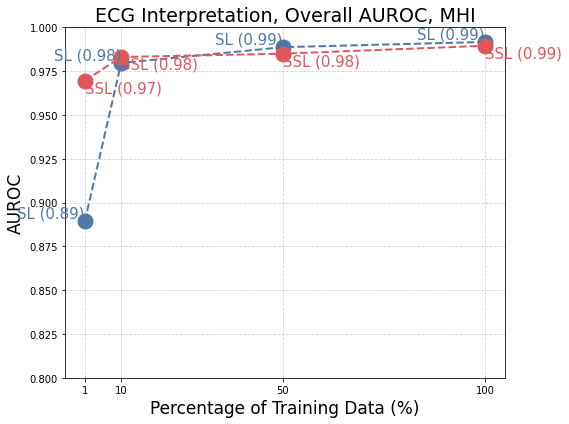

In [59]:
import matplotlib.pyplot as plt

# Data: percentages of training data and corresponding AUROCs
percentages = [1, 10, 50, 100]
deepecg_sl_aurocs = [0.8894, 0.9797, 0.9887, 0.9917]  # Replace with actual values
deepecg_ssl_aurocs = [0.9695, 0.9831, 0.9850, 0.9895]  # Replace with actual values

def sl_ssl_efficiency(percentages, sl_aurocs, ssl_aurocs, fontsize=15 ):
    # Create the plot
    plt.figure(figsize=(8, 6))

    # Plot DeepECG-SL
    plt.plot(percentages, sl_aurocs, markersize=fontsize, marker='o', linestyle="--", label='DeepECG-SL', color=COLOR_SL, linewidth=2)
    # Add text annotations for DeepECG-SL
    for x, y in zip(percentages, sl_aurocs):
        plt.text(x, y, f'SL ({y:.2f})', fontsize=fontsize, color=COLOR_SL, ha='right', va='bottom')

    # Plot DeepECG-SSL
    plt.plot(percentages, ssl_aurocs, markersize=fontsize, marker='o', linestyle="--", label='DeepECG-SSL', color=COLOR_SSL, linewidth=2)
    for x, y in zip(percentages, ssl_aurocs):
        plt.text(x, y, f'SSL ({y:.2f})', fontsize=fontsize, color=COLOR_SSL, ha='left', va='top')


    



    # Add titles and labels
    plt.title('ECG Interpretation, Overall AUROC, MHI', fontsize=fontsize+4)
    plt.xlabel('Percentage of Training Data (%)', fontsize=fontsize+2)
    plt.ylabel('AUROC', fontsize=fontsize+2)
    plt.xticks(percentages)
    plt.ylim(0.8, 1.0)  # Set y-axis limits to focus on AUROC range
    plt.grid(True, linestyle='--', alpha=0.6)

    # Add legend
    # plt.legend(fontsize=12)

    # Show the plot
    plt.tight_layout()
    plt.show()

sl_ssl_efficiency(percentages, deepecg_sl_aurocs, deepecg_ssl_aurocs)

In [32]:
# Generate Ecg interpretation table
def format_scores(scores):
    Label = 'Category'
    df = scores.copy()

    if 'Label' in df.columns:
        Label = 'Label'
    for i in range(len(df)):
        if df.loc[i, Label] == 'Total':
            df.loc[i, Label] = 'ALL'
    df.index = df[Label] + '_' + df['Metrics']
    #df = df[['Mean', '95% CI']]
    return df

def latext_text(text: str):
    return text.replace('>=','$\\geq$').replace('<=', '$\\leq$').replace('>', '$>$').replace('<', '$<$').replace('_', '\\_')
def bold(text, call=True):
    return '\\textbf{'+str(text)+'}' if call else '\\text{'+str(text)+'}'

def metric_block(row1,  row2, bold_max=True, inline=False):
    mean1, ci1 = row1
    mean2, ci2 = row2
    def is_in(v, interval):
        return interval[0]<=v and v <= interval[1]
    def delta():
        diff = float(mean2)-float(mean1)
        ci1_f = eval(ci1.replace(' - ', ','))
        ci2_f = eval(ci2.replace(' - ', ','))

        signif = -1 if diff < 0 else 1
        #diff = f'+{diff}' if diff > 0 else f'-{diff}'
        if is_in(ci1_f[0] , ci2_f) or is_in(ci1_f[1], ci2_f) or is_in(ci2_f[0], ci1_f) or is_in(ci2_f[1], ci1_f):
            signif = 0
        return diff, signif
    def tabular(mean, ci, best=False, inline=False):
        ci = ci.replace(' - ', ', ').replace('[', '(').replace(']', ')')
        #ci = f'${ci}$'
        if inline:
            #return bold(mean, best)
            return bold(mean, best) + '\\small{'+ bold(ci, best) + '}'
        else:
            return '\\begin{tabular}{@{}c@{}} ' + f'{bold(mean, best)} \\\\ {bold(ci, best)} ' + '\\end{tabular}'

        
    diff, signif = delta()
    if signif == 1:
        return  f'{tabular(mean1, ci1, False, inline)} & {tabular(mean2,  ci2, True and bold_max, inline)} & +{float(diff):.2f} '
    elif signif == -1:
        return  f'{tabular(mean1, ci1, True and bold_max, inline)} & {tabular(mean2,  ci2, False, inline)} & {float(diff):.2f} '
    else:
        return  f'{tabular(mean1, ci1, False, inline)} & {tabular(mean2,  ci2, False, inline)} &  -'

def table_task_v1(caption, caption_note, label, header, categories, datasets):
    table = '\\begin{table}[H]'
    table += '\n\t\\centering'
    table += '\n\t\\caption{'+caption+'}'
    table += '\n\t\\begin{adjustbox}{width=\\textwidth}'
    table += '\n\t\\begin{tabular}{ll'+'c'*3*len(datasets)+'}'
    table += '\n\t\t\\toprule'
    table += header
    for _, (text, _, _) in datasets.items():
        table += '\n\t\t& \multicolumn{3}{c}{\\bf{'+text+'}}'
    table += ' \n\t\t\\\\'    
    table += '\n\t\t'
    for v in range(3, len(datasets)*4, 3):
        table += '\\cmidrule(lr){'+str(v)+'-'+str(v+2)+'} '
    
    table += '\n\t\t & '+ '& DeepECG-SL & DeepECG-SSL & \(\Delta_{SSL-SL}\)'*len(datasets) + ' \\\\'
    table += '\n\t\t\\midrule'

    for cat, (text, metrics) in categories.items():
        table += '\n\t\t\\multirow{'+str(2*len(metrics))+'}{*}{'+text+'}'
        for mkey, metric in metrics.items():
            table += f'\n\t\t& {metric} '
            for _, (_, sl, ssl) in datasets.items():
                key = f'{cat}_{mkey}'
                table += f"& {metric_block(sl.loc[key, ['Mean', '95% CI']], ssl.loc[key, ['Mean', '95% CI']], )} " if key in sl.index else '& - & - & -'
            table += ' \\\\'
        table += '\n\t\t\\midrule'

    table += '\n\t\\end{tabular}'
    table += '\n\t\\end{adjustbox}'
    table += '\n\t\\label{'+label+'}'
    if caption_note is not None:
        table += '\n\t\\captionsetup{justification=centering, font=small} % Center align and set font size of the note'
        table += '\n\t\\captionsetup{skip=5pt} % Adjust spacing before note'
        table += '\n\t\\caption*{\\tiny \\textit{Note:} '+caption_note+'}'
    table += '\n\\end{table}'
    return table


def table_task_v2(caption, caption_note, label, header, categories, datasets, metrics, bold_best=True):
    table = '\\begin{table}[H]'
    table += '\n\t\\centering'
    table += '\n\t\\caption{'+caption+'}'
    table += '\n\t\\begin{adjustbox}{max width=\\textwidth}'
    table += '\n\t\\begin{tabular}{l'+'cc'*3*len(metrics)+'}'
    table += '\n\t\t\\toprule\n'
    table += '\n\t\t\\multirow{2}{*}{\\textbf{Dataset}} & \multirow{2}{*}{{Category}}'
    for _, text  in metrics.items():
        table += '\n\t\t& \multicolumn{3}{c}{\\textbf{'+text+'}}'
    table += ' \n\t\t\\\\'    
    table += '\n\t\t'
    for v in range(3, len(metrics)*4, 3):
        table += '\\cmidrule(lr){'+str(v)+'-'+str(v+2)+'} '
    
    table += '\n\t\t & '+ '& DeepECG-SL & DeepECG-SSL & \(\Delta_{SSL-SL}\)'*len(metrics) + ' \\\\'
    table += '\n\t\t\\midrule'

    for dkey, (dtext, sl, ssl) in datasets.items():
        table += '\n\t\t %'+dkey
        table += '\n\t\t\\multirow{'+str(2*len(categories))+'}{*}{\\bf{'+dtext+'}}'
        for cat, text in categories.items():
            if cat == 'ALL':
                table += '\n\t\t\\cmidrule(lr){2-2} ' + ' '.join(['\\cmidrule(lr){'+str(v)+'-'+str(v+2)+'} ' for v in range(3, len(metrics)*4, 3)])
            
            table += '\n\t\t& '+text #\\multirow{2}{*}{'+text+'}'
            
            for mkey, _ in metrics.items():
                key = f'{cat}_{mkey}'
                table += f"& {metric_block(sl.loc[key, ['Mean', '95% CI']], ssl.loc[key, ['Mean', '95% CI']], bold_best)} "
            table += ' \\\\'        
        table += '\n\t\t\\midrule'

    table += '\n\t\\bottomrule'
    table += '\n\t\\end{tabular}'
    table += '\n\t\\end{adjustbox}'
    table += '\n\t\\label{'+label+'}'
    if caption_note is not None:
        table += '\n\t\\captionsetup{justification=centering, font=small} % Center align and set font size of the note'
        table += '\n\t\\captionsetup{skip=5pt} % Adjust spacing before note'
        table += '\n\t\\caption*{\\tiny \\textit{Note:} '+caption_note+'}'
    
    table += '\n\\end{table}'
    return table


def table_task_dataset(caption, caption_note, label, header, categories, sl_scores, ssl_scores, stats, metrics, group_metrics, bold_best=True):
    
    def to_percentage(num, percentage=True):
        return f'{float(num)*100:.1f}' if percentage else f'{float(num):.3f}'
    def get_key_label(key_label):
        if isinstance(key_label, (tuple, list)):
            return key_label[0], key_label[1]
        else:
            return key_label, key_label
    
    table = '\\begin{table}[H]'
    table += '\n\t\\centering'
    table += '\n\t\\caption{'+caption+'}'
    table += '\n\t\\begin{adjustbox}{max width=\\textwidth}'
    table += '\n\t\\begin{tabular}{l'+'cc'*3*len(metrics)+'}'
    table += '\n\t\t\\toprule\n'
    table += '\n\t\t\\multirow{2}{*}{\\textbf{Labels}} & \multirow{2}{*}{Prevalance \%}'
    for _, text  in metrics.items():
        table += '\n\t\t& \multicolumn{3}{c}{\\textbf{'+text+'}}'
    table += ' \n\t\t\\\\'    
    table += '\n\t\t'
    for v in range(3, len(metrics)*4, 3):
        table += '\\cmidrule(lr){'+str(v)+'-'+str(v+2)+'} '
    
    table += '\n\t\t & '+ '& DeepECG-SL & DeepECG-SSL & \(\Delta_{SSL-SL}\)'*len(metrics) + ' \\\\'
    table += '\n\t\t\\midrule'
    
    for cat, (title, items) in categories.items():
        table += '\n\t\t %'+cat
        #table += '\n\t\t\\multirow{'+str(2*len(items))+'}{*}{\\bf{'+title+'}}'
        
        for item in items:
            table += '\n\t\t'+latext_text(item)+' ' #\\multirow{2}{*}{'+text+'}'
            table += f"& {to_percentage(stats[item]/stats['$count$'])} \%"
            for mkey, _ in metrics.items():
                key = f'{item}_{mkey}'
                table += f"& {metric_block(sl_scores.loc[key, ['Mean', '95% CI']], ssl_scores.loc[key, ['Mean', '95% CI']], bold_best, True)} "
            table += ' \\\\'

        if len(group_metrics) > 0:
            table += '\n\t\t\\cmidrule(lr){2-2} ' + ' '.join(['\\cmidrule(lr){'+str(v)+'-'+str(v+2)+'} ' for v in range(3, len(metrics)*4, 3)])    
            table += '\n\t\t\\bf{'+title+'}' #\\multirow{2}{*}{'+text+'}'
            table += f"& {to_percentage(stats[cat]/stats['$count$'])} \%"
            
            for mkey, _ in group_metrics.items():
                key = f'{cat}_{mkey}'
                table += f"& {metric_block(sl_scores.loc[key, ['Mean', '95% CI']], ssl_scores.loc[key, ['Mean', '95% CI']], bold_best, True)} "
            table += ' \\\\'        
        table += '\n\t\t\\midrule'


    table += '\n\t\\bottomrule'
    table += '\n\t\\end{tabular}'
    table += '\n\t\\end{adjustbox}'
    table += '\n\t\\label{'+label+'}'
    if caption_note is not None:
        table += '\n\t\\captionsetup{justification=centering, font=small} % Center align and set font size of the note'
        table += '\n\t\\captionsetup{skip=5pt} % Adjust spacing before note'
        table += '\n\t\\caption*{\\tiny \\textit{Note:} '+caption_note+'}'
    
    table += '\n\\end{table}'
    return table


def table_db_dataset(caption, caption_note, label, header, tasks, sl_scores, ssl_scores,  metrics, bold_best=True):
    
    def to_percentage(num, percentage=True):
        return f'{float(num)*100:.1f}' if percentage else f'{float(num):.3f}'
    
    table = '\\begin{table}[H]'
    table += '\n\t\\centering'
    table += '\n\t\\caption{'+caption+'}'
    table += '\n\t\\begin{adjustbox}{max width=\\textwidth}'
    table += '\n\t\\begin{tabular}{l'+'cc'*3*len(metrics)+'}'
    table += '\n\t\t\\toprule\n'
    table += '\n\t\t\\multirow{2}{*}{Labels (N = sample size)} & \multirow{2}{*}{Prevalance \%}'
    for _, text  in metrics.items():
        table += '\n\t\t& \multicolumn{3}{c}{\\textbf{'+text+'}}'
    table += ' \n\t\t\\\\'    
    table += '\n\t\t'
    for v in range(3, len(metrics)*4, 3):
        table += '\\cmidrule(lr){'+str(v)+'-'+str(v+2)+'} '
    
    table += '\n\t\t & '+ '& DeepECG-SL & DeepECG-SSL & \(\Delta_{SSL-SL}\)'*len(metrics) + ' \\\\'
    table += '\n\t\t\\midrule'
    
    for lkey, title, stats in tasks:
        table += '\n\t\t %'+lkey
        #table += '\n\t\t\\multirow{'+str(2*len(items))+'}{*}{\\bf{'+title+'}}'
        
        table += '\n\t\t'+latext_text(title)+ f" (N = {stats['$count$']}) " #\\multirow{2}{*}{'+text+'}'
        table += f"& {to_percentage(stats[lkey]/stats['$count$'])} \%"
        for mkey, _ in metrics.items():
            key = f'{lkey}_{mkey}'
            table += f"& {metric_block(sl_scores.loc[key, ['Mean', '95% CI']], ssl_scores.loc[key, ['Mean', '95% CI']], bold_best, True)} "
        table += ' \\\\'

    table += '\n\t\t\\midrule'


    table += '\n\t\\bottomrule'
    table += '\n\t\\end{tabular}'
    table += '\n\t\\end{adjustbox}'
    table += '\n\t\\label{'+label+'}'
    if caption_note is not None:
        table += '\n\t\\captionsetup{justification=centering, font=small} % Center align and set font size of the note'
        table += '\n\t\\captionsetup{skip=5pt} % Adjust spacing before note'
        table += '\n\t\\caption*{\\tiny \\textit{Note:} '+caption_note+'}'
    
    table += '\n\\end{table}'
    return table



def table_task_bert(caption, caption_note, label, header, categories, bert_scores, metrics, group_metrics):
    
    def to_percentage(num, percentage=True):
        return f'{float(num)*100:.1f}' if percentage else f'{float(num):.3f}'
    def get_key_label(key_label):
        if isinstance(key_label, (tuple, list)):
            return key_label[0], key_label[1]
        else:
            return key_label, key_label
    
    table = '\\begin{table}[H]'
    table += '\n\t\\centering'
    table += '\n\t\\caption{'+caption+'}'
    table += '\n\t\\begin{adjustbox}{max width=\\textwidth}'
    table += '\n\t\\begin{tabular}{l'+'c'*len(metrics)+'}'
    table += '\n\t\t\\toprule\n'
    table += '\n\t\t\\\textbf{Labels} '
    for _, text  in metrics.items():
        table += '\t\t& \\textbf{'+text+'}'
    table += ' \n\t\t\\\\'    
    table += '\n\t\t'
    table += '\n\t\t\\midrule'
    
    for cat, (title, items) in categories.items():
        table += '\n\t\t %'+cat
        #table += '\n\t\t\\multirow{'+str(2*len(items))+'}{*}{\\bf{'+title+'}}'
        
        for item in items:
            table += '\n\t\t'+latext_text(item)+' ' #\\multirow{2}{*}{'+text+'}'
            for mkey, _ in metrics.items():
                key = f'{item}_{mkey}'
                table += f"& {to_percentage(bert_scores.loc[key, 'Mean'])}"
            table += ' \\\\'

        if len(group_metrics) > 0:
            table += '\n\t\t\\cmidrule(lr){2-'+str(1+len(metrics))+'}'    
            table += '\n\t\t\\bf{'+title+'}' #\\multirow{2}{*}{'+text+'}'
            for mkey, _ in group_metrics.items():
                key = f'{cat}_{mkey}'
                table += f"& {to_percentage(bert_scores.loc[key, 'Mean'])} "
            table += ' \\\\'        
        table += '\n\t\t\\midrule'


    table += '\n\t\\bottomrule'
    table += '\n\t\\end{tabular}'
    table += '\n\t\\end{adjustbox}'
    table += '\n\t\\label{'+label+'}'
    if caption_note is not None:
        table += '\n\t\\captionsetup{justification=centering, font=small} % Center align and set font size of the note'
        table += '\n\t\\captionsetup{skip=5pt} % Adjust spacing before note'
        table += '\n\t\\caption*{\\tiny \\textit{Note:} '+caption_note+'}'
    
    table += '\n\\end{table}'
    return table



def n_prev_df(df, label):
    total, prev = len(df), df[label].sum()
    return total, prev, f'{prev/total*100:.2f}%'

def n_prev_npy(y):
    total, prev = len(y), np.sum(y)
    return total, prev, f'{prev/total*100:.2f}%'
    
def table_ecg_interpretation_ds_group(caption: str, label: str, ds_keys: List[str]):
    categories = {
        "RHYTHM": ('RHYTHM', ['Ventricular tachycardia','Bradycardia','Brugada','Wolff-Parkinson-White (Pre-excitation syndrome)','Atrial flutter','Ectopic atrial rhythm (< 100 BPM)','Atrial tachycardia (>= 100 BPM)','Sinusal','Ventricular Rhythm','Supraventricular tachycardia','Junctional rhythm','Regular','Regularly irregular','Irregularly irregular','Afib','Premature ventricular complex','Premature atrial complex']),
        "CONDUCTION": ('CONDUCTION', ['Left anterior fascicular block','Delta wave','2nd degree AV block - mobitz 2','Left bundle branch block','Right bundle branch block','Left axis deviation','Atrial paced','Right axis deviation','Left posterior fascicular block','1st degree AV block','Right superior axis','Nonspecific intraventricular conduction delay','Third Degree AV Block','2nd degree AV block - mobitz 1','Prolonged QT','U wave','LV pacing','Ventricular paced']),
        "CHAMBER ENLARGEMENT": ('CHAMBER ENLARGMENT', ['Bi-atrial enlargement','Left atrial enlargement','Right atrial enlargement','Left ventricular hypertrophy','Right ventricular hypertrophy']),
        "PERICARDITIS": ('PERICARDITIS', ['Acute pericarditis']),
        'INFARCT, ISCHEMIA': ('INFARCT, ISCHEMIA', ['Q wave (septal- V1-V2)','ST elevation (anterior - V3-V4)','Q wave (posterior - V7-V9)','Q wave (inferior - II, III, aVF)','Q wave (anterior - V3-V4)','ST elevation (lateral - I, aVL, V5-V6)','Q wave (lateral- I, aVL, V5-V6)','ST depression (lateral - I, avL, V5-V6)','Acute MI','ST elevation (septal - V1-V2)','ST elevation (inferior - II, III, aVF)','ST elevation (posterior - V7-V8-V9)','ST depression (inferior - II, III, aVF)','ST depression (anterior - V3-V4)']),
        "OTHER": ('OTHER', ['ST downslopping','ST depression (septal- V1-V2)','R/S ratio in V1-V2 >1','RV1 + SV6 > 11 mm','Polymorph',"rSR' in V1-V2",'QRS complex negative in III','qRS in V5-V6-I, aVL','QS complex in V1-V2-V3','R complex in V5-V6','RaVL > 11 mm','T wave inversion (septal- V1-V2)','SV1 + RV5 or RV6 > 35 mm','T wave inversion (inferior - II, III, aVF)','Monomorph','T wave inversion (anterior - V3-V4)','T wave inversion (lateral -I, aVL, V5-V6)','Low voltage','Lead misplacement','ST depression (anterior - V3-V4)','Early repolarization','ST upslopping','no_qrs']),
    }   

    datasets = {}
    for key in ds_keys:
        ds = getSingletonDataset(key)
        datasets[key] = (
            ds.title, 
            get_formated_scores('sl', key, 'labels_77'), 
            get_formated_scores('ssl', key, 'labels_77'),
            ds.get_stats(getSingletonTask('labels_77', 'sl', key))
        )
    header = '\n\t\t\\multirow{2}{*}{Labels} & \\multirow{2}{*}{\\shortstack{Metrics \\\\ (micro)}}'
    metrics = {'auroc': 'AUROC (95% CI)',  'auprc': 'AUPRC (95% CI)'}
    label=f'tab:{label}'        
    table = table_task_dataset(
        caption=caption,
        caption_note=None,
        label=label,
        header=header,
        categories=categories,
        datasets=datasets,
        metrics=metrics,
        group_metrics='micro' 
    )
    print(table.expandtabs(2))
    return table

    
def table_digital_biomarker_ds(caption: str, ds_key:str):
    categories={
        'LVEF_EQUAL_OR_UNDER_40_tte_lvef': 'LVEF <= 40', 
        'LVEF_UNDER_50_tte_lvef': 'LVEF < 50', 
        'Visually Estimated EF_tte_lvef': 'LVEF Regression',
        'label_5y': 'iAF5', 
        'LQTS': 'LQTS', 
        'LQTS_TYPE_1': 'LQTS Type' 
    }
    
    tasks = []
    sl_scores = []
    ssl_scores = []
    ds = getSingletonDataset(ds_key)            
    for task_key in ds.tasks:
        if task_key == 'labels_77':
            continue
        sl_scores += [get_formated_scores('sl', ds_key, task_key)]
        ssl_scores += [get_formated_scores('ssl', ds_key, task_key)]
        task = getSingletonTask(task_key, 'sl', ds_key)
        stats = ds.get_stats(getSingletonTask(task_key, 'sl', ds_key))
        for label in task.labels:
            tasks += [(label, categories[label], stats)]
    
    sl_scores = pd.concat(sl_scores, axis=0) if len(sl_scores) > 0 else pd.DataFrame({})
    ssl_scores = pd.concat(ssl_scores, axis=0) if len(ssl_scores) > 0 else pd.DataFrame({})
    header = '\n\t\t\\multirow{2}{*}{Labels (N = sample size)} & \\multirow{2}{*}{\\shortstack{Metrics \\\\ (micro)}}'
    metrics = {'auroc': 'AUROC (95\% CI)',  'auprc': 'AUPRC (95\% CI)'}
    table = table_db_dataset(
        caption=caption,
        caption_note=None,
        label=f'tab:digital_biomarker_{ds_key}',
        header=header,
        sl_scores=sl_scores,
        ssl_scores=ssl_scores,
        tasks=tasks,
        metrics=metrics,
    )
    print(table.expandtabs(2))
    return table


def table_ecg_interpretation_ds(caption: str, ds_key:str):
    categories = {
        "RHYTHM": ('RHYTHM', ['Ventricular tachycardia','Bradycardia','Brugada','Wolff-Parkinson-White (Pre-excitation syndrome)','Atrial flutter','Ectopic atrial rhythm (< 100 BPM)','Atrial tachycardia (>= 100 BPM)','Sinusal','Ventricular Rhythm','Supraventricular tachycardia','Junctional rhythm','Regular','Regularly irregular','Irregularly irregular','Afib','Premature ventricular complex','Premature atrial complex']),
        "CONDUCTION": ('CONDUCTION', ['Left anterior fascicular block','Delta wave','2nd degree AV block - mobitz 2','Left bundle branch block','Right bundle branch block','Left axis deviation','Atrial paced','Right axis deviation','Left posterior fascicular block','1st degree AV block','Right superior axis','Nonspecific intraventricular conduction delay','Third Degree AV Block','2nd degree AV block - mobitz 1','Prolonged QT','U wave','LV pacing','Ventricular paced']),
        "CHAMBER ENLARGEMENT": ('CHAMBER ENLARGMENT', ['Bi-atrial enlargement','Left atrial enlargement','Right atrial enlargement','Left ventricular hypertrophy','Right ventricular hypertrophy']),
        "PERICARDITIS": ('PERICARDITIS', ['Acute pericarditis']),
        'INFARCT, ISCHEMIA': ('INFARCT, ISCHEMIA', ['Q wave (septal- V1-V2)','ST elevation (anterior - V3-V4)','Q wave (posterior - V7-V9)','Q wave (inferior - II, III, aVF)','Q wave (anterior - V3-V4)','ST elevation (lateral - I, aVL, V5-V6)','Q wave (lateral- I, aVL, V5-V6)','ST depression (lateral - I, avL, V5-V6)','Acute MI','ST elevation (septal - V1-V2)','ST elevation (inferior - II, III, aVF)','ST elevation (posterior - V7-V8-V9)','ST depression (inferior - II, III, aVF)','ST depression (anterior - V3-V4)']),
        "OTHER": ('OTHER', ['ST downslopping','ST depression (septal- V1-V2)','R/S ratio in V1-V2 >1','RV1 + SV6 > 11 mm','Polymorph',"rSR' in V1-V2",'QRS complex negative in III','qRS in V5-V6-I, aVL','QS complex in V1-V2-V3','R complex in V5-V6','RaVL > 11 mm','T wave inversion (septal- V1-V2)','SV1 + RV5 or RV6 > 35 mm','T wave inversion (inferior - II, III, aVF)','Monomorph','T wave inversion (anterior - V3-V4)','T wave inversion (lateral -I, aVL, V5-V6)','Low voltage','Lead misplacement','ST depression (anterior - V3-V4)','Early repolarization','ST upslopping','no_qrs']),
        "ALL": ('TOTAL', [])
    }   

    ds = getSingletonDataset(ds_key)            
    sl_scores = get_formated_scores('sl', ds_key, 'labels_77')
    ssl_scores = get_formated_scores('ssl', ds_key, 'labels_77')
    stats = ds.get_stats(getSingletonTask('labels_77', 'sl', ds_key))
    header = '\n\t\t\\multirow{2}{*}{Labels} & \\multirow{2}{*}{\\shortstack{Metrics \\\\ (micro)}}'
    metrics = {'auroc': 'AUROC (95\% CI)',  'auprc': 'AUPRC (95\% CI)'}
    group_metrics = {'micro_auroc': 'AUROC (95\% CI)',  'micro_auprc': 'AUPRC (95\% CI)'}
    table = table_task_dataset(
        caption=f"{caption} (N = {stats['$count$']})",
        caption_note=None,
        label=f'tab:ecg_interpretation_{ds_key}',
        header=header,
        sl_scores=sl_scores,
        ssl_scores=ssl_scores,
        categories=categories,
        stats=stats,
        metrics=metrics,
        group_metrics=group_metrics 
    )
    print(table.expandtabs(2))
    return table


def table_bert_results(bert_path='/media/data1/jdelfrate/bert_metrics_val_en_fr.json'):
    
    def convert_bert_scores(bert_df):
        df = bert_df.copy()
        df.rename(columns={
            'Rhythm Disorders': 'RHYTHM', 'Conduction Disorder': 'CONDUCTION', 
            'Enlargement of the heart chambers': 'CHAMBER ENLARGEMENT', 'Pericarditis': 'PERICARDITIS',
            'Infarction or ischemia': 'INFARCT, ISCHEMIA', 'Other diagnoses': 'OTHER' }, inplace=True)
        data = {'Category': [], 'Metrics': [], 'Mean': []}
        for col in df.columns[:6]:
            data['Category'] += [col]*3
            data['Metrics'] += ['micro_auroc', 'micro_auprc', 'micro_f1score']
            data['Mean'] += [df.loc['micro_auc', col], df.loc['micro_auprc', col], df.loc['micro_f1', col]]
    
        for col in df.columns[6:]:
            data['Category'] += [col]*3
            data['Metrics'] += ['auroc', 'auprc', 'f1score']
            data['Mean'] += [df.loc['auc', col], df.loc['auprc', col], df.loc['f1', col]]
        return pd.DataFrame(data)

    bert_scores = convert_bert_scores(pd.read_json(bert_path))
    categories = {
        "RHYTHM": ('RHYTHM', ['Ventricular tachycardia','Bradycardia','Brugada','Wolff-Parkinson-White (Pre-excitation syndrome)','Atrial flutter','Ectopic atrial rhythm (< 100 BPM)','Atrial tachycardia (>= 100 BPM)','Sinusal','Ventricular Rhythm','Supraventricular tachycardia','Junctional rhythm','Regular','Regularly irregular','Irregularly irregular','Afib','Premature ventricular complex','Premature atrial complex']),
        "CONDUCTION": ('CONDUCTION', ['Left anterior fascicular block','Delta wave','2nd degree AV block - mobitz 2','Left bundle branch block','Right bundle branch block','Left axis deviation','Atrial paced','Right axis deviation','Left posterior fascicular block','1st degree AV block','Right superior axis','Nonspecific intraventricular conduction delay','Third Degree AV Block','2nd degree AV block - mobitz 1','Prolonged QT','U wave','LV pacing','Ventricular paced']),
        "CHAMBER ENLARGEMENT": ('CHAMBER ENLARGMENT', ['Bi-atrial enlargement','Left atrial enlargement','Right atrial enlargement','Left ventricular hypertrophy','Right ventricular hypertrophy']),
        "PERICARDITIS": ('PERICARDITIS', ['Acute pericarditis']),
        'INFARCT, ISCHEMIA': ('INFARCT, ISCHEMIA', ['Q wave (septal- V1-V2)','ST elevation (anterior - V3-V4)','Q wave (posterior - V7-V9)','Q wave (inferior - II, III, aVF)','Q wave (anterior - V3-V4)','ST elevation (lateral - I, aVL, V5-V6)','Q wave (lateral- I, aVL, V5-V6)','ST depression (lateral - I, avL, V5-V6)','Acute MI','ST elevation (septal - V1-V2)','ST elevation (inferior - II, III, aVF)','ST elevation (posterior - V7-V8-V9)','ST depression (inferior - II, III, aVF)','ST depression (anterior - V3-V4)']),
        "OTHER": ('OTHER', ['ST downslopping','ST depression (septal- V1-V2)','R/S ratio in V1-V2 >1','RV1 + SV6 > 11 mm','Polymorph',"rSR' in V1-V2",'QRS complex negative in III','qRS in V5-V6-I, aVL','QS complex in V1-V2-V3','R complex in V5-V6','RaVL > 11 mm','T wave inversion (septal- V1-V2)','SV1 + RV5 or RV6 > 35 mm','T wave inversion (inferior - II, III, aVF)','Monomorph','T wave inversion (anterior - V3-V4)','T wave inversion (lateral -I, aVL, V5-V6)','Low voltage','Lead misplacement','ST depression (anterior - V3-V4)','Early repolarization','ST upslopping','no_qrs']),
        #"ALL": ('TOTAL', [])
    }   
    bert_scores = format_scores(bert_scores)
    header = '\n\t\t\\multirow{2}{*}{Labels} & \\multirow{2}{*}{\\shortstack{Metrics \\\\ (micro)}}'
    metrics = {'auroc': 'AUROC',  'auprc': 'AUPRC', 'f1score': 'F1 Score'}
    group_metrics = {'micro_auroc': 'AUROC',  'micro_auprc': 'AUPRC', 'micro_f1score': 'F1 Score'}
    table = table_task_bert(
        caption="BERT Classification performance across ECG interpretation labels and categories",
        caption_note="These results were obtained by evaluating the model on a merged dataset comprising MIMIC-IV, MHI-ds, and PTB.",
        label=f'tab:classification-metrics',
        header=header,
        bert_scores=bert_scores,
        categories=categories,
        metrics=metrics,
        group_metrics=group_metrics 
    )
    print(table.expandtabs(2))
    return table




def table_privacy():
    prefix = 'privacy'
    mhi_ssl = get_ssl_scores(subset='test', prefix=prefix)
    mhi_sl = get_sl_scores(subset='MHI', prefix=prefix)
    mimic_ssl = get_ssl_scores(subset='mimic_cleaned', prefix=prefix)
    mimic_sl = get_sl_scores(subset='MIMIC', prefix=prefix)
    ptb_ssl = get_ssl_scores(subset='ptb_cleaned', prefix=prefix)
    ptb_sl = get_sl_scores(subset='PTB', prefix=prefix)
    ukb_ssl = get_ssl_scores(subset='ukbb_cleaned_high_pass_scaled', prefix=prefix)
    ukb_sl = get_sl_scores(subset='UKB', prefix=prefix)
    clsa_ssl = get_ssl_scores(subset='clsa_cleaned', prefix=prefix)
    clsa_sl = get_sl_scores(subset='CLSA', prefix=prefix)

    header = '\n\t\t\\multirow{2}{*}{Category} & \\multirow{2}{*}{\\shortstack{Metrics \\\\ (micro)}}'
    metrics = {'auroc': 'AUROC',  'auprc': 'AUPRC'}
    label='tab:privacy'
        
    table = table_task_v2(
        caption='Membership Inference Attack Evaluation Metrics for MIMIC, UKB, MHI, and PTB Datasets',
        caption_note=None,
        label=label,
        header=header,
        categories={
            'privacy': 'Privacy'},
        datasets={
            'mhi': ('MHI', format_scores(mhi_sl), format_scores(mhi_ssl)), 
            'mimic': ('MIMIC', format_scores(mimic_sl), format_scores(mimic_ssl)), 
            'ptb': ('PTB', format_scores(ptb_sl), format_scores(ptb_ssl)), 
            'ukbb': ('UKB', format_scores(ukb_sl), format_scores(ukb_ssl)), 
            'clsa': ('CLSA', format_scores(clsa_sl), format_scores(clsa_ssl))
        },
        metrics=metrics,
        bold_best=False
    )
    print(table.expandtabs(2))
    return table


def table_finetune():
    ssl_keys = ['fevg-v2-40-bce', 'fevg-v2-50-bce', 'fevg-reg-mse', 'afib-v2-5-bf', 'lqts-bf', 'lqts-type-bf']
    sl_keys = ['LVEF_40', 'LVEF_50', 'LVEF_REG', 'AFIB_5', 'LQTS', 'LQTS_TYPE']

    mhi_ssl = pd.concat(
        [get_ssl_scores(results_key=f'last-ft-{key}', subset='test') for key in ssl_keys], axis=0).reset_index(drop=True).rename(columns={'Label': 'Category'})
    mhi_sl = pd.concat(
        [get_sl_scores(subset=f'MHI_{key}') for key in sl_keys], axis=0).reset_index(drop=True).rename(columns={'Label': 'Category'})
    mimic_ssl = pd.concat(
        [get_ssl_scores(results_key=f'last-ft-{key}', subset='mimic_cleaned') for key in ssl_keys[:-2]], axis=0).reset_index(drop=True).rename(columns={'Label': 'Category'})
    mimic_sl = pd.concat(
        [get_sl_scores(subset=f'MIMIC_{key}') for key in sl_keys[:-2]], axis=0).reset_index(drop=True).rename(columns={'Label': 'Category'})
    
    def ftitle(title, n1, prev1, n2, prev2):
        title ='\\shortstack[l]{\\bf{' + title + '}' + '\\\\ \\scriptsize N_{mhi}= '+str(n1)
        if prev1 is not None: 
            title += f' ({prev1/n1*100:.1f}\\%)'
        if n2 is not None:
            title += ' \\\\ \\scriptsize N_{mimic} = '+str(n2)
        if prev2 is not None: 
            title += f' ({prev2/n2*100:.1f}\\%)'
        title += '}'
        return title
    
    cls_metrics={'f1score': 'F1 Score', 'auroc': 'AUROC', 'auprc': 'AUPRC'}
    reg_metrics = {'mse': 'MSE', 'r2': 'R$^{2}$', 'pearson_correlation': 'Pearson Correlation'}
    categories={
        'LVEF_EQUAL_OR_UNDER_40_tte_lvef': (ftitle('LVEF $\leq$ 40', 25252, 2093.0, 5524, 1076,), cls_metrics), 
        'LVEF_UNDER_50_tte_lvef': (ftitle('LVEF $<$ 50', 25252, 3522.0, 5524, 1772), cls_metrics), 
        'Visually Estimated EF_tte_lvef': (ftitle('LVEF Regression', 16564, None, 5524, None), reg_metrics),
        'label_5y': (ftitle('AFIB 5 years', 132050, 15533, 437323, 65301.0),  cls_metrics), 
        'LQTS': (ftitle('LQTS', 943, 127, None, None), cls_metrics), 
        'LQTS_TYPE_1': (ftitle('LQTS Type', 127, 99, None, None), cls_metrics) 
    }
        
    table = table_task_v1(
        caption='Performance of Fine-tuned Tasks Across Datasets (MHI, MIMIC)',
        caption_note= 'MHI refers to the preprocessed MHI-test set, while MIMIC refers to the preprocessed MIMIC-IV-test set',
        label='tab:finetune_task_short',
        header='\n\t\t\\multirow{2}{*}{\\shortstack[l]{\\bf{Task} \\\\ \\scriptsize N = Sample size (Prevalance \%)}} & \multirow{2}{*}{{Metrics}}',
        #header='\n\t\t\\multirow{2}{*}{Category} & \multirow{2}{*}{\shortstack{metrics \\\\ (micro)}}',
        categories=categories,
        datasets={
            'mhi': ('MHI', format_scores(mhi_sl), format_scores(mhi_ssl), ), 
            'mimic': ('MIMIC', format_scores(mimic_sl), format_scores(mimic_ssl)), 
        },   
    )
    
    print(table.expandtabs(2))
    return table

table_bert_results()

#table = table_ecg_interpretation_ds_group(caption='Performance Metrics Across Datasets (MHI, MIMIC, PTB, UKB, CLSA)', label='ecg_interpretation_epd', ds_keys=['mimic', 'ptb', 'ukb', 'clsa'])
for ds_key in DATASETS:
    continue
    ds = getSingletonDataset(ds_key)
    table = table_ecg_interpretation_ds(caption=f'Performance of the models on the {ds.title} dataset', ds_key=ds_key)
#table = table_finetune()
#table = table_privacy()

for ds_key in DATASETS:
    continue
    ds = getSingletonDataset(ds_key)
    table = table_digital_biomarker_ds(caption=f'Performance of the models on the {ds.title} dataset', ds_key=ds_key)




\begin{table}[H]
  \centering
  \caption{BERT Classification performance across ECG interpretation labels and categories}
  \begin{adjustbox}{max width=\textwidth}
  \begin{tabular}{lccc}
    \toprule

    \ extbf{Labels}     & \textbf{AUROC}    & \textbf{AUPRC}    & \textbf{F1 Score} 
    \\
    
    \midrule
     %RHYTHM
    Ventricular tachycardia & 100.0& 99.5& 86.0 \\
    Bradycardia & 100.0& 100.0& 100.0 \\
    Brugada & 99.9& 67.8& 7.9 \\
    Wolff-Parkinson-White (Pre-excitation syndrome) & 100.0& 99.2& 98.4 \\
    Atrial flutter & 100.0& 99.7& 98.2 \\
    Ectopic atrial rhythm ($<$ 100 BPM) & 100.0& 99.9& 90.2 \\
    Atrial tachycardia ($\geq$ 100 BPM) & 100.0& 99.9& 98.7 \\
    Sinusal & 100.0& 100.0& 99.9 \\
    Ventricular Rhythm & 100.0& 99.9& 99.2 \\
    Supraventricular tachycardia & 100.0& 98.2& 52.0 \\
    Junctional rhythm & 100.0& 98.6& 93.6 \\
    Regular & 99.9& 100.0& 99.8 \\
    Regularly irregular & 100.0& 99.9& 99.0 \\
    Irregularly irregular & 100.0& 99.9& 9

#### Fairness and Privacy

In [5]:
import torch
import numpy as np
from tqdm import tqdm

#IMPORTANT ONE
def equalized_odds_with_average_pairwise_disparities(predictions, true_labels, protected_attributes, average='macro', 
                                                     num_iterations=1000, sample_fraction=0.7):
    """
    Calculate Equalized Odds using the average pairwise TPR/FPR disparities across groups with micro or macro averaging.

    Args:
        predictions (np.ndarray): Model predictions (N, num_labels) as binary values.
        true_labels (np.ndarray): True labels (N, num_labels) as binary values.
        protected_attributes (np.ndarray): Group membership (N,).
        average (str): 'micro' or 'macro' for averaging disparities.
        num_iterations (int): Number of iterations for permutation sampling.
        sample_fraction (float): Fraction of the data to sample in each iteration.

    Returns:
        dict: Mean and 95% CI for average pairwise TPR and FPR differences across groups.
    """
    # Convert inputs to PyTorch tensors
    predictions = torch.tensor(predictions, dtype=torch.float32)
    true_labels = torch.tensor(true_labels, dtype=torch.float32)
    protected_attributes = torch.tensor(protected_attributes, dtype=torch.float32)

    # Helper function to calculate TPR and FPR for a group
    def calculate_rates(group_preds, group_labels):
        true_positive = (group_preds * group_labels).sum(dim=0)
        false_positive = (group_preds * (1 - group_labels)).sum(dim=0)
        total_positive = group_labels.sum(dim=0)
        total_negative = (1 - group_labels).sum(dim=0)

        # Avoid division by zero by setting TPR or FPR to zero if the denominator is zero
        tpr = torch.where(total_positive > 0, true_positive / total_positive, torch.zeros_like(total_positive))
        fpr = torch.where(total_negative > 0, false_positive / total_negative, torch.zeros_like(total_negative))
        return tpr, fpr

    # Initialize storage for pairwise disparities
    tpr_diffs = []
    fpr_diffs = []

    # Iterate through permutations
    for _ in tqdm(range(num_iterations), desc="Calculating Equalized Odds"):
        # Randomly sample a fraction of the dataset
        sample_size = int(sample_fraction * len(predictions))
        indices = torch.randperm(len(predictions))[:sample_size]
        sampled_predictions = predictions[indices]
        sampled_true_labels = true_labels[indices]
        sampled_protected_attributes = protected_attributes[indices]

        # Calculate TPR and FPR for each group
        unique_groups = torch.unique(sampled_protected_attributes)
        group_rates = {}

        for group in unique_groups:
            group_mask = sampled_protected_attributes == group
            group_preds = sampled_predictions[group_mask]
            group_labels = sampled_true_labels[group_mask]
            group_rates[group.item()] = calculate_rates(group_preds, group_labels)

        # Extract TPRs and FPRs
        tprs = torch.stack([rate[0] for rate in group_rates.values()])  # TPR for each group (num_labels,)
        fprs = torch.stack([rate[1] for rate in group_rates.values()])  # FPR for each group (num_labels,)

        # Compute disparities based on averaging method
        if average == 'micro':
            # Micro: Compute disparity for each label and average across labels
            avg_tpr_diff = torch.mean(torch.abs(tprs.unsqueeze(1) - tprs.unsqueeze(0))).item()
            avg_fpr_diff = torch.mean(torch.abs(fprs.unsqueeze(1) - fprs.unsqueeze(0))).item()
        elif average == 'macro':
            # Macro: Compute disparity across groups for each label and average
            avg_tpr_diff = torch.mean(torch.mean(torch.abs(tprs.unsqueeze(1) - tprs.unsqueeze(0)), dim=(0, 1))).item()
            avg_fpr_diff = torch.mean(torch.mean(torch.abs(fprs.unsqueeze(1) - fprs.unsqueeze(0)), dim=(0, 1))).item()
        else:
            raise ValueError("average must be 'micro' or 'macro'")

        tpr_diffs.append(avg_tpr_diff)
        fpr_diffs.append(avg_fpr_diff)

    # Calculate mean and 95% confidence intervals for pairwise disparities
    results = {
        'tpr_diff_mean': np.mean(tpr_diffs),
        'tpr_diff_ci': np.percentile(tpr_diffs, [2.5, 97.5]),
        'fpr_diff_mean': np.mean(fpr_diffs),
        'fpr_diff_ci': np.percentile(fpr_diffs, [2.5, 97.5]),
    }

    return results

In [6]:
pd.set_option('display.max_columns', None)
metadata = pd.read_parquet('/media/data1/muse_ge/test_trial_v1.1.parquet')

protected_attributes = metadata['RestingECG_PatientDemographics_Gender']

if protected_attributes.dtype == 'object' or pd.api.types.is_categorical_dtype(protected_attributes):
    protected_attributes = pd.Categorical(protected_attributes).codes  # Convert to numerical codes


In [30]:
def equalized_odds(results_key, root_dir, subset, task, y_labels=[], categories=None, average='macro', device='cuda:1'):
    header_npy, header_pkl, df_path, npy_path, y_idx = read_manifest(results_key, root_dir, subset)
    y_pred, y_true = get_pred_labels(
        header_pkl=header_pkl,
        header_npy=header_npy,
        df_path=df_path,
        npy_path=npy_path,
        y_idx=y_idx,
        y_labels=y_labels
    )
    results_path = get_path(results_key)
    y_pred = torch.sigmoid(torch.from_numpy(y_pred).to(device=device))
    y_true = torch.from_numpy(y_true).to(device=device)

    
    protected_attributes = get_protected_attributes('sex')
    scores = equalized_odds_with_average_pairwise_disparities(y_pred, y_true, protected_attributes,  average='micro')
    score_sex = 
    n_perm = 1000
    ratio = 0.7
    scores.to_csv(os.path.join(results_path, f'fairness_{n_perm}_{ratio}.csv'))
    return scores

def get_protected_attributes(task='sex'):
    df = metadata
    protected_attributes = []
    if task == 'sex':
        protected_attributes = df['RestingECG_PatientDemographics_Gender']

    elif task == 'age':
        protected_attributes = []
        for age in df['calculated_age']:
            if age <= 55:
                protected_attributes.append(0)
            if age > 55 and age <= 75:
                protected_attributes.append(1)
            if age > 75:
                protected_attributes.append(2)
        df['age_bined'] = protected_attributes
        protected_attributes = df['age_bined'].to_numpy()

    if protected_attributes.dtype == 'object' or pd.api.types.is_categorical_dtype(protected_attributes):
        protected_attributes = pd.Categorical(protected_attributes).codes
    return protected_attributes

  

eodds = equalized_odds('last-ft-labels-77-bce', root_dir='nas', subset='labels-77/test', task='Age')
eodds

[0 1 1 ... 0 0 1] (287039,)
torch.Size([287039, 77]) torch.Size([287039, 77]) (287039,)


<ipython-input-5-fc6863a09a6d>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(predictions, dtype=torch.float32)
<ipython-input-5-fc6863a09a6d>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_labels = torch.tensor(true_labels, dtype=torch.float32)
Calculating Equalized Odds Permutations: 100%|██████████| 1000/1000 [00:23<00:00, 41.97it/s]


{'overall': {'tpr_diff_mean': 0.07702197676897049,
  'tpr_diff_ci': array([0.07412995, 0.08016479]),
  'fpr_diff_mean': 0.011249735537916422,
  'fpr_diff_ci': array([0.01105839, 0.01145861])}}

In [42]:
scores = {'overall': {'tpr_diff_mean': 0.040577467571944,
  'tpr_diff_ci': [0.03803694, 0.0432312 ],
  'fpr_diff_mean': 0.00413520280085504,
  'fpr_diff_ci': [0.00403636, 0.00424855]}}


def save_sl_fairness(scores_dict, subset):
    scores = {}
    labels = ['sex', 'age']
    for label in labels:
        scores[f'{label}_tpr_diff'] = {'mean': scores_dict[label]['tpr_diff_mean'], '95% CI': scores_dict[label]['tpr_diff_ci']}
        scores[f'{label}_fpr_diff'] = {'mean': scores_dict[label]['fpr_diff_mean'], '95% CI': scores_dict[label]['fpr_diff_ci']}

    scores = format_ci_metrics(scores, {}, labels, metrics=['tpr_diff', 'fpr_diff'], percentage=False)
    results_path = '/media/data1/anolin/for_achille_ssl/for_table'
    n_perm = 1000
    ratio = 0.7
    scores.to_csv(os.path.join(results_path, f'{subset}_77_labels', f'fairness_{n_perm}_{ratio}_.csv'))
    return scores
        
sex = {'tpr_diff_mean': 0.040047682074829935, 'tpr_diff_ci': ([0.03348139, 0.04754478]), 'fpr_diff_mean': 0.004037071496248245, 'fpr_diff_ci': ([0.00363798, 0.00447006])}
age = {'tpr_diff_mean': 0.07103977987542748, 'tpr_diff_ci': ([0.06431753, 0.07868859]), 'fpr_diff_mean': 0.010519978512078523, 'fpr_diff_ci': ([0.00983048, 0.01123024])}
save_sl_fairness(
    scores_dict={'age': age, 'sex': sex},
    subset='CLSA'
)


Label   Metrics   Mean           95% CI
0   sex  tpr_diff  0.040  [0.033 - 0.048]
1   sex  fpr_diff  0.004  [0.004 - 0.004]
2   age  tpr_diff  0.071  [0.064 - 0.079]
3   age  fpr_diff  0.011  [0.010 - 0.011]

In [17]:
Y_train = np.load("/media/data1/anolin/Y_train_v1.1.npy").astype(np.float16)
Y_test = np.load("/media/data1/muse_ge/Y_test_v1.2.npy").astype(np.float16)


In [18]:
results_key = 'last-ft-labels-77-bce'
subset_dict = {'mhi': 'test', 'mimic': 'mimic_cleaned', 'ptb': 'ptb_cleaned', 'ukbb': 'ukbb_cleaned_high_pass_scaled', 'clsa': 'clsa_cleaned'}
subset = subset_dict['mhi']
header_npy, header_pkl, df_path, npy_path, y_idx = read_manifest(results_key, root_dir='nas', subset='labels-77/train')
train_probs, _ = get_pred_labels(header_pkl, header_npy, df_path=df_path, npy_path=npy_path,y_idx=y_idx)
train_probs = stable_sigmoid(train_probs)

header_npy, header_pkl, df_path, npy_path, y_idx = read_manifest(results_key, root_dir='nas', subset=f'labels-77/{subset}')
test_probs, _ = get_pred_labels(header_pkl, header_npy, df_path=df_path, npy_path=npy_path,y_idx=y_idx)
test_probs = stable_sigmoid(test_probs)        

# Example: Maximum confidence score across all labels
train_confidences = np.max(train_probs, axis=1)
test_confidences = np.max(test_probs, axis=1)

# Attack data preparation: Label train data as 1 (members) and test data as 0 (non-members)
attack_data = np.concatenate([train_probs, test_probs])
attack_labels = np.concatenate([np.ones(len(train_probs)), np.zeros(len(test_probs))])
y_labels =  ['Acute pericarditis', 'QS complex in V1-V2-V3', 'T wave inversion (anterior - V3-V4)', 'Right atrial enlargement','2nd degree AV block - mobitz 1','Left posterior fascicular block','Wolff-Parkinson-White (Pre-excitation syndrome)','Junctional rhythm','Premature ventricular complex',"rSR' in V1-V2",'Right superior axis','ST elevation (inferior - II, III, aVF)','Afib','ST elevation (anterior - V3-V4)','RV1 + SV6 > 11 mm','Sinusal','Monomorph','Delta wave','R/S ratio in V1-V2 >1','Third Degree AV Block','LV pacing','Nonspecific intraventricular conduction delay','ST depression (inferior - II, III, aVF)','Regular','Premature atrial complex','2nd degree AV block - mobitz 2','Left anterior fascicular block','Q wave (septal- V1-V2)','Prolonged QT','Left axis deviation','Left ventricular hypertrophy','ST depression (septal- V1-V2)','Supraventricular tachycardia','Atrial paced','Q wave (inferior - II, III, aVF)','no_qrs','T wave inversion (lateral -I, aVL, V5-V6)','Right bundle branch block','ST elevation (septal - V1-V2)','SV1 + RV5 or RV6 > 35 mm','Right axis deviation','RaVL > 11 mm','Polymorph','Ventricular tachycardia','QRS complex negative in III','ST depression (lateral - I, avL, V5-V6)','1st degree AV block','Lead misplacement','Q wave (posterior - V7-V9)','Atrial flutter','Ventricular paced','ST elevation (posterior - V7-V8-V9)','Ectopic atrial rhythm (< 100 BPM)','Early repolarization','Ventricular Rhythm','Irregularly irregular','Atrial tachycardia (>= 100 BPM)','R complex in V5-V6','ST elevation (lateral - I, aVL, V5-V6)','Brugada','Bi-atrial enlargement','Q wave (lateral- I, aVL, V5-V6)','ST upslopping','T wave inversion (inferior - II, III, aVF)','Regularly irregular','Bradycardia','qRS in V5-V6-I, aVL','Q wave (anterior - V3-V4)','Acute MI','ST depression (anterior - V3-V4)','Right ventricular hypertrophy','T wave inversion (septal- V1-V2)','ST downslopping','Left bundle branch block','Low voltage','U wave','Left atrial enlargement']

def save_ssl_privacy(scores_dict):
    label = 'privacy'
    scores = {}
    scores[f'{label}_auroc'] = {'mean': scores_dict['AUC'][0], '95% CI': list(scores_dict['AUC'][1])}
    scores[f'{label}_auprc'] = {'mean': scores_dict['AUPRC'][0], '95% CI': list(scores_dict['AUPRC'][1])}
    scores[f'{label}_acc'] = {'mean': scores_dict['Accuracy'][0], '95% CI': list(scores_dict['Accuracy'][1])}
    scores[f'{label}_bacc'] = {'mean': scores_dict['Balanced Accuracy'][0], '95% CI': list(scores_dict['Balanced Accuracy'][1])}
    scores[f'{label}_f1score'] = {'mean': scores_dict['F1 Score'][0], '95% CI': list(scores_dict['F1 Score'][1])}
    
    scores = format_ci_metrics(scores, {}, [label], metrics=['auroc', 'auprc', 'acc', 'bacc', 'f1score'],)
    results_path = get_path(results_key)
    n_perm = 1000
    ratio = 0.7
    scores.to_csv(os.path.join(results_path, f"privacy_{subset.split('/')[-1]}_{ratio}_{n_perm}.csv"))
    #scores.to_csv(os.path.join(results_path, f'{subset}_77_labels', f'fairness_{ratio}_{n_perm}_{ratio}.csv'))
    return scores


Training iterations: 100%|██████████| 10/10 [00:00<00:00, 101.33it/s]


AUC - Mean: 0.5741, 95% CI: [0.5726, 0.5768]
AUPRC - Mean: 0.5532, 95% CI: [0.5510, 0.5557]
Accuracy - Mean: 0.5083, 95% CI: [0.5081, 0.5085]
Balanced Accuracy - Mean: 0.5083, 95% CI: [0.5081, 0.5085]
F1 Score - Mean: 0.6700, 95% CI: [0.6698, 0.6701]


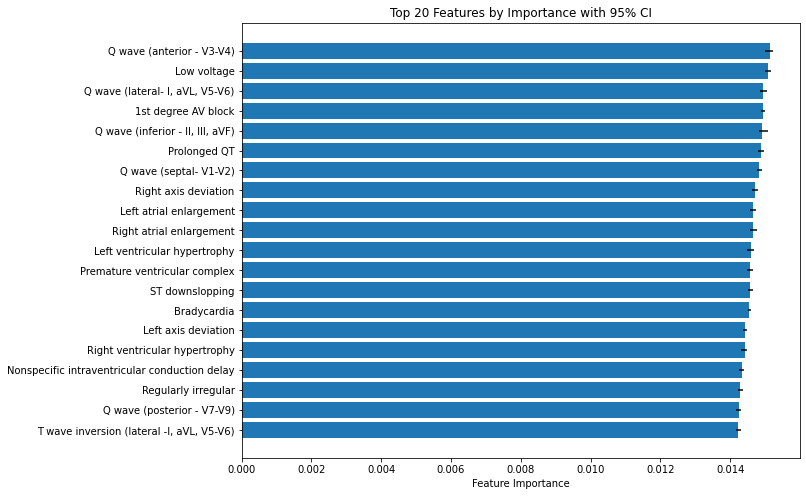

(     Label  Metrics   Mean           95% CI
 0  privacy    auroc  57.41  [57.26 - 57.68]
 1  privacy    auprc  55.32  [55.10 - 55.57]
 2  privacy      acc  50.83  [50.81 - 50.85]
 3  privacy     bacc  50.83  [50.81 - 50.85]
 4  privacy  f1score  67.00  [66.98 - 67.01],
 {'AUC': (0.5740524171485302, (0.5725729741578087, 0.57684190962766)),
  'AUPRC': (0.5531982167857841, (0.5509977298656825, 0.5556505801247642)),
  'Accuracy': (0.5082802612837731, (0.5080578052029125, 0.5085249530665723)),
  'Balanced Accuracy': (0.5082802612837731,
   (0.5080578052029125, 0.5085249530665723)),
  'F1 Score': (0.6699558379645689, (0.6698274671627933, 0.6701208221730346))})

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, f1_score, balanced_accuracy_score
from tqdm import tqdm
from joblib import Parallel, delayed
from scipy.stats import linregress

# Predefined seeds for reproducibility
seeds = [42, 0, 7, 13, 21, 25, 31, 37, 51, 57]

# Define feature names based on the number of columns in train_probs
# This should match the number of labels or classes you have
feature_names = [f"feature_{i}" for i in range(train_probs.shape[1])]

# Function to train and evaluate the model for a given seed
def train_and_evaluate(seed):
    X_train_attack, X_test_attack, y_train_attack, y_test_attack = train_test_split(
        attack_data, attack_labels, test_size=0.2, random_state=seed
    )
    
    class_0_indices = np.where(y_test_attack == 0)[0]
    class_1_indices = np.where(y_test_attack == 1)[0]
    min_class_size = min(len(class_0_indices), len(class_1_indices))
    
    balanced_class_0_indices = np.random.choice(class_0_indices, min_class_size, replace=False)
    balanced_class_1_indices = np.random.choice(class_1_indices, min_class_size, replace=False)
    balanced_indices = np.concatenate([balanced_class_0_indices, balanced_class_1_indices])
    
    X_test_attack_balanced = X_test_attack[balanced_indices]
    y_test_attack_balanced = y_test_attack[balanced_indices]

    attack_model = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=seed)
    attack_model.fit(X_train_attack, y_train_attack)

    feature_importances = attack_model.feature_importances_

    attack_preds_proba = attack_model.predict_proba(X_test_attack_balanced)[:, 1]
    attack_preds = attack_model.predict(X_test_attack_balanced)

    auc = roc_auc_score(y_test_attack_balanced, attack_preds_proba)
    auprc = average_precision_score(y_test_attack_balanced, attack_preds_proba)
    accuracy = accuracy_score(y_test_attack_balanced, attack_preds)
    balanced_accuracy = balanced_accuracy_score(y_test_attack_balanced, attack_preds)
    f1 = f1_score(y_test_attack_balanced, attack_preds)
    
    return auc, auprc, accuracy, balanced_accuracy, f1, feature_importances

# Run iterations and collect results
results = Parallel(n_jobs=-1)(delayed(train_and_evaluate)(seed) for seed in tqdm(seeds, desc="Training iterations"))
auc_scores, auprc_scores, accuracy_scores, balanced_accuracy_scores, f1_scores, feature_importances_all = zip(*results)

def mean_and_ci(scores):
    mean_score = np.mean(scores)
    ci_lower, ci_upper = np.percentile(scores, [2.5, 97.5])
    return mean_score, (ci_lower, ci_upper)

metrics = {
    "AUC": mean_and_ci(auc_scores),
    "AUPRC": mean_and_ci(auprc_scores),
    "Accuracy": mean_and_ci(accuracy_scores),
    "Balanced Accuracy": mean_and_ci(balanced_accuracy_scores),
    "F1 Score": mean_and_ci(f1_scores)
}

for metric, (mean, ci) in metrics.items():
    print(f"{metric} - Mean: {mean:.4f}, 95% CI: [{ci[0]:.4f}, {ci[1]:.4f}]")

# Calculate mean feature importances

feature_importances_all = np.array(feature_importances_all)
mean_importances = np.mean(feature_importances_all, axis=0)
ci_importances = np.percentile(feature_importances_all, [2.5, 97.5], axis=0)
ci_lower = ci_importances[0]
ci_upper = ci_importances[1]

# Get top 20 features based on average importance
top_indices = np.argsort(mean_importances)[-20:][::-1]
top_features = [y_labels[i] for i in top_indices]  # Use new_label_names for labels
top_mean_importances = mean_importances[top_indices]
top_ci_lower = ci_lower[top_indices]
top_ci_upper = ci_upper[top_indices]

# Plot top 20 features with confidence intervals
plt.figure(figsize=(10, 8))
plt.barh(top_features, top_mean_importances, xerr=[top_mean_importances - top_ci_lower, top_ci_upper - top_mean_importances], align='center')
plt.xlabel('Feature Importance')
plt.title('Top 20 Features by Importance with 95% CI')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.show()

# Calculate label frequencies in y_train and y_test
train_freq = np.mean(Y_train, axis=0)
test_freq = np.mean(Y_test, axis=0)

# Compute the relative difference in frequency
#relative_diff = (train_freq - test_freq) / (train_freq)

# Scatter plot of relative difference in frequency vs feature importance
#plt.figure(figsize=(10, 6))
#plt.scatter(relative_diff, mean_importances, alpha=0.7, color="b", label="Features")

# Regression line
#slope, intercept, r_value, p_value, std_err = linregress(relative_diff, mean_importances)
#line = slope * relative_diff + intercept
#plt.plot(relative_diff, line, 'r', label=f"Regression line (r={r_value:.2f})")

# Labels and title
#plt.xlabel("Relative Difference in Label Frequency (Train vs Test)")
#plt.ylabel("Average Feature Importance")
#plt.title("Correlation Between Label Frequency Difference and Feature Importance")
#plt.legend()
#plt.show()

save_ssl_privacy(metrics), metrics

In [15]:
def save_sl_privacy(scores_dict, subset):
    label = 'privacy'
    scores = {}
    scores[f'{label}_auroc'] = {'mean': scores_dict['AUC'][0], '95% CI': list(scores_dict['AUC'][1])}
    scores[f'{label}_auprc'] = {'mean': scores_dict['AUPRC'][0], '95% CI': list(scores_dict['AUPRC'][1])}
    scores[f'{label}_acc'] = {'mean': scores_dict['Accuracy'][0], '95% CI': list(scores_dict['Accuracy'][1])}
    scores[f'{label}_bacc'] = {'mean': scores_dict['Balanced Accuracy'][0], '95% CI': list(scores_dict['Balanced Accuracy'][1])}
    scores[f'{label}_f1score'] = {'mean': scores_dict['F1 Score'][0], '95% CI': list(scores_dict['F1 Score'][1])}
    
    scores = format_ci_metrics(scores, {}, [label], metrics=['auroc', 'auprc', 'acc', 'bacc', 'f1score'],)
    results_path = '/media/data1/anolin/for_achille_ssl/for_table'
    n_perm = 1000
    ratio = 0.7
    scores.to_csv(os.path.join(results_path, f'{subset}_77_labels', f'privacy_{n_perm}_{ratio}_.csv'))
    return scores


save_sl_privacy(
     {'AUC': (0.578416194578245, (0.575926938576351, 0.5817773373812397)), 'AUPRC': (0.5567188449991891, (0.5545273328301821, 0.56000041736794)), 'Accuracy': (0.5100158175954501, (0.5095547142284523, 0.5103799170347778)), 'Balanced Accuracy': (0.5100158175954502, (0.5095547142284523, 0.5103799170347779)), 'F1 Score': (0.6705999359043787, (0.6704011481374901, 0.6707812802103431))}      

,subset='MHI'
)

Label  Metrics   Mean           95% CI
0  privacy    auroc  57.84  [57.59 - 58.18]
1  privacy    auprc  55.67  [55.45 - 56.00]
2  privacy      acc  51.00  [50.96 - 51.04]
3  privacy     bacc  51.00  [50.96 - 51.04]
4  privacy  f1score  67.06  [67.04 - 67.08]

In [17]:
import numpy as np
import pandas as pd

#np.load('/media/data1/anolin/Y_val_v1.1.npy').shape
#pd.read_csv('/media/data1/ravram/DeepECG_Datasets/val_filtered_echo_v2.csv').shape

#np.load('/media/data1/anolin/for_achille_ssl/AFIB/Y_Afib_filtered_val.npy').shape
pd.read_csv('/media/data1/ravram/DeepECG_Datasets/mhi-lqts-type-train-lite.csv').shape


(287, 6)

In [18]:
n_mhi = 1017719 + 149177 
n_lvef = 88677 + 823
n_afib = 469197 + 68545
n_lqts = 2210 + 531
n_lqts_type = 287 + 47

n_lqts_type, n_lqts, n_lvef, n_afib, n_mhi, 

(334, 2741, 89500, 537742, 1166896)